Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$

Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_0
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \delta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + (\eta - 1) (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{\delta \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [59]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [203]:
# Pre-industrial: 282.87K

sa = 1
# Incoming radiation
Q0 = 342.5
## land fraction and albedo
#Fraction of land on the planet
p = 0.3

## outgoing radiation linearized
kappa = 1.74
Tkappa = 154
# Greenhouse effect parameter
B = 5.35

## Volcanism
Volcan = 0.028

## Biopump parameters
# Cbio_low = 150
# Cbio_high = 1000

Ts = 282.9
Cs = 275.5

#wa = 0.05
#cod = 0.15
alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 0.107
tauc = 20
coc0 = 350 # initial sea carbon
## Ocean albedo parameters
Talphaocean_low  = 219
Talphaocean_high = 299
alphaocean_max   = 0.84
alphaocean_min   = 0.255


Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5


# Ocean albedo
def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [192]:
# Economic paramaters # Control Ca to be around 10, gigaton,
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta = 0.01
eta = 0.032

# State variable
# Temperature anomaly
T_min = 0. # Preindustrial 
T_max = 20. # 
hT = 0.1
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, transform to gigaton
C_min = C0 - 200. # 250 x ppm x 
C_max = C0 + 400. # 300
hC = 25
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon
F_min = 0. # 10. avaoid 
F_max = 800. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 40.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(191, 25, 21)

In [213]:
Too = 282.86

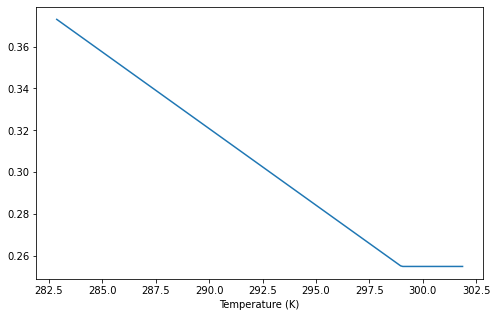

(0.255, 0.3730237499999999)

In [214]:
α_ocean = alphaocean(T_grid + Too)
plt.plot(Too + T_grid, α_ocean)
plt.xlabel("Temperature (K)")

plt.show()
α_ocean.min(), α_ocean.max()

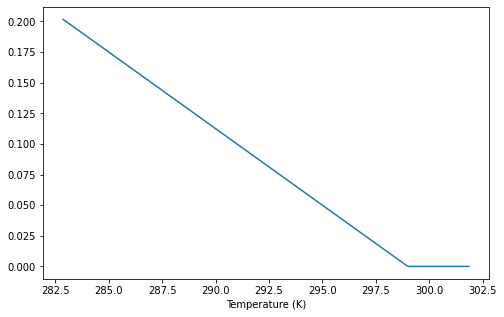

(0.0, 0.20174999999999976)

In [206]:
frac_sea_ice = fracseaice(T_grid + Too)
plt.plot(T_grid + Too, frac_sea_ice)
plt.xlabel("Temperature (K)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

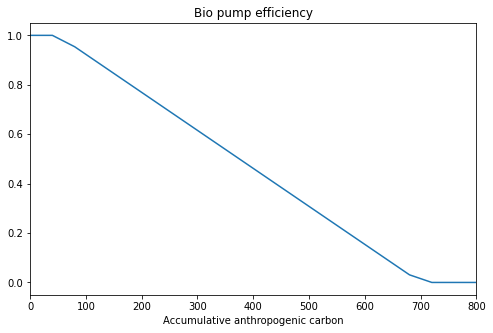

In [207]:
bio_pump_efficiency = biopump(F_grid)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon")
plt.title("Bio pump efficiency")
plt.xlim(0, 800)
plt.show()

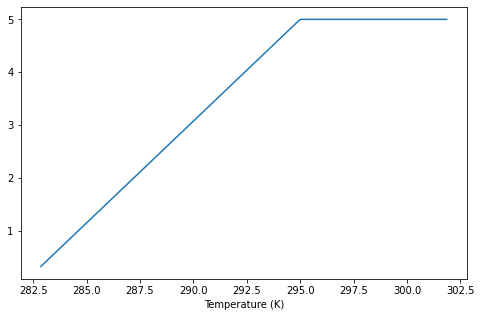

(0.33076923076923603, 5.0)

In [210]:
vege_growth = veggrowth(Too + T_grid)

plt.plot(Too + T_grid, vege_growth)
plt.xlabel("Temperature (K)")

plt.show()

vege_growth.min(), vege_growth.max()

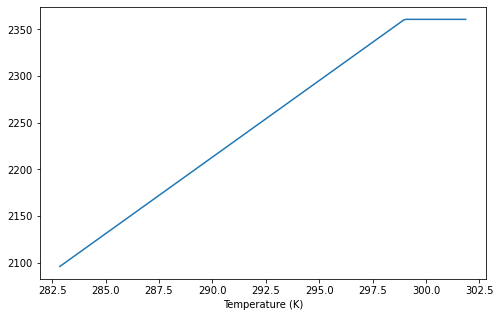

In [211]:
ri = Ri(Too + T_grid)

# r0 = R0(Too + T_grid, )
plt.plot(Too + T_grid, ri)
plt.xlabel("Temperature (K)")

plt.show()

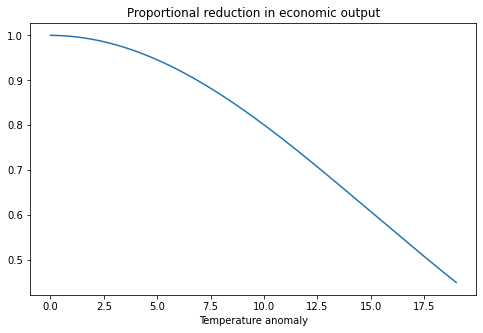

In [212]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [33]:
v0 =  -  F_mat

dG  = gamma_1 + gamma_2 * T_mat

epsilon  = 0.1
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 20000
fraction = 1.


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)

        

    Ca = - eta * delta / (dvdC + dvdF)
    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
       
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + T0) - Ro(T_mat + T0, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * (C_mat) * vegcover * veggrowth(T_mat +T0)
    B2 += oceanatmphysflux(T_mat + T0) * (1 - fracseaice(T_mat + T0))
    B2 += oceanbioflux(T_mat + T0, F_mat, sa) * (1 - fracseaice(T_mat + T0))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + T0))
    B3 = Ca
    C1 = 1e-3 * np.ones(T_mat.shape)
    C2 = 1e-3 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta  * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration %s: False Transient Error: %s; PDE Error %s" % (count, lhs_error, rhs_error))

print("Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

Iteration 1: False Transient Error: 14.938949602068305; PDE Error 39.48159320572495
Iteration 2: False Transient Error: 10.180223388252898; PDE Error 14.938971453099276
Iteration 3: False Transient Error: 9.516254736953442; PDE Error 10.18022364333721
Iteration 4: False Transient Error: 10.33470323049766; PDE Error 9.517015128661075
Iteration 5: False Transient Error: 11.251294559203195; PDE Error 10.33471251121735
Iteration 6: False Transient Error: 12.033435396991141; PDE Error 11.251303491543585
Iteration 7: False Transient Error: 12.683762009264017; PDE Error 12.033443865059256
Iteration 8: False Transient Error: 13.20591448269723; PDE Error 12.683771100948356
Iteration 9: False Transient Error: 13.604391010368104; PDE Error 13.205924605275747
Iteration 10: False Transient Error: 13.884411820936489; PDE Error 13.604402182385899
Iteration 11: False Transient Error: 14.05179481849288; PDE Error 13.884423924286638
Iteration 12: False Transient Error: 14.112842726659434; PDE Error 14.0

Iteration 99: False Transient Error: 7.353659509190038; PDE Error 7.7050825536806835
Iteration 100: False Transient Error: 7.345366117568801; PDE Error 7.697025908214993
Iteration 101: False Transient Error: 7.33680798052319; PDE Error 7.69157869402263
Iteration 102: False Transient Error: 7.327998437083352; PDE Error 7.688461296612581
Iteration 103: False Transient Error: 7.3189510037411765; PDE Error 7.687402604061954
Iteration 104: False Transient Error: 7.309754590805824; PDE Error 7.688141842634448
Iteration 105: False Transient Error: 7.300375810636979; PDE Error 7.690430170789596
Iteration 106: False Transient Error: 7.290819914012445; PDE Error 7.694032033102853
Iteration 107: False Transient Error: 7.281087152936152; PDE Error 7.698726278563187
Iteration 108: False Transient Error: 7.271178828792699; PDE Error 7.704307048609884
Iteration 109: False Transient Error: 7.2611083839967705; PDE Error 7.710584442245188
Iteration 110: False Transient Error: 7.25171130765375; PDE Error

Iteration 199: False Transient Error: 6.771472855427874; PDE Error 7.842316684770225
Iteration 200: False Transient Error: 6.757477576078372; PDE Error 7.8278475429377625
Iteration 201: False Transient Error: 6.743058534833608; PDE Error 7.813112251697802
Iteration 202: False Transient Error: 6.728249387440428; PDE Error 7.79814194776561
Iteration 203: False Transient Error: 6.713084345793732; PDE Error 7.782967703885181
Iteration 204: False Transient Error: 6.697598016388611; PDE Error 7.767620409540459
Iteration 205: False Transient Error: 6.681825243898629; PDE Error 7.75213065812282
Iteration 206: False Transient Error: 6.665800959895023; PDE Error 7.736528640392949
Iteration 207: False Transient Error: 6.649560037594711; PDE Error 7.720844044511998
Iteration 208: False Transient Error: 6.633137153379494; PDE Error 7.705105962982673
Iteration 209: False Transient Error: 6.616566654830649; PDE Error 7.68934280626927
Iteration 210: False Transient Error: 6.599882436427151; PDE Error 

Iteration 299: False Transient Error: 5.983685537909196; PDE Error 7.088018912289992
Iteration 300: False Transient Error: 5.979266489765678; PDE Error 7.083589676217643
Iteration 301: False Transient Error: 5.974676978393063; PDE Error 7.079020498130216
Iteration 302: False Transient Error: 5.969917789616375; PDE Error 7.074311393598516
Iteration 303: False Transient Error: 5.964990117893194; PDE Error 7.069462733973599
Iteration 304: False Transient Error: 5.95989555512233; PDE Error 7.064475238236888
Iteration 305: False Transient Error: 5.954636078569138; PDE Error 7.059349963876153
Iteration 306: False Transient Error: 5.949214038216724; PDE Error 7.054088297032825
Iteration 307: False Transient Error: 5.943632143487321; PDE Error 7.048691942619036
Iteration 308: False Transient Error: 5.937893449162175; PDE Error 7.043162913095269
Iteration 309: False Transient Error: 5.9320013408171235; PDE Error 7.037503517055382
Iteration 310: False Transient Error: 5.925959519779553; PDE Erro

Iteration 397: False Transient Error: 5.3779533555393755; PDE Error 6.478742666156629
Iteration 398: False Transient Error: 5.372560287798933; PDE Error 6.474223612801181
Iteration 399: False Transient Error: 5.367165488671617; PDE Error 6.469718295126786
Iteration 400: False Transient Error: 5.361769197777448; PDE Error 6.465224352645786
Iteration 401: False Transient Error: 5.356371666007362; PDE Error 6.460739465913893
Iteration 402: False Transient Error: 5.350986314687134; PDE Error 6.4562613613909425
Iteration 403: False Transient Error: 5.345602946931649; PDE Error 6.451787815662965
Iteration 404: False Transient Error: 5.340218703988739; PDE Error 6.447316659948575
Iteration 405: False Transient Error: 5.334850552625312; PDE Error 6.442845784054806
Iteration 406: False Transient Error: 5.329492039278421; PDE Error 6.438373140270004
Iteration 407: False Transient Error: 5.3241327146940876; PDE Error 6.4338967467881
Iteration 408: False Transient Error: 5.318773168662574; PDE Err

Iteration 496: False Transient Error: 4.8693975979608695; PDE Error 5.979356083590213
Iteration 497: False Transient Error: 4.864521407785105; PDE Error 5.974396632230604
Iteration 498: False Transient Error: 4.859658705336187; PDE Error 5.96945651213098
Iteration 499: False Transient Error: 4.854798809644194; PDE Error 5.96453556871412
Iteration 500: False Transient Error: 4.849941764144319; PDE Error 5.959633615148006
Iteration 501: False Transient Error: 4.84508763185886; PDE Error 5.9547504335961
Iteration 502: False Transient Error: 4.840236479045643; PDE Error 5.949885776507059
Iteration 503: False Transient Error: 4.835388374949048; PDE Error 5.945039367854591
Iteration 504: False Transient Error: 4.830543391501578; PDE Error 5.940210904497364
Iteration 505: False Transient Error: 4.825701603121502; PDE Error 5.9354000576398525
Iteration 506: False Transient Error: 4.820863086405893; PDE Error 5.930606474190202
Iteration 507: False Transient Error: 4.8160401286759225; PDE Error 

Iteration 595: False Transient Error: 4.41107313109967; PDE Error 5.525886820837226
Iteration 596: False Transient Error: 4.406571272563156; PDE Error 5.52139025737766
Iteration 597: False Transient Error: 4.402073347527562; PDE Error 5.516898397100472
Iteration 598: False Transient Error: 4.397585983926433; PDE Error 5.512411445332581
Iteration 599: False Transient Error: 4.3931131127942535; PDE Error 5.507929601222771
Iteration 600: False Transient Error: 4.388644458364865; PDE Error 5.503453057288903
Iteration 601: False Transient Error: 4.384186748464458; PDE Error 5.498981999206824
Iteration 602: False Transient Error: 4.379742222395748; PDE Error 5.494516605349517
Iteration 603: False Transient Error: 4.375302091085587; PDE Error 5.490057046613748
Iteration 604: False Transient Error: 4.37087680880893; PDE Error 5.485603486128781
Iteration 605: False Transient Error: 4.366459581692084; PDE Error 5.481156078976085
Iteration 606: False Transient Error: 4.362048122847568; PDE Error 

Iteration 692: False Transient Error: 4.003054719183865; PDE Error 5.1177580038767685
Iteration 693: False Transient Error: 3.999059459742398; PDE Error 5.113760733267832
Iteration 694: False Transient Error: 3.99506656426297; PDE Error 5.109766074269056
Iteration 695: False Transient Error: 3.9910760642231935; PDE Error 5.105774047225585
Iteration 696: False Transient Error: 3.987087994220815; PDE Error 5.101784675313665
Iteration 697: False Transient Error: 3.983102391885609; PDE Error 5.097797984366426
Iteration 698: False Transient Error: 3.9791192976355205; PDE Error 5.09381400280041
Iteration 699: False Transient Error: 3.9751387544731642; PDE Error 5.0898327614523255
Iteration 700: False Transient Error: 3.9711608079130656; PDE Error 5.085854293421307
Iteration 701: False Transient Error: 3.9671855057054017; PDE Error 5.0818786339681825
Iteration 702: False Transient Error: 3.963212897701851; PDE Error 5.07790582030842
Iteration 703: False Transient Error: 3.9592430355980923; PD

Iteration 791: False Transient Error: 3.625407424231639; PDE Error 4.739782600456116
Iteration 792: False Transient Error: 3.621785666536539; PDE Error 4.736166148702569
Iteration 793: False Transient Error: 3.61816746594684; PDE Error 4.732553227056493
Iteration 794: False Transient Error: 3.614552830639468; PDE Error 4.728943812993217
Iteration 795: False Transient Error: 3.6109420257810143; PDE Error 4.725337884691522
Iteration 796: False Transient Error: 3.6073347671219835; PDE Error 4.7217354211185585
Iteration 797: False Transient Error: 3.6037310532020683; PDE Error 4.718136401999314
Iteration 798: False Transient Error: 3.6001311514365852; PDE Error 4.71454080784971
Iteration 799: False Transient Error: 3.596543642553911; PDE Error 4.710948620059273
Iteration 800: False Transient Error: 3.592959446315831; PDE Error 4.707359820814299
Iteration 801: False Transient Error: 3.589378544735382; PDE Error 4.703774393187344
Iteration 802: False Transient Error: 3.585800920963038; PDE E

Iteration 889: False Transient Error: 3.2871459363354916; PDE Error 4.40121161882207
Iteration 890: False Transient Error: 3.283862250528955; PDE Error 4.397924963371049
Iteration 891: False Transient Error: 3.2805818288539967; PDE Error 4.394641718272902
Iteration 892: False Transient Error: 3.2773046688515706; PDE Error 4.391361876792316
Iteration 893: False Transient Error: 3.274030865196096; PDE Error 4.3880854319080616
Iteration 894: False Transient Error: 3.2707603964809095; PDE Error 4.384812376425069
Iteration 895: False Transient Error: 3.267493178610721; PDE Error 4.381542702958078
Iteration 896: False Transient Error: 3.2642292115667715; PDE Error 4.378276403938282
Iteration 897: False Transient Error: 3.2609684944941364; PDE Error 4.375013471665389
Iteration 898: False Transient Error: 3.257711036092701; PDE Error 4.371753898256933
Iteration 899: False Transient Error: 3.25445684263002; PDE Error 4.36849767567167
Iteration 900: False Transient Error: 3.251205913478543; PDE 

Iteration 987: False Transient Error: 2.980468658021209; PDE Error 4.094286410948039
Iteration 988: False Transient Error: 2.9774905643603233; PDE Error 4.09130556032451
Iteration 989: False Transient Error: 2.974515454745301; PDE Error 4.088327701644899
Iteration 990: False Transient Error: 2.971543328313828; PDE Error 4.085352833595454
Iteration 991: False Transient Error: 2.9685741841552726; PDE Error 4.082380954806399
Iteration 992: False Transient Error: 2.9656080212390634; PDE Error 4.079412063761202
Iteration 993: False Transient Error: 2.9626448385005233; PDE Error 4.076446158939704
Iteration 994: False Transient Error: 2.959684634737414; PDE Error 4.073483238699636
Iteration 995: False Transient Error: 2.956727408697475; PDE Error 4.0705233013183895
Iteration 996: False Transient Error: 2.9537731590352223; PDE Error 4.0675663449873305
Iteration 997: False Transient Error: 2.9508218843028544; PDE Error 4.064612367832381
Iteration 998: False Transient Error: 2.9478735829530933; 

Iteration 1086: False Transient Error: 2.6997043006639387; PDE Error 3.8132525998663285
Iteration 1087: False Transient Error: 2.697007631800261; PDE Error 3.8105532843976047
Iteration 1088: False Transient Error: 2.6943136432265646; PDE Error 3.807856654545783
Iteration 1089: False Transient Error: 2.6916223326679756; PDE Error 3.805162708025086
Iteration 1090: False Transient Error: 2.6889336978422307; PDE Error 3.8024714425957313
Iteration 1091: False Transient Error: 2.6862477365415316; PDE Error 3.799782856032766
Iteration 1092: False Transient Error: 2.6835644465444375; PDE Error 3.7970969461428536
Iteration 1093: False Transient Error: 2.680883825694309; PDE Error 3.7944137107124742
Iteration 1094: False Transient Error: 2.6782058717958535; PDE Error 3.7917331475580465
Iteration 1095: False Transient Error: 2.6755305827151687; PDE Error 3.7890552545101155
Iteration 1096: False Transient Error: 2.6728579563257426; PDE Error 3.7863800294125163
Iteration 1097: False Transient Error

Iteration 1180: False Transient Error: 2.4576363004717905; PDE Error 3.5709509109335054
Iteration 1181: False Transient Error: 2.4551815858814052; PDE Error 3.5684937881241545
Iteration 1182: False Transient Error: 2.4527293229988345; PDE Error 3.5660391182647126
Iteration 1183: False Transient Error: 2.4502795091194685; PDE Error 3.5635868987481523
Iteration 1184: False Transient Error: 2.4478321416398785; PDE Error 3.561137126960639
Iteration 1185: False Transient Error: 2.445387217887287; PDE Error 3.558689800267861
Iteration 1186: False Transient Error: 2.442944735277024; PDE Error 3.5562449161108622
Iteration 1187: False Transient Error: 2.4405046911647332; PDE Error 3.553802471878641
Iteration 1188: False Transient Error: 2.4380670829435758; PDE Error 3.5513624649753543
Iteration 1189: False Transient Error: 2.435631908047071; PDE Error 3.5489248928467125
Iteration 1190: False Transient Error: 2.4331991638905492; PDE Error 3.546489752964609
Iteration 1191: False Transient Error: 

Iteration 1277: False Transient Error: 2.2305883232544943; PDE Error 3.343676767336138
Iteration 1278: False Transient Error: 2.228362021880912; PDE Error 3.341446841992604
Iteration 1279: False Transient Error: 2.226137555102241; PDE Error 3.3392189740983405
Iteration 1280: False Transient Error: 2.2239150068489266; PDE Error 3.33699319810764
Iteration 1281: False Transient Error: 2.221694334028257; PDE Error 3.334769548175034
Iteration 1282: False Transient Error: 2.219475679983134; PDE Error 3.3325479702558134
Iteration 1283: False Transient Error: 2.217258771562456; PDE Error 3.3303285299527374
Iteration 1284: False Transient Error: 2.2150439513967513; PDE Error 3.3281112406180107
Iteration 1285: False Transient Error: 2.2128312088139523; PDE Error 3.3258961363819273
Iteration 1286: False Transient Error: 2.2106206363815772; PDE Error 3.3236832295151535
Iteration 1287: False Transient Error: 2.208412783209326; PDE Error 3.321472532147056
Iteration 1288: False Transient Error: 2.206

Iteration 1375: False Transient Error: 2.388326412284414; PDE Error 4.0709182493107425
Iteration 1376: False Transient Error: 2.3901310166002077; PDE Error 3.7568315921351196
Iteration 1377: False Transient Error: 2.376919688418866; PDE Error 3.4638217549857124
Iteration 1378: False Transient Error: 2.2926404044966375; PDE Error 3.188114805130305
Iteration 1379: False Transient Error: 2.178490484912743; PDE Error 3.1272117771960204
Iteration 1380: False Transient Error: 2.1004658896427486; PDE Error 3.1251923022502295
Iteration 1381: False Transient Error: 2.0372033948734725; PDE Error 3.12317469331102
Iteration 1382: False Transient Error: 2.008459735733936; PDE Error 3.121158987751567
Iteration 1383: False Transient Error: 2.0064547781581155; PDE Error 3.1191452163406854
Iteration 1384: False Transient Error: 2.0044519379996473; PDE Error 3.1171334643969573
Iteration 1385: False Transient Error: 2.002451189313774; PDE Error 3.115123500156871
Iteration 1386: False Transient Error: 2.0

Iteration 1470: False Transient Error: 1.839309041220929; PDE Error 2.9568794091735917
Iteration 1471: False Transient Error: 1.8374692372609047; PDE Error 2.9550514855692027
Iteration 1472: False Transient Error: 1.8356339710365432; PDE Error 2.953222640618134
Iteration 1473: False Transient Error: 1.8338005146239311; PDE Error 2.9513924916192424
Iteration 1474: False Transient Error: 1.8319688933721068; PDE Error 2.9495621636751688
Iteration 1475: False Transient Error: 1.830139103929298; PDE Error 2.9477321659147213
Iteration 1476: False Transient Error: 1.8283129666232867; PDE Error 2.945902965297244
Iteration 1477: False Transient Error: 1.826711720072467; PDE Error 2.9440748976989903
Iteration 1478: False Transient Error: 1.824660686695836; PDE Error 2.9422482283351155
Iteration 1479: False Transient Error: 1.8228381930427418; PDE Error 2.9404232671758397
Iteration 1480: False Transient Error: 1.821017519883128; PDE Error 2.9386001295094726
Iteration 1481: False Transient Error: 

Iteration 1568: False Transient Error: 1.8785800896105798; PDE Error 2.9733925882159626
Iteration 1569: False Transient Error: 1.9028486760706187; PDE Error 2.972295854412856
Iteration 1570: False Transient Error: 1.9164959733782894; PDE Error 2.9647011156451573
Iteration 1571: False Transient Error: 1.9206075990945237; PDE Error 2.952131350327903
Iteration 1572: False Transient Error: 1.9164850016915125; PDE Error 2.93597019707114
Iteration 1573: False Transient Error: 1.9055361834188034; PDE Error 2.9174395900595282
Iteration 1574: False Transient Error: 1.8891879250557508; PDE Error 2.897588952434318
Iteration 1575: False Transient Error: 1.8688180592971548; PDE Error 2.877293627307239
Iteration 1576: False Transient Error: 1.8458295738653874; PDE Error 2.857260423885349
Iteration 1577: False Transient Error: 1.8325073643629253; PDE Error 2.838038359516987
Iteration 1578: False Transient Error: 1.821180307139798; PDE Error 2.8200329760299683
Iteration 1579: False Transient Error: 1.

Iteration 1663: False Transient Error: 1.5166796187747877; PDE Error 2.6252350653655316
Iteration 1664: False Transient Error: 1.5151647039041904; PDE Error 2.623717850970504
Iteration 1665: False Transient Error: 1.513651309048214; PDE Error 2.6222021776310074
Iteration 1666: False Transient Error: 1.5121394303855595; PDE Error 2.620688062828741
Iteration 1667: False Transient Error: 1.5106290597256589; PDE Error 2.6191755132569625
Iteration 1668: False Transient Error: 1.5091201896890993; PDE Error 2.6176645438703163
Iteration 1669: False Transient Error: 1.5076128784292564; PDE Error 2.6161551577711597
Iteration 1670: False Transient Error: 1.5061070935433918; PDE Error 2.61464735333241
Iteration 1671: False Transient Error: 1.5046028135742517; PDE Error 2.6131411354191796
Iteration 1672: False Transient Error: 1.5031000372124481; PDE Error 2.611636493737193
Iteration 1673: False Transient Error: 1.501598763866241; PDE Error 2.6101334219633756
Iteration 1674: False Transient Error: 

Iteration 1759: False Transient Error: 1.4080700362104892; PDE Error 2.486306954796288
Iteration 1760: False Transient Error: 1.3765697930915621; PDE Error 2.4849275100851633
Iteration 1761: False Transient Error: 1.3751949659581442; PDE Error 2.4835494168804964
Iteration 1762: False Transient Error: 1.373821507506534; PDE Error 2.482172652904426
Iteration 1763: False Transient Error: 1.3724494174459778; PDE Error 2.4807971844445786
Iteration 1764: False Transient Error: 1.3710786958915833; PDE Error 2.4794230256081455
Iteration 1765: False Transient Error: 1.369709342760359; PDE Error 2.4780501442757643
Iteration 1766: False Transient Error: 1.3683413549185275; PDE Error 2.4766785320928584
Iteration 1767: False Transient Error: 1.3669747328853532; PDE Error 2.475308158965551
Iteration 1768: False Transient Error: 1.365609474174505; PDE Error 2.473939049748213
Iteration 1769: False Transient Error: 1.3642455757084804; PDE Error 2.472571194056134
Iteration 1770: False Transient Error: 1

Iteration 1854: False Transient Error: 2.7963075701364914; PDE Error 17.952881033212527
Iteration 1855: False Transient Error: 1.299066237165789; PDE Error 3.441415466560283
Iteration 1856: False Transient Error: 1.32903570292342; PDE Error 2.41594031431325
Iteration 1857: False Transient Error: 1.67418746902527; PDE Error 2.4143732950572634
Iteration 1858: False Transient Error: 1.5982159251939265; PDE Error 2.470288622663267
Iteration 1859: False Transient Error: 1.5093847019734596; PDE Error 2.4351172026131866
Iteration 1860: False Transient Error: 1.477943489542497; PDE Error 2.518966004449573
Iteration 1861: False Transient Error: 1.4988321220999978; PDE Error 2.5758594284177603
Iteration 1862: False Transient Error: 1.4936344660338818; PDE Error 2.6147857372893215
Iteration 1863: False Transient Error: 1.4816529841962733; PDE Error 2.6277067140025494
Iteration 1864: False Transient Error: 1.5049880801282711; PDE Error 2.6160055725496916
Iteration 1865: False Transient Error: 1.50

Iteration 1951: False Transient Error: 1.1424112610896486; PDE Error 2.409525705788756
Iteration 1952: False Transient Error: 1.1375479240705033; PDE Error 2.4094764182531208
Iteration 1953: False Transient Error: 1.1352892949970794; PDE Error 2.409427172490176
Iteration 1954: False Transient Error: 1.1472697767472084; PDE Error 2.409377957259032
Iteration 1955: False Transient Error: 1.1356864232367059; PDE Error 2.409328771379787
Iteration 1956: False Transient Error: 1.132206531257367; PDE Error 2.409279614792478
Iteration 1957: False Transient Error: 1.1306834705818858; PDE Error 2.4092304856226114
Iteration 1958: False Transient Error: 1.1612909456313503; PDE Error 2.4091813788034635
Iteration 1959: False Transient Error: 1.1345497617224964; PDE Error 2.40913228698685
Iteration 1960: False Transient Error: 1.1278800893070695; PDE Error 2.4090832008536154
Iteration 1961: False Transient Error: 1.4328305335860136; PDE Error 2.4090341107218514
Iteration 1962: False Transient Error: 1

Iteration 2050: False Transient Error: 1.0302709470731486; PDE Error 6.4226177029871145
Iteration 2051: False Transient Error: 1.0292420576628558; PDE Error 2.400334282781177
Iteration 2052: False Transient Error: 1.0282141909125642; PDE Error 2.4004156781011616
Iteration 2053: False Transient Error: 1.0271873474140136; PDE Error 2.4005746105700148
Iteration 2054: False Transient Error: 1.0261615230812993; PDE Error 2.4007945128132704
Iteration 2055: False Transient Error: 1.0251367200322647; PDE Error 2.401046203570967
Iteration 2056: False Transient Error: 1.0241129379383551; PDE Error 2.4012777813756436
Iteration 2057: False Transient Error: 1.0230901735847908; PDE Error 2.401338039664221
Iteration 2058: False Transient Error: 1.0220684299036975; PDE Error 2.400890963452042
Iteration 2059: False Transient Error: 1.021047705001621; PDE Error 2.3994363185617544
Iteration 2060: False Transient Error: 1.020027997370505; PDE Error 2.3964557727042823
Iteration 2061: False Transient Error:

Iteration 2147: False Transient Error: 1.010061803831377; PDE Error 2.4127379395442823
Iteration 2148: False Transient Error: 0.9488394285374113; PDE Error 2.4116401744501914
Iteration 2149: False Transient Error: 0.9332382229136726; PDE Error 2.4106102841984125
Iteration 2150: False Transient Error: 0.9323062366703994; PDE Error 2.4096705777972893
Iteration 2151: False Transient Error: 0.9313751824305427; PDE Error 2.4088306239568027
Iteration 2152: False Transient Error: 0.9304450577100454; PDE Error 2.408166974820954
Iteration 2153: False Transient Error: 0.9295158094778344; PDE Error 2.407597545568553
Iteration 2154: False Transient Error: 0.9285875267835308; PDE Error 2.4069675293871917
Iteration 2155: False Transient Error: 1.1593497454298074; PDE Error 2.4063241939814013
Iteration 2156: False Transient Error: 0.926733608797008; PDE Error 2.4057517121906216
Iteration 2157: False Transient Error: 0.9258078671221881; PDE Error 2.4052870677081835
Iteration 2158: False Transient Erro

Iteration 2244: False Transient Error: 0.9401298927848245; PDE Error 2.403427781456749
Iteration 2245: False Transient Error: 0.9363437959284227; PDE Error 2.403391082715512
Iteration 2246: False Transient Error: 0.924537001607888; PDE Error 2.4033543094054046
Iteration 2247: False Transient Error: 0.9052407661104667; PDE Error 2.4033174783471054
Iteration 2248: False Transient Error: 0.8791222216116523; PDE Error 2.4032806048875877
Iteration 2249: False Transient Error: 0.8566687174624121; PDE Error 2.4032437029525404
Iteration 2250: False Transient Error: 0.8549734946493004; PDE Error 2.403206784892454
Iteration 2251: False Transient Error: 1.6314457755574097; PDE Error 2.403169864186257
Iteration 2252: False Transient Error: 1.144088363026441; PDE Error 2.403132941321193
Iteration 2253: False Transient Error: 0.9852638649924472; PDE Error 2.4030960321305272
Iteration 2254: False Transient Error: 0.922429809311609; PDE Error 2.403059139768793
Iteration 2255: False Transient Error: 0.

Iteration 2339: False Transient Error: 0.7718818107152003; PDE Error 2.3987617541720034
Iteration 2340: False Transient Error: 0.7711110386722453; PDE Error 2.3986168221296147
Iteration 2341: False Transient Error: 0.7703410362304908; PDE Error 2.3984626690130106
Iteration 2342: False Transient Error: 0.7695718026846521; PDE Error 2.3982994798890473
Iteration 2343: False Transient Error: 0.7688033380451031; PDE Error 2.3981277858095247
Iteration 2344: False Transient Error: 0.7680356400815924; PDE Error 2.39794844463972
Iteration 2345: False Transient Error: 0.7672687099392306; PDE Error 2.397762574061712
Iteration 2346: False Transient Error: 0.766502545861556; PDE Error 2.397571437424535
Iteration 2347: False Transient Error: 0.7657371473638364; PDE Error 2.3973762826382874
Iteration 2348: False Transient Error: 0.7649725135222241; PDE Error 2.3971781362206173
Iteration 2349: False Transient Error: 0.7642086438794138; PDE Error 2.3969775419436097
Iteration 2350: False Transient Error

Iteration 2436: False Transient Error: 0.7005909439925517; PDE Error 2.388477388759238
Iteration 2437: False Transient Error: 0.6998913865105294; PDE Error 2.3944694621850218
Iteration 2438: False Transient Error: 0.6991925269819887; PDE Error 2.400024238241709
Iteration 2439: False Transient Error: 0.6984943653304754; PDE Error 2.405091465002105
Iteration 2440: False Transient Error: 0.6977968999983375; PDE Error 2.409633212852004
Iteration 2441: False Transient Error: 0.6971001311093517; PDE Error 2.4136234579786056
Iteration 2442: False Transient Error: 0.6964040558435158; PDE Error 2.417047339920142
Iteration 2443: False Transient Error: 0.6957086771531351; PDE Error 2.4199004046553796
Iteration 2444: False Transient Error: 0.6950139921734433; PDE Error 2.4221879301844105
Iteration 2445: False Transient Error: 0.6943199950991641; PDE Error 2.4239241588665976
Iteration 2446: False Transient Error: 0.7898825347145788; PDE Error 2.425131343563585
Iteration 2447: False Transient Error:

Iteration 2533: False Transient Error: 1.2742232424282918; PDE Error 2.3968845979879774
Iteration 2534: False Transient Error: 1.2490648342286192; PDE Error 2.3968566502633237
Iteration 2535: False Transient Error: 1.2268288441968878; PDE Error 2.3968310218511633
Iteration 2536: False Transient Error: 1.1957448976336593; PDE Error 2.3968073827857452
Iteration 2537: False Transient Error: 1.1570418481603895; PDE Error 2.3967854188170215
Iteration 2538: False Transient Error: 1.1120407392199638; PDE Error 2.3967648297226454
Iteration 2539: False Transient Error: 1.062110003500294; PDE Error 2.3967453319059793
Iteration 2540: False Transient Error: 1.0086238818900028; PDE Error 2.3967266604405566
Iteration 2541: False Transient Error: 0.9529250308972337; PDE Error 2.396708570985002
Iteration 2542: False Transient Error: 0.8962920159746091; PDE Error 2.3966908405185556
Iteration 2543: False Transient Error: 0.8399121412556099; PDE Error 2.396673268456393
Iteration 2544: False Transient Err

Iteration 2629: False Transient Error: 0.577851004842671; PDE Error 2.394416259967535
Iteration 2630: False Transient Error: 0.6032882843130238; PDE Error 2.3943867016986466
Iteration 2631: False Transient Error: 0.5895023912952979; PDE Error 2.3943568493623033
Iteration 2632: False Transient Error: 0.5823956168462985; PDE Error 2.3943266823327924
Iteration 2633: False Transient Error: 0.57983673417354; PDE Error 2.394296178823353
Iteration 2634: False Transient Error: 0.583033502781305; PDE Error 2.3942653157193767
Iteration 2635: False Transient Error: 0.5988010238391439; PDE Error 2.3942340685384096
Iteration 2636: False Transient Error: 0.6155867343440491; PDE Error 2.3942024113920084
Iteration 2637: False Transient Error: 0.6294043826201801; PDE Error 2.3941703169622066
Iteration 2638: False Transient Error: 0.6400073238661719; PDE Error 2.394137756084266
Iteration 2639: False Transient Error: 0.6472328118445603; PDE Error 2.3941046983273324
Iteration 2640: False Transient Error: 

Iteration 2726: False Transient Error: 0.5243877210607906; PDE Error 2.4139896917954964
Iteration 2727: False Transient Error: 0.5238641634814911; PDE Error 2.425599747542286
Iteration 2728: False Transient Error: 0.5233411265510313; PDE Error 2.4371342958110027
Iteration 2729: False Transient Error: 0.5228186103173726; PDE Error 2.4483795610140895
Iteration 2730: False Transient Error: 0.5222966147209718; PDE Error 2.459126862936703
Iteration 2731: False Transient Error: 0.5217751476026677; PDE Error 2.469177455956004
Iteration 2732: False Transient Error: 0.5212542158199795; PDE Error 2.47834698741714
Iteration 2733: False Transient Error: 0.7125236366670151; PDE Error 2.4864694617148473
Iteration 2734: False Transient Error: 0.5827297850719759; PDE Error 2.493400655909319
Iteration 2735: False Transient Error: 0.5196945184830781; PDE Error 2.499020870507522
Iteration 2736: False Transient Error: 0.5191756579061035; PDE Error 2.5032370328303806
Iteration 2737: False Transient Error: 

Iteration 2823: False Transient Error: 0.4759657770255643; PDE Error 2.401758014917604
Iteration 2824: False Transient Error: 0.4754906056235342; PDE Error 2.3970108044091667
Iteration 2825: False Transient Error: 0.47501591023284107; PDE Error 2.3922862084320293
Iteration 2826: False Transient Error: 0.47454169027950854; PDE Error 2.3876408164800935
Iteration 2827: False Transient Error: 0.47406794563528365; PDE Error 2.3839194710970375
Iteration 2828: False Transient Error: 0.47359467533837574; PDE Error 2.3840841535887876
Iteration 2829: False Transient Error: 0.47312187887108337; PDE Error 2.384304729731749
Iteration 2830: False Transient Error: 0.4726495560191779; PDE Error 2.3845738362824456
Iteration 2831: False Transient Error: 0.472177706388095; PDE Error 2.384884248956258
Iteration 2832: False Transient Error: 0.4717063286010159; PDE Error 2.385228956147447
Iteration 2833: False Transient Error: 0.47123542311098277; PDE Error 2.3856012227681553
Iteration 2834: False Transient

Iteration 2920: False Transient Error: 0.4720503023606426; PDE Error 2.3883941865619036
Iteration 2921: False Transient Error: 0.48262069396464824; PDE Error 2.388360739669661
Iteration 2922: False Transient Error: 0.49070716948293125; PDE Error 2.388329242876239
Iteration 2923: False Transient Error: 0.49660252771438707; PDE Error 2.3882996806950167
Iteration 2924: False Transient Error: 0.5005819023160285; PDE Error 2.388272226111553
Iteration 2925: False Transient Error: 0.5028999064955286; PDE Error 2.388246353805659
Iteration 2926: False Transient Error: 0.7359837336353081; PDE Error 2.3882223369673667
Iteration 2927: False Transient Error: 0.7133056213516653; PDE Error 2.3882002074868716
Iteration 2928: False Transient Error: 0.6688110741943376; PDE Error 2.3881798851624936
Iteration 2929: False Transient Error: 0.6280407878634264; PDE Error 2.388161309497775
Iteration 2930: False Transient Error: 0.6226188186226977; PDE Error 2.3881444443163424
Iteration 2931: False Transient Er

Iteration 3015: False Transient Error: 0.49508178302978934; PDE Error 2.387785957884134
Iteration 3016: False Transient Error: 0.4969457518863152; PDE Error 2.387751587619203
Iteration 3017: False Transient Error: 0.49721261072456; PDE Error 2.387716289124608
Iteration 3018: False Transient Error: 0.49600098913145985; PDE Error 2.3876800872149815
Iteration 3019: False Transient Error: 0.4934460720267708; PDE Error 2.3876430073268047
Iteration 3020: False Transient Error: 0.5077984273150093; PDE Error 2.3876050753732443
Iteration 3021: False Transient Error: 0.5197130256050286; PDE Error 2.3875663173841133
Iteration 3022: False Transient Error: 0.5276346709226232; PDE Error 2.387526759230049
Iteration 3023: False Transient Error: 0.5315947069161098; PDE Error 2.3874864265028535
Iteration 3024: False Transient Error: 0.5316838132997503; PDE Error 2.3874453439517396
Iteration 3025: False Transient Error: 0.5280475564886444; PDE Error 2.3874035356383594
Iteration 3026: False Transient Erro

Iteration 3110: False Transient Error: 0.35969506078011193; PDE Error 2.3687517352297824
Iteration 3111: False Transient Error: 0.35849091500359975; PDE Error 2.3688855178731245
Iteration 3112: False Transient Error: 0.35736854635295856; PDE Error 2.3689389115492148
Iteration 3113: False Transient Error: 0.35644633824198024; PDE Error 2.3688848184639326
Iteration 3114: False Transient Error: 0.3559497388626198; PDE Error 2.3700446478193697
Iteration 3115: False Transient Error: 0.3555776476274275; PDE Error 2.3822601209340526
Iteration 3116: False Transient Error: 0.3552217502573285; PDE Error 2.395151406405457
Iteration 3117: False Transient Error: 0.35486691026065387; PDE Error 2.4085517052300176
Iteration 3118: False Transient Error: 0.3562979599526983; PDE Error 2.4222814810336217
Iteration 3119: False Transient Error: 0.36298566525530873; PDE Error 2.4361518329571794
Iteration 3120: False Transient Error: 0.6842583712814587; PDE Error 2.4499680561436925
Iteration 3121: False Trans

Iteration 3205: False Transient Error: 0.3249463154489973; PDE Error 2.402911593883381
Iteration 3206: False Transient Error: 0.324619584383683; PDE Error 2.4008483118511634
Iteration 3207: False Transient Error: 0.32429460419827194; PDE Error 2.398742329548238
Iteration 3208: False Transient Error: 0.3239704542625077; PDE Error 2.396619292608431
Iteration 3209: False Transient Error: 0.32364647789734136; PDE Error 2.3945032198842604
Iteration 3210: False Transient Error: 0.3233226887617491; PDE Error 2.392416375049031
Iteration 3211: False Transient Error: 0.3229990995583165; PDE Error 2.390379166235636
Iteration 3212: False Transient Error: 0.3226757223009713; PDE Error 2.3884100746673695
Iteration 3213: False Transient Error: 0.3725770744953394; PDE Error 2.386525608956063
Iteration 3214: False Transient Error: 0.44283906812161433; PDE Error 2.3847402829220243
Iteration 3215: False Transient Error: 0.38325715032840435; PDE Error 2.383066619099825
Iteration 3216: False Transient Erro

Iteration 3299: False Transient Error: 0.29580879298489293; PDE Error 2.3772528069690857
Iteration 3300: False Transient Error: 0.2955135693584765; PDE Error 2.3769187352086902
Iteration 3301: False Transient Error: 0.29700960999601733; PDE Error 2.3767333192742797
Iteration 3302: False Transient Error: 0.5778210190343458; PDE Error 2.376510872969561
Iteration 3303: False Transient Error: 0.3094903244083369; PDE Error 2.3762534555865216
Iteration 3304: False Transient Error: 0.3163696768244506; PDE Error 2.3759632268000175
Iteration 3305: False Transient Error: 0.7018323411303484; PDE Error 2.375642429215315
Iteration 3306: False Transient Error: 0.47750471805841244; PDE Error 2.3752933721844443
Iteration 3307: False Transient Error: 0.3628784755492198; PDE Error 2.374918418691916
Iteration 3308: False Transient Error: 0.8251403295689386; PDE Error 2.3745199654548124
Iteration 3309: False Transient Error: 1.1434447466289654; PDE Error 4.2870276772358356
Iteration 3310: False Transient 

Iteration 3397: False Transient Error: 0.29585195113956075; PDE Error 2.3844994205494707
Iteration 3398: False Transient Error: 0.30451080370056616; PDE Error 2.3843334476652913
Iteration 3399: False Transient Error: 0.3118252569955615; PDE Error 2.3841608672652583
Iteration 3400: False Transient Error: 0.3178175410950601; PDE Error 2.3839822038924297
Iteration 3401: False Transient Error: 0.32252955054257626; PDE Error 2.38379799671576
Iteration 3402: False Transient Error: 0.32601914987857583; PDE Error 2.383608798236196
Iteration 3403: False Transient Error: 0.3297983021801443; PDE Error 2.3834151712884015
Iteration 3404: False Transient Error: 0.3420657544452155; PDE Error 2.383217687186015
Iteration 3405: False Transient Error: 0.3525821391547268; PDE Error 2.3830169235836465
Iteration 3406: False Transient Error: 0.361309955118827; PDE Error 2.3828134619103736
Iteration 3407: False Transient Error: 0.3682459278750372; PDE Error 2.3826078848397287
Iteration 3408: False Transient E

Iteration 3491: False Transient Error: 0.9391267518541468; PDE Error 2.379780144468562
Iteration 3492: False Transient Error: 0.902542771478565; PDE Error 2.3798649908536333
Iteration 3493: False Transient Error: 0.8774148353364808; PDE Error 2.37994987824489
Iteration 3494: False Transient Error: 0.860970945523647; PDE Error 2.3800346272453403
Iteration 3495: False Transient Error: 0.8340306779110307; PDE Error 2.38011904965985
Iteration 3496: False Transient Error: 0.7957278638078691; PDE Error 2.380202944146898
Iteration 3497: False Transient Error: 0.7462048536825705; PDE Error 2.380286095022168
Iteration 3498: False Transient Error: 0.6859092754058338; PDE Error 2.380368273310573
Iteration 3499: False Transient Error: 0.6155825680512805; PDE Error 2.3804492397741797
Iteration 3500: False Transient Error: 0.6219089121088217; PDE Error 2.3805287466350187
Iteration 3501: False Transient Error: 0.6249042984634201; PDE Error 2.380606538376785
Iteration 3502: False Transient Error: 0.62

Iteration 3585: False Transient Error: 0.5467793721550862; PDE Error 2.377921889712926
Iteration 3586: False Transient Error: 0.556528468140769; PDE Error 2.3779525370642354
Iteration 3587: False Transient Error: 0.6379143679033916; PDE Error 2.3779767785213544
Iteration 3588: False Transient Error: 0.7153339304945661; PDE Error 2.3779934801642533
Iteration 3589: False Transient Error: 0.8236913110571464; PDE Error 2.3780015274982915
Iteration 3590: False Transient Error: 0.9257078981518063; PDE Error 2.377999832100077
Iteration 3591: False Transient Error: 1.0203034068682726; PDE Error 2.377987327377049
Iteration 3592: False Transient Error: 1.1064960497672516; PDE Error 2.3779629783512846
Iteration 3593: False Transient Error: 1.183414254566415; PDE Error 2.3779257700985887
Iteration 3594: False Transient Error: 1.2503068816111096; PDE Error 2.448969330617956
Iteration 3595: False Transient Error: 1.3065510148542359; PDE Error 2.5333984050175857
Iteration 3596: False Transient Error:

Iteration 3681: False Transient Error: 0.5737861774397857; PDE Error 2.546808098973095
Iteration 3682: False Transient Error: 0.5857876613487889; PDE Error 2.5359547731093315
Iteration 3683: False Transient Error: 0.5893801860383263; PDE Error 2.5241642610228894
Iteration 3684: False Transient Error: 0.5845617672595438; PDE Error 2.5115533799834715
Iteration 3685: False Transient Error: 0.5714556322217845; PDE Error 2.498243946732437
Iteration 3686: False Transient Error: 0.5503064495178478; PDE Error 2.484361246713391
Iteration 3687: False Transient Error: 0.5282466522356799; PDE Error 2.4700325222036454
Iteration 3688: False Transient Error: 0.5440349463594174; PDE Error 2.4553854992282744
Iteration 3689: False Transient Error: 0.5571751578512618; PDE Error 2.440546971284398
Iteration 3690: False Transient Error: 0.5676761101715044; PDE Error 2.4256414558989796
Iteration 3691: False Transient Error: 0.5755590784393405; PDE Error 2.4107899385656317
Iteration 3692: False Transient Erro

Iteration 3775: False Transient Error: 0.2374576960106367; PDE Error 2.399069170319674
Iteration 3776: False Transient Error: 0.2524954420599812; PDE Error 2.399274598391596
Iteration 3777: False Transient Error: 0.2657901493593329; PDE Error 2.3995054292783315
Iteration 3778: False Transient Error: 0.2772415935402961; PDE Error 2.399759053480185
Iteration 3779: False Transient Error: 0.28677852622081446; PDE Error 2.4000324253198215
Iteration 3780: False Transient Error: 0.29435867813958794; PDE Error 2.4003221194405633
Iteration 3781: False Transient Error: 0.29996824529803234; PDE Error 2.400624387081809
Iteration 3782: False Transient Error: 0.6294561097340434; PDE Error 2.4009352117740157
Iteration 3783: False Transient Error: 0.30535634317381266; PDE Error 2.4012503643467333
Iteration 3784: False Transient Error: 0.30523854253132754; PDE Error 2.401565455148255
Iteration 3785: False Transient Error: 0.30335355705531697; PDE Error 2.4018759871002864
Iteration 3786: False Transient

Iteration 3870: False Transient Error: 0.469045947518012; PDE Error 2.3832085378385734
Iteration 3871: False Transient Error: 0.645930930595533; PDE Error 2.382304284918451
Iteration 3872: False Transient Error: 0.45110322022843263; PDE Error 2.3813642550395997
Iteration 3873: False Transient Error: 0.4406961205492621; PDE Error 2.380391379240166
Iteration 3874: False Transient Error: 0.42712362062093945; PDE Error 2.379388730883388
Iteration 3875: False Transient Error: 0.7872068288017076; PDE Error 2.3783595073595976
Iteration 3876: False Transient Error: 0.39082534803853264; PDE Error 2.3773070120041737
Iteration 3877: False Transient Error: 0.36836420945093096; PDE Error 2.3762346364607865
Iteration 3878: False Transient Error: 0.3432672188616337; PDE Error 2.375145841494561
Iteration 3879: False Transient Error: 0.31575954973760645; PDE Error 2.374044141758546
Iteration 3880: False Transient Error: 0.2861018125068071; PDE Error 2.372933086036113
Iteration 3881: False Transient Err

Iteration 3967: False Transient Error: 0.19534509617290752; PDE Error 2.3803741585275375
Iteration 3968: False Transient Error: 0.18308341879542667; PDE Error 2.380643692753665
Iteration 3969: False Transient Error: 0.1996345754600526; PDE Error 2.3808852382199923
Iteration 3970: False Transient Error: 0.16672172449458955; PDE Error 2.381098778698245
Iteration 3971: False Transient Error: 0.1625826324034385; PDE Error 2.3812843594591833
Iteration 3972: False Transient Error: 0.15269147987318377; PDE Error 2.3814420846209714
Iteration 3973: False Transient Error: 0.6096133164888151; PDE Error 2.3815721157599192
Iteration 3974: False Transient Error: 0.551450953789967; PDE Error 2.381674668989561
Iteration 3975: False Transient Error: 0.3525440277980785; PDE Error 2.3817500144584827
Iteration 3976: False Transient Error: 0.5124199257665119; PDE Error 2.3817984761743034
Iteration 3977: False Transient Error: 0.28289976456386867; PDE Error 2.3818204236827043
Iteration 3978: False Transient

Iteration 4063: False Transient Error: 1.2653366938069688; PDE Error 2.382532493699639
Iteration 4064: False Transient Error: 0.2589436571362924; PDE Error 2.3824223710805335
Iteration 4065: False Transient Error: 0.36034929190206455; PDE Error 2.382301444312848
Iteration 4066: False Transient Error: 0.18712551900790686; PDE Error 2.3821701231748627
Iteration 4067: False Transient Error: 0.20844572529911787; PDE Error 2.3820288299774752
Iteration 4068: False Transient Error: 0.24944765829156168; PDE Error 2.3818780040631466
Iteration 4069: False Transient Error: 0.31769835159458637; PDE Error 2.3817180974909036
Iteration 4070: False Transient Error: 0.17249955129983618; PDE Error 2.3815495721938547
Iteration 4071: False Transient Error: 0.13785172826658254; PDE Error 2.3813729073600314
Iteration 4072: False Transient Error: 0.13742950006186305; PDE Error 2.3811885890217432
Iteration 4073: False Transient Error: 0.13700867747964196; PDE Error 2.3809971128801273
Iteration 4074: False Tra

Iteration 4157: False Transient Error: 0.5517267524207625; PDE Error 2.3758409970628342
Iteration 4158: False Transient Error: 0.49740545650667656; PDE Error 2.375941155877296
Iteration 4159: False Transient Error: 0.441129171469683; PDE Error 2.37603810823056
Iteration 4160: False Transient Error: 0.3835473993121141; PDE Error 2.3761317984506967
Iteration 4161: False Transient Error: 0.3252896903865121; PDE Error 2.376222203586206
Iteration 4162: False Transient Error: 0.2669594220756011; PDE Error 2.37630933147355
Iteration 4163: False Transient Error: 0.20912861727538257; PDE Error 2.376393219449657
Iteration 4164: False Transient Error: 0.1523337828553295; PDE Error 2.376473931086924
Iteration 4165: False Transient Error: 0.14682994333181654; PDE Error 2.376551554644287
Iteration 4166: False Transient Error: 0.19406881283281052; PDE Error 2.376626199861967
Iteration 4167: False Transient Error: 0.2369785980694772; PDE Error 2.3766979950543146
Iteration 4168: False Transient Error: 

Iteration 4252: False Transient Error: 0.15290924490443558; PDE Error 2.37505406047233
Iteration 4253: False Transient Error: 1.0263666403175442; PDE Error 2.374982270882523
Iteration 4254: False Transient Error: 0.16587465108020893; PDE Error 2.3749109675794777
Iteration 4255: False Transient Error: 0.17496551148436623; PDE Error 2.3748399072258337
Iteration 4256: False Transient Error: 0.1871962911152636; PDE Error 2.3747688282547763
Iteration 4257: False Transient Error: 0.20162492263985143; PDE Error 2.3746974462017256
Iteration 4258: False Transient Error: 0.2202241844085151; PDE Error 2.374625474175147
Iteration 4259: False Transient Error: 0.2359133893487808; PDE Error 2.3745526058271906
Iteration 4260: False Transient Error: 0.24855027775917193; PDE Error 2.374478532607931
Iteration 4261: False Transient Error: 0.2580616146551762; PDE Error 2.374402959189908
Iteration 4262: False Transient Error: 0.2644402876784824; PDE Error 2.374325595643281
Iteration 4263: False Transient Er

Iteration 4347: False Transient Error: 0.4299201749580561; PDE Error 2.372373730135404
Iteration 4348: False Transient Error: 0.42187745466868876; PDE Error 2.372392417189989
Iteration 4349: False Transient Error: 0.41009007752247584; PDE Error 2.372404565070042
Iteration 4350: False Transient Error: 0.394862134887326; PDE Error 2.3724101820815235
Iteration 4351: False Transient Error: 0.376522752937376; PDE Error 2.3724093066823286
Iteration 4352: False Transient Error: 0.3565512979255203; PDE Error 2.3724020014268206
Iteration 4353: False Transient Error: 0.34634249961808194; PDE Error 2.372388362562422
Iteration 4354: False Transient Error: 0.33535466460939745; PDE Error 2.372368501073929
Iteration 4355: False Transient Error: 0.33292687057006276; PDE Error 2.372342559578005
Iteration 4356: False Transient Error: 0.3282552881591272; PDE Error 2.3723107041533
Iteration 4357: False Transient Error: 0.3214118292211765; PDE Error 2.372273125148322
Iteration 4358: False Transient Error: 

Iteration 4441: False Transient Error: 0.3134256953475756; PDE Error 2.3862734929701688
Iteration 4442: False Transient Error: 0.30147151957724105; PDE Error 2.386134443326984
Iteration 4443: False Transient Error: 0.2881365886650755; PDE Error 2.3859552077689763
Iteration 4444: False Transient Error: 0.2735908038919277; PDE Error 2.3857365203191776
Iteration 4445: False Transient Error: 0.25800311085561134; PDE Error 2.3854793457497685
Iteration 4446: False Transient Error: 0.24153809112004154; PDE Error 2.3851848339867203
Iteration 4447: False Transient Error: 0.4048390372353339; PDE Error 2.3848543648199474
Iteration 4448: False Transient Error: 0.20659542401450182; PDE Error 2.384489478562738
Iteration 4449: False Transient Error: 0.20264634756447464; PDE Error 2.3840919166056374
Iteration 4450: False Transient Error: 0.2513558068678634; PDE Error 2.383663541124914
Iteration 4451: False Transient Error: 0.2357800458756465; PDE Error 2.383206427151606
Iteration 4452: False Transient

Iteration 4537: False Transient Error: 0.3853102436430689; PDE Error 2.3782160045659637
Iteration 4538: False Transient Error: 0.3201814457054297; PDE Error 2.3783488689559817
Iteration 4539: False Transient Error: 0.2540722201690926; PDE Error 2.378468653562937
Iteration 4540: False Transient Error: 0.24028294058403787; PDE Error 2.37857530867101
Iteration 4541: False Transient Error: 0.23278687341328208; PDE Error 2.3786687810553104
Iteration 4542: False Transient Error: 0.23434282012583907; PDE Error 2.3787490080652702
Iteration 4543: False Transient Error: 0.29707477204734545; PDE Error 2.378815927282222
Iteration 4544: False Transient Error: 0.3559397249606633; PDE Error 2.3788694937398382
Iteration 4545: False Transient Error: 0.41057257798303937; PDE Error 2.378909696066028
Iteration 4546: False Transient Error: 0.4606532722000267; PDE Error 2.37893656413765
Iteration 4547: False Transient Error: 0.5059092672913934; PDE Error 2.378950178600128
Iteration 4548: False Transient Err

Iteration 4635: False Transient Error: 0.375018226495456; PDE Error 2.3695468997356066
Iteration 4636: False Transient Error: 0.36813536994063867; PDE Error 2.36958992719363
Iteration 4637: False Transient Error: 0.3614830402580438; PDE Error 2.3696335606066974
Iteration 4638: False Transient Error: 0.3670675337401974; PDE Error 2.369677179352994
Iteration 4639: False Transient Error: 0.42586458496518986; PDE Error 2.3697201819764437
Iteration 4640: False Transient Error: 0.334561570472367; PDE Error 2.369761994077063
Iteration 4641: False Transient Error: 0.32212784236019587; PDE Error 2.3698020765328494
Iteration 4642: False Transient Error: 0.3077813410817143; PDE Error 2.369839937206681
Iteration 4643: False Transient Error: 0.29154057459269467; PDE Error 2.3698751375647795
Iteration 4644: False Transient Error: 0.2734400678381732; PDE Error 2.3699072993667833
Iteration 4645: False Transient Error: 0.27330759493672474; PDE Error 2.3699361129223213
Iteration 4646: False Transient Er

Iteration 4730: False Transient Error: 0.3880450396185964; PDE Error 2.372042199574686
Iteration 4731: False Transient Error: 0.3728929478262444; PDE Error 2.371874336576468
Iteration 4732: False Transient Error: 0.35447501215355004; PDE Error 2.371701603468651
Iteration 4733: False Transient Error: 0.3327428260674381; PDE Error 2.3715244596513045
Iteration 4734: False Transient Error: 0.30769580035467925; PDE Error 2.37134340685213
Iteration 4735: False Transient Error: 0.279374276387081; PDE Error 2.371159011472745
Iteration 4736: False Transient Error: 0.515372483769454; PDE Error 2.370971909629791
Iteration 4737: False Transient Error: 0.2575015675969361; PDE Error 2.370782780789771
Iteration 4738: False Transient Error: 0.22387774101197522; PDE Error 2.3705923574686985
Iteration 4739: False Transient Error: 0.2952162959670801; PDE Error 2.3704014186722553
Iteration 4740: False Transient Error: 0.3315914630451289; PDE Error 2.3702107862488617
Iteration 4741: False Transient Error: 

Iteration 4828: False Transient Error: 0.972385939854874; PDE Error 2.3783787205651805
Iteration 4829: False Transient Error: 0.37368593456248433; PDE Error 2.3781766333839975
Iteration 4830: False Transient Error: 0.2840504793758214; PDE Error 2.3779434182007826
Iteration 4831: False Transient Error: 0.29183863749885575; PDE Error 2.3776800024792912
Iteration 4832: False Transient Error: 0.29834326032752045; PDE Error 2.377387508479753
Iteration 4833: False Transient Error: 0.3035410186561549; PDE Error 2.377067232543091
Iteration 4834: False Transient Error: 0.8262921839504322; PDE Error 2.376720632480197
Iteration 4835: False Transient Error: 0.3099630598680747; PDE Error 2.3763493103807782
Iteration 4836: False Transient Error: 0.3111777648058478; PDE Error 2.375955009589589
Iteration 4837: False Transient Error: 0.6674903251313147; PDE Error 2.3755396023040483
Iteration 4838: False Transient Error: 0.45412102997172354; PDE Error 3.3342811457217536
Iteration 4839: False Transient E

Iteration 4923: False Transient Error: 0.5195889157065636; PDE Error 2.3748880053285433
Iteration 4924: False Transient Error: 0.5347244545599494; PDE Error 2.3746247034846384
Iteration 4925: False Transient Error: 0.8414088105874207; PDE Error 2.3743691483615272
Iteration 4926: False Transient Error: 0.5563343453782821; PDE Error 2.3741225288195515
Iteration 4927: False Transient Error: 0.5624370811163004; PDE Error 2.3740695379971015
Iteration 4928: False Transient Error: 0.5651877780356074; PDE Error 2.3741127918012594
Iteration 4929: False Transient Error: 0.5644509382758756; PDE Error 2.3741483755221147
Iteration 4930: False Transient Error: 0.560112783252471; PDE Error 2.3741764811108617
Iteration 4931: False Transient Error: 0.552084737041767; PDE Error 2.374197305822644
Iteration 4932: False Transient Error: 0.5403073872398778; PDE Error 2.374211037439988
Iteration 4933: False Transient Error: 0.5254027350675017; PDE Error 2.3742178706303463
Iteration 4934: False Transient Erro

Iteration 5020: False Transient Error: 0.9456572286137899; PDE Error 2.3690620942246383
Iteration 5021: False Transient Error: 0.9843044726990868; PDE Error 2.374396256285646
Iteration 5022: False Transient Error: 1.0165648040434405; PDE Error 2.4268661395356936
Iteration 5023: False Transient Error: 1.042231893929575; PDE Error 2.475267012955136
Iteration 5024: False Transient Error: 1.0611680242184818; PDE Error 2.5192380940968206
Iteration 5025: False Transient Error: 1.0732961969406318; PDE Error 2.558461654387589
Iteration 5026: False Transient Error: 1.078605065494429; PDE Error 2.5926661701116167
Iteration 5027: False Transient Error: 1.0771445508631317; PDE Error 2.621628243300666
Iteration 5028: False Transient Error: 1.069027060596035; PDE Error 2.645174380660933
Iteration 5029: False Transient Error: 1.0544209984664477; PDE Error 2.663181956469611
Iteration 5030: False Transient Error: 1.0335502938868046; PDE Error 2.6755796030884653
Iteration 5031: False Transient Error: 1.

Iteration 5118: False Transient Error: 0.41480195101346595; PDE Error 2.375331188227012
Iteration 5119: False Transient Error: 0.43029778997457413; PDE Error 2.37445628794287
Iteration 5120: False Transient Error: 0.44387054455889086; PDE Error 2.3735576165078776
Iteration 5121: False Transient Error: 0.4553789402946151; PDE Error 2.3726370031148
Iteration 5122: False Transient Error: 0.8734410645566815; PDE Error 2.371696392826898
Iteration 5123: False Transient Error: 0.47170957242272493; PDE Error 2.3707378493324285
Iteration 5124: False Transient Error: 0.5990722071264543; PDE Error 2.370122788108503
Iteration 5125: False Transient Error: 0.6381681989192245; PDE Error 2.3700889715819144
Iteration 5126: False Transient Error: 0.5019836197814787; PDE Error 2.370057001317825
Iteration 5127: False Transient Error: 0.5550909267085657; PDE Error 2.3700269363052406
Iteration 5128: False Transient Error: 0.4696860000943559; PDE Error 2.369998832757844
Iteration 5129: False Transient Error:

Iteration 5213: False Transient Error: 0.23647876239031973; PDE Error 2.380855313869045
Iteration 5214: False Transient Error: 0.24243566029507946; PDE Error 2.381038137608744
Iteration 5215: False Transient Error: 0.24829481356167804; PDE Error 2.3811842009193427
Iteration 5216: False Transient Error: 0.2540263150897104; PDE Error 2.3812939567460525
Iteration 5217: False Transient Error: 0.3477380492777371; PDE Error 2.3813679459805996
Iteration 5218: False Transient Error: 0.2649460419605276; PDE Error 2.3814067931073417
Iteration 5219: False Transient Error: 0.2700365323957499; PDE Error 2.3814111896751555
Iteration 5220: False Transient Error: 0.27480606098119864; PDE Error 2.3813819133395278
Iteration 5221: False Transient Error: 0.3419859137173198; PDE Error 2.38131980065911
Iteration 5222: False Transient Error: 0.2831331478406085; PDE Error 2.3812257508320585
Iteration 5223: False Transient Error: 0.2865601322334044; PDE Error 2.3811007151066512
Iteration 5224: False Transient 

Iteration 5307: False Transient Error: 0.1924156358699225; PDE Error 2.370640558146203
Iteration 5308: False Transient Error: 0.3056148223100408; PDE Error 2.370657475544384
Iteration 5309: False Transient Error: 0.1339730449739207; PDE Error 2.370674249736247
Iteration 5310: False Transient Error: 0.12210096884142985; PDE Error 2.370690829507069
Iteration 5311: False Transient Error: 0.619170749898954; PDE Error 2.3707071969251885
Iteration 5312: False Transient Error: 0.17522720508261536; PDE Error 3.3833561874543605
Iteration 5313: False Transient Error: 0.22822875538468956; PDE Error 2.370739164684263
Iteration 5314: False Transient Error: 0.53224017147393; PDE Error 2.3707547132124382
Iteration 5315: False Transient Error: 0.4157643993671911; PDE Error 2.370769944924735
Iteration 5316: False Transient Error: 0.49814968755302225; PDE Error 2.3707848284685014
Iteration 5317: False Transient Error: 0.3297474765032593; PDE Error 2.3707993466253434
Iteration 5318: False Transient Error

Iteration 5405: False Transient Error: 0.4060928793080265; PDE Error 2.3698684297239296
Iteration 5406: False Transient Error: 0.3894969062087128; PDE Error 2.3697249681151575
Iteration 5407: False Transient Error: 0.37179333449213203; PDE Error 2.3695719855538826
Iteration 5408: False Transient Error: 0.35300448504877124; PDE Error 2.3694095979170413
Iteration 5409: False Transient Error: 0.3784566407151946; PDE Error 2.369237994965534
Iteration 5410: False Transient Error: 0.5605173447719647; PDE Error 2.3690574461244793
Iteration 5411: False Transient Error: 0.718486131935725; PDE Error 2.3688682981364515
Iteration 5412: False Transient Error: 0.6995562459215154; PDE Error 3.086237768634362
Iteration 5413: False Transient Error: 0.24875752961488473; PDE Error 2.3684659889451005
Iteration 5414: False Transient Error: 0.23591878650837117; PDE Error 2.368253914640377
Iteration 5415: False Transient Error: 0.2293125846147248; PDE Error 2.36803540829683
Iteration 5416: False Transient Er

Iteration 5500: False Transient Error: 0.22775011859611283; PDE Error 2.3699151078596365
Iteration 5501: False Transient Error: 0.6136326501952194; PDE Error 2.3699033018283586
Iteration 5502: False Transient Error: 0.30076277286640973; PDE Error 2.369875626860974
Iteration 5503: False Transient Error: 0.21848437573968482; PDE Error 2.369831688116861
Iteration 5504: False Transient Error: 0.6863123424052642; PDE Error 2.3697711760661946
Iteration 5505: False Transient Error: 0.411043551676471; PDE Error 2.36969388481981
Iteration 5506: False Transient Error: 0.30862675347071544; PDE Error 2.3695996487308193
Iteration 5507: False Transient Error: 0.2621390961755399; PDE Error 2.369514845475109
Iteration 5508: False Transient Error: 0.6772739501943104; PDE Error 2.3694535133316705
Iteration 5509: False Transient Error: 0.30276614641674193; PDE Error 2.369390118747539
Iteration 5510: False Transient Error: 0.41140615326718866; PDE Error 3.362083706475218
Iteration 5511: False Transient Er

Iteration 5594: False Transient Error: 0.196417598464258; PDE Error 2.36852262922989
Iteration 5595: False Transient Error: 0.15500670012368545; PDE Error 2.368573401220967
Iteration 5596: False Transient Error: 1.1978274071907702; PDE Error 2.3686235368119455
Iteration 5597: False Transient Error: 0.8810119051965515; PDE Error 2.368672958587535
Iteration 5598: False Transient Error: 0.2706758437094958; PDE Error 2.3687215911341646
Iteration 5599: False Transient Error: 0.20202990241494412; PDE Error 2.368769363832751
Iteration 5600: False Transient Error: 0.2458189104918329; PDE Error 2.368816208838936
Iteration 5601: False Transient Error: 0.21130042431446228; PDE Error 2.3688620601353634
Iteration 5602: False Transient Error: 0.15714062695312947; PDE Error 2.3689068572294047
Iteration 5603: False Transient Error: 0.24210726017754425; PDE Error 2.3689505435327547
Iteration 5604: False Transient Error: 0.25307221101205535; PDE Error 2.3689930659351894
Iteration 5605: False Transient E

Iteration 5689: False Transient Error: 0.21061579493544258; PDE Error 2.494301402907926
Iteration 5690: False Transient Error: 0.2139017575052904; PDE Error 2.4999621674300165
Iteration 5691: False Transient Error: 0.21615623446745502; PDE Error 2.504973187356672
Iteration 5692: False Transient Error: 0.21738500853448528; PDE Error 2.509321950969479
Iteration 5693: False Transient Error: 0.21759948584236355; PDE Error 2.5129997529379473
Iteration 5694: False Transient Error: 0.21681529248670728; PDE Error 2.5160013779137174
Iteration 5695: False Transient Error: 0.2150522160146906; PDE Error 2.5183249199219695
Iteration 5696: False Transient Error: 0.2700756511892255; PDE Error 2.5199714448236534
Iteration 5697: False Transient Error: 0.3207598256812183; PDE Error 3.521794992772474
Iteration 5698: False Transient Error: 0.20414572078344406; PDE Error 2.521251118944562
Iteration 5699: False Transient Error: 0.2001426529618655; PDE Error 2.5208990435055405
Iteration 5700: False Transient

Iteration 5784: False Transient Error: 0.4023112859615807; PDE Error 2.387925557515505
Iteration 5785: False Transient Error: 0.10309377417964782; PDE Error 2.3923451563621434
Iteration 5786: False Transient Error: 0.09166060746335525; PDE Error 2.3965340326700577
Iteration 5787: False Transient Error: 0.10870773698261615; PDE Error 2.400497856830949
Iteration 5788: False Transient Error: 0.23599345848456466; PDE Error 2.4042446413031513
Iteration 5789: False Transient Error: 0.1767038424434464; PDE Error 2.407784768375137
Iteration 5790: False Transient Error: 0.10687505657116958; PDE Error 2.4111308969877427
Iteration 5791: False Transient Error: 0.14494911076114114; PDE Error 2.414297947492603
Iteration 5792: False Transient Error: 0.10594653856847991; PDE Error 2.417302989603936
Iteration 5793: False Transient Error: 0.10323479435367489; PDE Error 2.4201651132698636
Iteration 5794: False Transient Error: 0.10455330926870232; PDE Error 2.4229052172873438
Iteration 5795: False Transi

Iteration 5879: False Transient Error: 1.7019230579861144; PDE Error 2.8362091616806318
Iteration 5880: False Transient Error: 1.7415719597780566; PDE Error 2.8906693578161295
Iteration 5881: False Transient Error: 1.769879058955155; PDE Error 2.938399056992278
Iteration 5882: False Transient Error: 1.7867260610136881; PDE Error 2.9790960692635657
Iteration 5883: False Transient Error: 1.7921097138048125; PDE Error 3.012530860375378
Iteration 5884: False Transient Error: 1.7861379940067224; PDE Error 3.038547259960506
Iteration 5885: False Transient Error: 1.7690260324066998; PDE Error 3.0570619945818294
Iteration 5886: False Transient Error: 1.7410902442432885; PDE Error 3.068063212149113
Iteration 5887: False Transient Error: 1.7027416053821653; PDE Error 3.07160830078449
Iteration 5888: False Transient Error: 1.6552219005790647; PDE Error 3.067820677623633
Iteration 5889: False Transient Error: 1.618414143651954; PDE Error 3.0568861233635687
Iteration 5890: False Transient Error: 1.

Iteration 5976: False Transient Error: 0.5345279736118513; PDE Error 2.5734275548240255
Iteration 5977: False Transient Error: 0.5217699364717632; PDE Error 2.5744437477658444
Iteration 5978: False Transient Error: 0.5090066706385343; PDE Error 2.573420048913377
Iteration 5979: False Transient Error: 0.498464352546506; PDE Error 2.5704023646927894
Iteration 5980: False Transient Error: 0.4872938454045439; PDE Error 2.5654511538165288
Iteration 5981: False Transient Error: 0.47496055992564123; PDE Error 2.5586407338950714
Iteration 5982: False Transient Error: 0.46088786932578785; PDE Error 2.5500584345585757
Iteration 5983: False Transient Error: 0.4450141005978736; PDE Error 2.539803623127682
Iteration 5984: False Transient Error: 0.4272944563969361; PDE Error 2.5279866088273124
Iteration 5985: False Transient Error: 0.40784845037734385; PDE Error 2.514727420803169
Iteration 5986: False Transient Error: 0.3868287890561106; PDE Error 2.5001545360966553
Iteration 5987: False Transient E

Iteration 6071: False Transient Error: 0.11033951532890995; PDE Error 2.4144836107999375
Iteration 6072: False Transient Error: 0.11397713552618427; PDE Error 2.4119241571368235
Iteration 6073: False Transient Error: 0.1166019392479356; PDE Error 2.409318875143601
Iteration 6074: False Transient Error: 0.11818731721621845; PDE Error 2.4066802931632694
Iteration 6075: False Transient Error: 0.11871649180683619; PDE Error 2.404020479117211
Iteration 6076: False Transient Error: 0.11818277950595757; PDE Error 2.4013509991072652
Iteration 6077: False Transient Error: 0.2979548885339067; PDE Error 2.398682879806927
Iteration 6078: False Transient Error: 0.11395111356197418; PDE Error 2.396026571424951
Iteration 6079: False Transient Error: 0.22691543591466967; PDE Error 2.3933919493919937
Iteration 6080: False Transient Error: 0.10648985684124312; PDE Error 2.3907882607602993
Iteration 6081: False Transient Error: 0.10346499703540957; PDE Error 2.388224109207396
Iteration 6082: False Transi

Iteration 6164: False Transient Error: 0.07974259066230616; PDE Error 2.3837571691395176
Iteration 6165: False Transient Error: 0.0793754329023244; PDE Error 2.384376518618023
Iteration 6166: False Transient Error: 0.08015745766719817; PDE Error 2.3849721949598006
Iteration 6167: False Transient Error: 0.3001115828985945; PDE Error 2.3855433101060655
Iteration 6168: False Transient Error: 0.08120219037209608; PDE Error 2.3860890129655523
Iteration 6169: False Transient Error: 0.10746511337501374; PDE Error 2.386608487455238
Iteration 6170: False Transient Error: 0.08155850088918726; PDE Error 2.387100971019258
Iteration 6171: False Transient Error: 0.08148054834816065; PDE Error 2.3875657326360233
Iteration 6172: False Transient Error: 0.08123327571794903; PDE Error 2.388002103128585
Iteration 6173: False Transient Error: 0.08081820015252816; PDE Error 2.388409456438982
Iteration 6174: False Transient Error: 0.0802369699817973; PDE Error 2.3887872198185782
Iteration 6175: False Transie

Iteration 6262: False Transient Error: 0.30484143790715734; PDE Error 2.372546535459449
Iteration 6263: False Transient Error: 0.2827503017894273; PDE Error 2.3725419613666965
Iteration 6264: False Transient Error: 0.25947316833295986; PDE Error 2.3725379214293163
Iteration 6265: False Transient Error: 0.23521407914746106; PDE Error 2.372534423270391
Iteration 6266: False Transient Error: 0.2101797538143657; PDE Error 2.372531474323683
Iteration 6267: False Transient Error: 0.18457707023383563; PDE Error 2.3725290805329564
Iteration 6268: False Transient Error: 0.15861064893588406; PDE Error 2.3725272473573895
Iteration 6269: False Transient Error: 0.23487563414092527; PDE Error 2.372525978432474
Iteration 6270: False Transient Error: 0.15852700466189695; PDE Error 2.3725252775673873
Iteration 6271: False Transient Error: 0.1596583519752226; PDE Error 2.372525147053075
Iteration 6272: False Transient Error: 0.10380451045708838; PDE Error 2.372525589639803
Iteration 6273: False Transien

Iteration 6358: False Transient Error: 0.2836651271855928; PDE Error 2.374384653803528
Iteration 6359: False Transient Error: 0.278836368261679; PDE Error 2.374162970147129
Iteration 6360: False Transient Error: 0.27277629753701405; PDE Error 2.3739457784745426
Iteration 6361: False Transient Error: 0.26682903953606285; PDE Error 2.3737334941190404
Iteration 6362: False Transient Error: 0.2618553332613871; PDE Error 2.373526517774497
Iteration 6363: False Transient Error: 0.25662090011724814; PDE Error 2.3733252323248344
Iteration 6364: False Transient Error: 0.2508748475313993; PDE Error 2.3731299995716384
Iteration 6365: False Transient Error: 0.2443699941875721; PDE Error 2.3729411688319964
Iteration 6366: False Transient Error: 0.26024634465387386; PDE Error 2.372759062903853
Iteration 6367: False Transient Error: 0.22892515935929225; PDE Error 2.3725839928611343
Iteration 6368: False Transient Error: 0.30344131922263706; PDE Error 2.372416243636014
Iteration 6369: False Transient 

Iteration 6455: False Transient Error: 0.32563402824493437; PDE Error 2.3784030774595983
Iteration 6456: False Transient Error: 0.5077672670132483; PDE Error 2.378509166431506
Iteration 6457: False Transient Error: 0.3003534684701492; PDE Error 2.378615168251631
Iteration 6458: False Transient Error: 0.2866947728971425; PDE Error 2.378720915616398
Iteration 6459: False Transient Error: 0.28599184356362883; PDE Error 2.378826204467771
Iteration 6460: False Transient Error: 0.28367959234362417; PDE Error 2.3789307754211038
Iteration 6461: False Transient Error: 0.27976581869076256; PDE Error 2.379034320518464
Iteration 6462: False Transient Error: 0.5797362778659121; PDE Error 2.3791364887311417
Iteration 6463: False Transient Error: 0.267800926453603; PDE Error 2.3792368788485234
Iteration 6464: False Transient Error: 0.2627741803393491; PDE Error 2.3793350428344553
Iteration 6465: False Transient Error: 0.25758860792929994; PDE Error 2.3794304835408333
Iteration 6466: False Transient E

Iteration 6550: False Transient Error: 0.6649333204273233; PDE Error 2.3858310171795907
Iteration 6551: False Transient Error: 0.6725370938973185; PDE Error 2.398339996497697
Iteration 6552: False Transient Error: 0.6770590545713873; PDE Error 2.415980106293407
Iteration 6553: False Transient Error: 0.6784556436540257; PDE Error 2.431324077576793
Iteration 6554: False Transient Error: 0.6767011823209401; PDE Error 2.444268205242306
Iteration 6555: False Transient Error: 0.6717886353096603; PDE Error 2.4547229649316478
Iteration 6556: False Transient Error: 0.6637283644660741; PDE Error 2.4626134152946264
Iteration 6557: False Transient Error: 0.652547962752017; PDE Error 2.4678794458387756
Iteration 6558: False Transient Error: 0.6383452166055292; PDE Error 2.470475956398708
Iteration 6559: False Transient Error: 0.6270435370817395; PDE Error 2.4703728480926195
Iteration 6560: False Transient Error: 0.6159530384731227; PDE Error 2.46755498913155
Iteration 6561: False Transient Error: 0

Iteration 6645: False Transient Error: 0.5508273213457926; PDE Error 2.372398706374952
Iteration 6646: False Transient Error: 0.5440344996051749; PDE Error 2.372314496458184
Iteration 6647: False Transient Error: 0.534361412318276; PDE Error 2.3722259538585853
Iteration 6648: False Transient Error: 0.5219461243374113; PDE Error 2.3721333047239312
Iteration 6649: False Transient Error: 0.5076270315844766; PDE Error 2.3737947664238916
Iteration 6650: False Transient Error: 0.4964550047947114; PDE Error 2.375501793494763
Iteration 6651: False Transient Error: 0.48515217975740654; PDE Error 2.3771826711284305
Iteration 6652: False Transient Error: 0.47298461372069056; PDE Error 2.37883058237043
Iteration 6653: False Transient Error: 0.45938538021779607; PDE Error 2.3804390377559983
Iteration 6654: False Transient Error: 0.44412502036440316; PDE Error 2.3820018882291834
Iteration 6655: False Transient Error: 0.42718855349480833; PDE Error 2.3835133681767786
Iteration 6656: False Transient E

Iteration 6738: False Transient Error: 0.1295098061764577; PDE Error 2.370227778389541
Iteration 6739: False Transient Error: 0.13344292071955977; PDE Error 2.370358188616926
Iteration 6740: False Transient Error: 0.136944378671906; PDE Error 2.370496650299426
Iteration 6741: False Transient Error: 0.15133995872779415; PDE Error 2.3706427154723286
Iteration 6742: False Transient Error: 0.1426389619488333; PDE Error 2.3707958437825596
Iteration 6743: False Transient Error: 0.144831519089621; PDE Error 2.370955467307944
Iteration 6744: False Transient Error: 0.1465903718647965; PDE Error 2.371120948376525
Iteration 6745: False Transient Error: 0.14791978776976578; PDE Error 2.3712916071178434
Iteration 6746: False Transient Error: 0.23008793536075878; PDE Error 2.371466726423737
Iteration 6747: False Transient Error: 0.14931420987121413; PDE Error 2.371645541296232
Iteration 6748: False Transient Error: 0.34195664098986; PDE Error 2.3718272754824845
Iteration 6749: False Transient Error:

Iteration 6833: False Transient Error: 0.7713149656153817; PDE Error 2.379938199783581
Iteration 6834: False Transient Error: 0.776574397405625; PDE Error 2.379727001179969
Iteration 6835: False Transient Error: 0.848684672406419; PDE Error 2.382342462494904
Iteration 6836: False Transient Error: 0.7712996913199888; PDE Error 2.400236033237686
Iteration 6837: False Transient Error: 0.7608329596404673; PDE Error 2.4140212760826216
Iteration 6838: False Transient Error: 0.7452703008955908; PDE Error 2.4235785437092474
Iteration 6839: False Transient Error: 0.7247612323748598; PDE Error 2.4288280637997666
Iteration 6840: False Transient Error: 0.7073393661401539; PDE Error 2.429730048202316
Iteration 6841: False Transient Error: 0.691487259979553; PDE Error 2.426284335685523
Iteration 6842: False Transient Error: 0.6742897033135975; PDE Error 2.4185295029829597
Iteration 6843: False Transient Error: 0.6543956611144708; PDE Error 2.406541717939586
Iteration 6844: False Transient Error: 0.6

Iteration 6931: False Transient Error: 0.41147378898980236; PDE Error 2.3730864168590777
Iteration 6932: False Transient Error: 0.42010410341521975; PDE Error 2.3735415287939112
Iteration 6933: False Transient Error: 0.4285622228161401; PDE Error 2.3740021821351363
Iteration 6934: False Transient Error: 0.4368315765904285; PDE Error 2.3744666856777954
Iteration 6935: False Transient Error: 0.4448823390639234; PDE Error 2.374933285404662
Iteration 6936: False Transient Error: 0.45267091685413874; PDE Error 2.375400171636283
Iteration 6937: False Transient Error: 0.4601396505789168; PDE Error 2.3758654850434624
Iteration 6938: False Transient Error: 0.46721688365785496; PDE Error 2.376327327404912
Iteration 6939: False Transient Error: 0.47381728524928945; PDE Error 2.376783767658768
Iteration 6940: False Transient Error: 0.47984254166948404; PDE Error 2.3772328506517084
Iteration 6941: False Transient Error: 0.48518233142619493; PDE Error 2.3776726103246126
Iteration 6942: False Transie

Iteration 7030: False Transient Error: 0.31005175819490916; PDE Error 2.3674328445362853
Iteration 7031: False Transient Error: 0.3267245208729008; PDE Error 2.3679329291196893
Iteration 7032: False Transient Error: 0.3420912455582936; PDE Error 2.3684329521085665
Iteration 7033: False Transient Error: 0.35613202418318224; PDE Error 2.3689309913795427
Iteration 7034: False Transient Error: 0.36882618512024123; PDE Error 2.3694252004795544
Iteration 7035: False Transient Error: 0.3801522753994746; PDE Error 2.369913815903544
Iteration 7036: False Transient Error: 0.39008819686891627; PDE Error 2.3703951637842557
Iteration 7037: False Transient Error: 0.3986115020637371; PDE Error 2.37086766574717
Iteration 7038: False Transient Error: 0.4056997795601802; PDE Error 2.3713298429997423
Iteration 7039: False Transient Error: 0.4113312455624296; PDE Error 2.3717803241257513
Iteration 7040: False Transient Error: 0.4154853726893748; PDE Error 2.3722178426276344
Iteration 7041: False Transient

Iteration 7124: False Transient Error: 0.11529600739130785; PDE Error 2.3692397127182296
Iteration 7125: False Transient Error: 0.11560178017258949; PDE Error 2.3691490489947746
Iteration 7126: False Transient Error: 0.11494592735846965; PDE Error 2.369064093412373
Iteration 7127: False Transient Error: 0.20089005820791428; PDE Error 2.3689849838076995
Iteration 7128: False Transient Error: 0.11685141668786869; PDE Error 2.630832479282244
Iteration 7129: False Transient Error: 0.10734056172012174; PDE Error 2.3688448044313333
Iteration 7130: False Transient Error: 0.2007474773520368; PDE Error 2.3687839604568808
Iteration 7131: False Transient Error: 0.10060609429761058; PDE Error 2.3687294106611105
Iteration 7132: False Transient Error: 0.097522032514199; PDE Error 2.368681237760022
Iteration 7133: False Transient Error: 0.09408303115741035; PDE Error 2.3686395131797013
Iteration 7134: False Transient Error: 0.510512630563742; PDE Error 2.3686042945356505
Iteration 7135: False Transie

Iteration 7221: False Transient Error: 0.04405182441715283; PDE Error 2.3730576969751453
Iteration 7222: False Transient Error: 0.043568867960805946; PDE Error 2.3729949571613957
Iteration 7223: False Transient Error: 0.037250978576039984; PDE Error 2.372929819580211
Iteration 7224: False Transient Error: 0.036562613396604604; PDE Error 2.3728624635112396
Iteration 7225: False Transient Error: 0.03585977492061687; PDE Error 2.372793070541867
Iteration 7226: False Transient Error: 0.03528149899537425; PDE Error 2.372721825298335
Iteration 7227: False Transient Error: 0.0346846453603078; PDE Error 2.3726489129190362
Iteration 7228: False Transient Error: 0.03404736087460947; PDE Error 2.3725745195530017
Iteration 7229: False Transient Error: 0.03334159991116081; PDE Error 2.37249883173968
Iteration 7230: False Transient Error: 0.03256230827581419; PDE Error 2.3724220358931554
Iteration 7231: False Transient Error: 0.031706047682398264; PDE Error 2.3723443177996835
Iteration 7232: False T

Iteration 7316: False Transient Error: 0.050286962651409084; PDE Error 2.371635379121315
Iteration 7317: False Transient Error: 0.05302345160933086; PDE Error 2.371671242832953
Iteration 7318: False Transient Error: 0.0555998894184917; PDE Error 2.3717058271428506
Iteration 7319: False Transient Error: 0.05798644245551543; PDE Error 2.3717390691992435
Iteration 7320: False Transient Error: 0.060155370845631495; PDE Error 2.3717709112879604
Iteration 7321: False Transient Error: 0.06223972478528239; PDE Error 2.371801299010908
Iteration 7322: False Transient Error: 0.0657174729588661; PDE Error 2.3718301841532465
Iteration 7323: False Transient Error: 0.06903948367437351; PDE Error 2.371857521299141
Iteration 7324: False Transient Error: 0.07216336170777993; PDE Error 2.371883269021904
Iteration 7325: False Transient Error: 0.07504789788875144; PDE Error 2.371907389864969
Iteration 7326: False Transient Error: 0.14494768060765217; PDE Error 2.3719298503084367
Iteration 7327: False Trans

Iteration 7411: False Transient Error: 0.11186221270276242; PDE Error 2.37080696489528
Iteration 7412: False Transient Error: 0.10099957395524939; PDE Error 2.370801853046725
Iteration 7413: False Transient Error: 0.10641350334829269; PDE Error 2.3707955470977176
Iteration 7414: False Transient Error: 0.11049382367055216; PDE Error 2.3707877869854137
Iteration 7415: False Transient Error: 0.11322368256319493; PDE Error 2.3707783031701197
Iteration 7416: False Transient Error: 0.11459757299192574; PDE Error 2.3707668171225187
Iteration 7417: False Transient Error: 0.1146214823240399; PDE Error 2.3707530552302494
Iteration 7418: False Transient Error: 0.23059563018962947; PDE Error 2.370736732328549
Iteration 7419: False Transient Error: 0.28500592850859263; PDE Error 2.370717569452019
Iteration 7420: False Transient Error: 0.10682604439118393; PDE Error 2.370695293791705
Iteration 7421: False Transient Error: 0.10173937624180951; PDE Error 2.3706696360673085
Iteration 7422: False Transi

Iteration 7509: False Transient Error: 0.07650128563470915; PDE Error 2.3690690306262177
Iteration 7510: False Transient Error: 0.05391518498033321; PDE Error 2.369060581796404
Iteration 7511: False Transient Error: 0.0592663888450673; PDE Error 2.369051620467406
Iteration 7512: False Transient Error: 0.06424438425696621; PDE Error 2.369042170438302
Iteration 7513: False Transient Error: 0.1274280176351139; PDE Error 2.369032259154242
Iteration 7514: False Transient Error: 0.07303164323822386; PDE Error 2.369021915111638
Iteration 7515: False Transient Error: 0.07682456989538622; PDE Error 2.3690111683718094
Iteration 7516: False Transient Error: 0.0802111538342487; PDE Error 2.36900004925603
Iteration 7517: False Transient Error: 0.08319095592757009; PDE Error 2.368988591245614
Iteration 7518: False Transient Error: 0.08576621874897938; PDE Error 2.36897682827329
Iteration 7519: False Transient Error: 0.09983202615966746; PDE Error 2.3689647927641957
Iteration 7520: False Transient Er

Iteration 7604: False Transient Error: 0.05722528183868647; PDE Error 2.3691972950179547
Iteration 7605: False Transient Error: 0.051870904253368266; PDE Error 2.369212356593721
Iteration 7606: False Transient Error: 0.17784166056026507; PDE Error 2.36922725338804
Iteration 7607: False Transient Error: 0.19214876318391916; PDE Error 2.3692419674487617
Iteration 7608: False Transient Error: 0.2875246876207349; PDE Error 2.3692564756416736
Iteration 7609: False Transient Error: 0.1343618153717152; PDE Error 2.3692707549289977
Iteration 7610: False Transient Error: 0.061754367295367985; PDE Error 2.369284791318144
Iteration 7611: False Transient Error: 0.059763378622355035; PDE Error 2.369298562095416
Iteration 7612: False Transient Error: 0.03972245887847947; PDE Error 2.369312049037454
Iteration 7613: False Transient Error: 0.04623325227694153; PDE Error 2.3693252361470982
Iteration 7614: False Transient Error: 0.07140901540658717; PDE Error 2.3693381063937053
Iteration 7615: False Tran

Iteration 7698: False Transient Error: 0.1700558121402196; PDE Error 2.3713475472460104
Iteration 7699: False Transient Error: 0.1663486057389818; PDE Error 2.3713910827079765
Iteration 7700: False Transient Error: 0.16177356543146004; PDE Error 2.371428979381669
Iteration 7701: False Transient Error: 0.3734534633234876; PDE Error 2.3714607166011668
Iteration 7702: False Transient Error: 0.14976541915959984; PDE Error 2.371485807251812
Iteration 7703: False Transient Error: 0.23210387051059378; PDE Error 2.3715038042247834
Iteration 7704: False Transient Error: 0.15194098657008048; PDE Error 2.37151430674502
Iteration 7705: False Transient Error: 0.19940945656160558; PDE Error 2.371516966181531
Iteration 7706: False Transient Error: 0.13552519136233343; PDE Error 2.371511489791626
Iteration 7707: False Transient Error: 0.17816869591339213; PDE Error 2.3714976459838475
Iteration 7708: False Transient Error: 0.29278853814382; PDE Error 2.371475267540905
Iteration 7709: False Transient Er

Iteration 7794: False Transient Error: 0.14711884857849356; PDE Error 2.372419045652048
Iteration 7795: False Transient Error: 0.17589571070296017; PDE Error 2.372609334750095
Iteration 7796: False Transient Error: 0.13688719402022542; PDE Error 2.3728064601851386
Iteration 7797: False Transient Error: 0.27536170780104285; PDE Error 2.373010497146037
Iteration 7798: False Transient Error: 0.6946751078462832; PDE Error 2.3732214659282356
Iteration 7799: False Transient Error: 0.11970853865168607; PDE Error 2.373439327476472
Iteration 7800: False Transient Error: 0.6452454356143633; PDE Error 2.3736639768986763
Iteration 7801: False Transient Error: 0.6959249261945555; PDE Error 3.1510528142115346
Iteration 7802: False Transient Error: 0.18262193965414397; PDE Error 2.374132886795085
Iteration 7803: False Transient Error: 0.09435060945524043; PDE Error 2.374376594564719
Iteration 7804: False Transient Error: 0.0877766814446801; PDE Error 2.374625979495555
Iteration 7805: False Transient 

Iteration 7893: False Transient Error: 0.577088032918347; PDE Error 2.653968815088284
Iteration 7894: False Transient Error: 0.5548119759648529; PDE Error 2.6378060444377702
Iteration 7895: False Transient Error: 0.5299930934436503; PDE Error 2.619587563589789
Iteration 7896: False Transient Error: 0.5028253311627751; PDE Error 2.599503610280319
Iteration 7897: False Transient Error: 0.47354697326095874; PDE Error 2.577754208382597
Iteration 7898: False Transient Error: 0.44241622629154875; PDE Error 2.554546580702606
Iteration 7899: False Transient Error: 0.4094703110907716; PDE Error 2.530092525002704
Iteration 7900: False Transient Error: 0.374979153982693; PDE Error 2.5046059565219814
Iteration 7901: False Transient Error: 0.33923224146221287; PDE Error 2.478300241788247
Iteration 7902: False Transient Error: 0.3025191956694684; PDE Error 2.451385839985903
Iteration 7903: False Transient Error: 0.26512650929067405; PDE Error 2.424067920800443
Iteration 7904: False Transient Error: 

Iteration 7989: False Transient Error: 0.41747919022476765; PDE Error 2.451930704791682
Iteration 7990: False Transient Error: 0.4267200722814124; PDE Error 2.4645169230239823
Iteration 7991: False Transient Error: 0.4345947410501694; PDE Error 2.4762827894771
Iteration 7992: False Transient Error: 0.44106688667699956; PDE Error 2.487184768665209
Iteration 7993: False Transient Error: 0.4461052356444384; PDE Error 2.4971817679206723
Iteration 7994: False Transient Error: 0.44968238260860716; PDE Error 2.5062352692512455
Iteration 7995: False Transient Error: 0.4517764191485796; PDE Error 2.5143094060327194
Iteration 7996: False Transient Error: 0.4682792755722076; PDE Error 2.5213713883121613
Iteration 7997: False Transient Error: 0.4926863557054162; PDE Error 2.5273913522194498
Iteration 7998: False Transient Error: 0.514200926139381; PDE Error 2.532342909572055
Iteration 7999: False Transient Error: 0.5326758356166295; PDE Error 2.536203143356069
Iteration 8000: False Transient Error

Iteration 8084: False Transient Error: 0.38668235067222945; PDE Error 2.3759061532335686
Iteration 8085: False Transient Error: 0.20779893098436197; PDE Error 2.37591794868775
Iteration 8086: False Transient Error: 0.16278058340283508; PDE Error 2.3759242641332072
Iteration 8087: False Transient Error: 0.22140500018664078; PDE Error 2.375925130632776
Iteration 8088: False Transient Error: 0.12911368689064062; PDE Error 2.3759205928115747
Iteration 8089: False Transient Error: 0.11155907091296768; PDE Error 2.377392802151409
Iteration 8090: False Transient Error: 0.12808100156557423; PDE Error 2.3833387544030167
Iteration 8091: False Transient Error: 0.16284183071035407; PDE Error 2.3890480387047646
Iteration 8092: False Transient Error: 0.15754723191604647; PDE Error 2.39450477865055
Iteration 8093: False Transient Error: 0.1262129356870645; PDE Error 2.399695436513497
Iteration 8094: False Transient Error: 0.1464317031650353; PDE Error 2.404608926566084
Iteration 8095: False Transient

Iteration 8178: False Transient Error: 0.2253040362520764; PDE Error 2.3724708263804146
Iteration 8179: False Transient Error: 0.2278222592942214; PDE Error 2.372525289366184
Iteration 8180: False Transient Error: 0.2302096307378676; PDE Error 2.3725806049271725
Iteration 8181: False Transient Error: 0.23244528165648148; PDE Error 2.372636639776246
Iteration 8182: False Transient Error: 0.2345070884366507; PDE Error 2.3726932669813294
Iteration 8183: False Transient Error: 0.2363684949658662; PDE Error 2.372750356498578
Iteration 8184: False Transient Error: 0.23799917699093953; PDE Error 2.3728077791536926
Iteration 8185: False Transient Error: 0.23936555109383306; PDE Error 2.37286540730371
Iteration 8186: False Transient Error: 0.24043109646825656; PDE Error 2.372923114226481
Iteration 8187: False Transient Error: 0.24115708300350036; PDE Error 2.3729807773500546
Iteration 8188: False Transient Error: 0.24150299446588974; PDE Error 2.373038274243857
Iteration 8189: False Transient E

Iteration 8275: False Transient Error: 0.6063272638700212; PDE Error 2.4751521813841073
Iteration 8276: False Transient Error: 0.581962340243436; PDE Error 2.4573322327807787
Iteration 8277: False Transient Error: 0.5548373533599715; PDE Error 2.4362395812326767
Iteration 8278: False Transient Error: 0.5251641425080322; PDE Error 2.4121022888028634
Iteration 8279: False Transient Error: 0.4931998605089305; PDE Error 2.386435308059326
Iteration 8280: False Transient Error: 0.45921972982338133; PDE Error 2.3856105795837657
Iteration 8281: False Transient Error: 0.4232947645463625; PDE Error 2.3847761473846703
Iteration 8282: False Transient Error: 0.3856607904603493; PDE Error 2.3839340480078803
Iteration 8283: False Transient Error: 0.43726293007124717; PDE Error 2.3830862975555505
Iteration 8284: False Transient Error: 0.3064688982595243; PDE Error 2.3822348942823233
Iteration 8285: False Transient Error: 0.38996208010454225; PDE Error 2.381381809872483
Iteration 8286: False Transient 

Iteration 8372: False Transient Error: 0.4088217254468418; PDE Error 2.3867977442344106
Iteration 8373: False Transient Error: 0.40728299571927806; PDE Error 2.387442669960528
Iteration 8374: False Transient Error: 0.40463838843066924; PDE Error 2.3880766279084398
Iteration 8375: False Transient Error: 0.40080034507248286; PDE Error 2.3886981702912102
Iteration 8376: False Transient Error: 0.39568200216315574; PDE Error 2.389305797019052
Iteration 8377: False Transient Error: 0.3905036469431167; PDE Error 2.389897973055781
Iteration 8378: False Transient Error: 0.3860231518303081; PDE Error 2.3904731331836118
Iteration 8379: False Transient Error: 0.381152691558988; PDE Error 2.3910296815374465
Iteration 8380: False Transient Error: 0.37552334514977304; PDE Error 2.39156601185552
Iteration 8381: False Transient Error: 0.3688327269446745; PDE Error 2.392080504908563
Iteration 8382: False Transient Error: 0.36091219690561616; PDE Error 2.3925715238670264
Iteration 8383: False Transient E

Iteration 8470: False Transient Error: 1.3406385621873174; PDE Error 2.372243247664734
Iteration 8471: False Transient Error: 0.977207243741649; PDE Error 2.372199979227151
Iteration 8472: False Transient Error: 0.4190072387104493; PDE Error 2.372158113006762
Iteration 8473: False Transient Error: 0.4094986681200652; PDE Error 2.372117922533313
Iteration 8474: False Transient Error: 0.40075797041428274; PDE Error 2.3720796754232545
Iteration 8475: False Transient Error: 0.39148396731661705; PDE Error 2.3729295572798854
Iteration 8476: False Transient Error: 0.3812036161329502; PDE Error 2.37404389681344
Iteration 8477: False Transient Error: 0.3696002297954948; PDE Error 2.3751677401804443
Iteration 8478: False Transient Error: 0.35665985020749247; PDE Error 2.376296229895729
Iteration 8479: False Transient Error: 0.34240933981873667; PDE Error 2.3774245035529553
Iteration 8480: False Transient Error: 0.3269629861001633; PDE Error 2.3785477243693762
Iteration 8481: False Transient Erro

Iteration 8566: False Transient Error: 0.290353222523585; PDE Error 2.3732183227671513
Iteration 8567: False Transient Error: 0.5265726049635155; PDE Error 2.3731980968273128
Iteration 8568: False Transient Error: 0.349007137252082; PDE Error 2.3731787275754144
Iteration 8569: False Transient Error: 0.16342986959806183; PDE Error 2.373160303647211
Iteration 8570: False Transient Error: 0.16025383815154726; PDE Error 2.3731429125998176
Iteration 8571: False Transient Error: 0.15674712971268434; PDE Error 2.3731266381081717
Iteration 8572: False Transient Error: 0.1528425806297662; PDE Error 2.373111565514776
Iteration 8573: False Transient Error: 0.14854444588223714; PDE Error 2.3730977746974062
Iteration 8574: False Transient Error: 0.14387396639843786; PDE Error 2.3730853479284093
Iteration 8575: False Transient Error: 0.21701632308722907; PDE Error 2.3730743623483015
Iteration 8576: False Transient Error: 0.13356379314011235; PDE Error 2.3730648970621004
Iteration 8577: False Transie

Iteration 8660: False Transient Error: 0.10426062196887464; PDE Error 2.3754822534869504
Iteration 8661: False Transient Error: 0.09904007178672458; PDE Error 2.37535442823663
Iteration 8662: False Transient Error: 0.09765678638782305; PDE Error 2.3752328265556137
Iteration 8663: False Transient Error: 1.0202120395399739; PDE Error 2.3751169391544273
Iteration 8664: False Transient Error: 0.2935603594785441; PDE Error 2.3750062198573154
Iteration 8665: False Transient Error: 0.19418490578730463; PDE Error 2.3749000841543513
Iteration 8666: False Transient Error: 0.13976404777038987; PDE Error 2.374797925207467
Iteration 8667: False Transient Error: 0.10538646710278599; PDE Error 2.3746991127637855
Iteration 8668: False Transient Error: 0.0817983990095783; PDE Error 2.3746030002741527
Iteration 8669: False Transient Error: 0.12043849642124904; PDE Error 2.3745089851728665
Iteration 8670: False Transient Error: 0.07322922781558105; PDE Error 2.3744163893527066
Iteration 8671: False Trans

Iteration 8757: False Transient Error: 0.47343337798928076; PDE Error 2.381083973138285
Iteration 8758: False Transient Error: 0.7207581207317215; PDE Error 2.381140092085669
Iteration 8759: False Transient Error: 0.250399827944463; PDE Error 2.3811775546669125
Iteration 8760: False Transient Error: 0.25745291657132796; PDE Error 2.381196001472876
Iteration 8761: False Transient Error: 0.24020095792934626; PDE Error 2.3811951156608195
Iteration 8762: False Transient Error: 0.388904969865993; PDE Error 2.381174622831857
Iteration 8763: False Transient Error: 0.22863968592957917; PDE Error 2.3811342583986033
Iteration 8764: False Transient Error: 0.2217240677669352; PDE Error 2.3810738108197604
Iteration 8765: False Transient Error: 0.2140135070248661; PDE Error 2.3809930999009232
Iteration 8766: False Transient Error: 0.45507684435179385; PDE Error 2.380891980068565
Iteration 8767: False Transient Error: 0.2447647079195292; PDE Error 2.380770346212028
Iteration 8768: False Transient Err

Iteration 8855: False Transient Error: 0.745211813811073; PDE Error 2.6921154742479736
Iteration 8856: False Transient Error: 0.40276822040386406; PDE Error 2.374626639422143
Iteration 8857: False Transient Error: 0.4107942762900496; PDE Error 2.3749556947764106
Iteration 8858: False Transient Error: 0.1630650070339712; PDE Error 2.3752703553102137
Iteration 8859: False Transient Error: 0.22390177043902781; PDE Error 2.3755701297853307
Iteration 8860: False Transient Error: 0.1384101579651542; PDE Error 2.3758546107268366
Iteration 8861: False Transient Error: 0.20059150490228994; PDE Error 2.37612345937551
Iteration 8862: False Transient Error: 0.6573140970383218; PDE Error 2.376376419030354
Iteration 8863: False Transient Error: 0.638117249692236; PDE Error 2.3766133020595674
Iteration 8864: False Transient Error: 0.2270761052658532; PDE Error 2.376833997713014
Iteration 8865: False Transient Error: 0.35280561068694816; PDE Error 2.377038444199677
Iteration 8866: False Transient Erro

Iteration 8953: False Transient Error: 0.24571280705854903; PDE Error 2.3707338658884254
Iteration 8954: False Transient Error: 0.190789046482287; PDE Error 2.370709486131087
Iteration 8955: False Transient Error: 0.18539847224470662; PDE Error 2.370690099160381
Iteration 8956: False Transient Error: 0.1795667279722224; PDE Error 2.3706756774872986
Iteration 8957: False Transient Error: 0.1732737598800682; PDE Error 2.3706661836509397
Iteration 8958: False Transient Error: 0.16651459362464038; PDE Error 2.3706615700466713
Iteration 8959: False Transient Error: 0.17461148946950722; PDE Error 2.3706617819512026
Iteration 8960: False Transient Error: 0.16254493444890272; PDE Error 2.370666752027528
Iteration 8961: False Transient Error: 0.358671516822735; PDE Error 2.3706764088393406
Iteration 8962: False Transient Error: 0.2820543952196175; PDE Error 2.3706906694434267
Iteration 8963: False Transient Error: 0.2282352145830746; PDE Error 2.3707094447899983
Iteration 8964: False Transient 

Iteration 9049: False Transient Error: 0.42839394958161137; PDE Error 2.3741169914349136
Iteration 9050: False Transient Error: 0.4406630248471899; PDE Error 2.3740776307458944
Iteration 9051: False Transient Error: 0.4504302929156978; PDE Error 2.3740372078373753
Iteration 9052: False Transient Error: 0.4576293576996804; PDE Error 2.373995822786128
Iteration 9053: False Transient Error: 0.46221726404425567; PDE Error 2.3739535803449137
Iteration 9054: False Transient Error: 0.4641746140081793; PDE Error 2.3739105819722113
Iteration 9055: False Transient Error: 0.4635055006910349; PDE Error 2.37386693045681
Iteration 9056: False Transient Error: 0.46023693540011124; PDE Error 2.373822728666518
Iteration 9057: False Transient Error: 0.4544182991857326; PDE Error 2.373778079667339
Iteration 9058: False Transient Error: 0.44612040096353667; PDE Error 2.373733084234903
Iteration 9059: False Transient Error: 0.43543428866044565; PDE Error 2.3736878419051166
Iteration 9060: False Transient E

Iteration 9144: False Transient Error: 1.2212203996291393; PDE Error 3.7313835844687784
Iteration 9145: False Transient Error: 0.44321287207387705; PDE Error 2.3733136304904576
Iteration 9146: False Transient Error: 0.3126645187564936; PDE Error 2.3733284726647383
Iteration 9147: False Transient Error: 0.1116272642481686; PDE Error 2.373342528111877
Iteration 9148: False Transient Error: 0.12740814006352963; PDE Error 2.3733557597625463
Iteration 9149: False Transient Error: 0.1415909146647376; PDE Error 2.3733681337401755
Iteration 9150: False Transient Error: 0.9018417009101931; PDE Error 2.3733796388515245
Iteration 9151: False Transient Error: 0.3900674937980497; PDE Error 2.373390255261217
Iteration 9152: False Transient Error: 0.14789328743685104; PDE Error 2.3733999897208626
Iteration 9153: False Transient Error: 0.135932710035771; PDE Error 2.3734088363092773
Iteration 9154: False Transient Error: 0.09152025311388812; PDE Error 2.3734167885968844
Iteration 9155: False Transient

Iteration 9241: False Transient Error: 0.044842158345232974; PDE Error 2.372701146942699
Iteration 9242: False Transient Error: 0.044229994752846835; PDE Error 2.3727060927424226
Iteration 9243: False Transient Error: 0.04361155513723958; PDE Error 2.372711501920854
Iteration 9244: False Transient Error: 0.2661712308266484; PDE Error 2.3727173553849106
Iteration 9245: False Transient Error: 0.060062134881624374; PDE Error 2.3727236312468563
Iteration 9246: False Transient Error: 0.047314639617130894; PDE Error 2.3727303086964078
Iteration 9247: False Transient Error: 0.7358516848512009; PDE Error 2.3727373648067314
Iteration 9248: False Transient Error: 0.17259844482544917; PDE Error 2.372744779155628
Iteration 9249: False Transient Error: 0.1325756683845647; PDE Error 2.372752524487513
Iteration 9250: False Transient Error: 0.2864655373738767; PDE Error 2.372760580406016
Iteration 9251: False Transient Error: 0.279790373041493; PDE Error 2.4116332142805916
Iteration 9252: False Transi

Iteration 9338: False Transient Error: 0.14379714287301226; PDE Error 2.3728388311792763
Iteration 9339: False Transient Error: 0.1358739671716691; PDE Error 2.3728324462018087
Iteration 9340: False Transient Error: 0.1272260558924998; PDE Error 2.372826178584166
Iteration 9341: False Transient Error: 0.11790457078795669; PDE Error 2.372820035773813
Iteration 9342: False Transient Error: 0.10798164269836263; PDE Error 2.3728140266252282
Iteration 9343: False Transient Error: 0.09753391272337097; PDE Error 2.372808158574557
Iteration 9344: False Transient Error: 0.08664168503926817; PDE Error 2.372802438324481
Iteration 9345: False Transient Error: 0.07538805611552846; PDE Error 2.372796872877192
Iteration 9346: False Transient Error: 0.06385803539302515; PDE Error 2.372791468628929
Iteration 9347: False Transient Error: 0.05395258185846963; PDE Error 2.372786231145689
Iteration 9348: False Transient Error: 1.1334127247253356; PDE Error 2.372781165901941
Iteration 9349: False Transient 

Iteration 9435: False Transient Error: 0.11364738078547987; PDE Error 2.3728322782359648
Iteration 9436: False Transient Error: 0.07368120612968987; PDE Error 2.3728321836939195
Iteration 9437: False Transient Error: 0.053192486455877486; PDE Error 2.37283196815498
Iteration 9438: False Transient Error: 0.0527251401897999; PDE Error 2.372831632341299
Iteration 9439: False Transient Error: 0.09688983667325957; PDE Error 2.3728311793664076
Iteration 9440: False Transient Error: 0.05166607745188401; PDE Error 2.372830612351919
Iteration 9441: False Transient Error: 0.09429561160522404; PDE Error 2.3728299337436987
Iteration 9442: False Transient Error: 0.06573158960055281; PDE Error 2.37282914665942
Iteration 9443: False Transient Error: 0.2683629638316276; PDE Error 2.3728282537993195
Iteration 9444: False Transient Error: 0.21792718459400007; PDE Error 2.3728272589510517
Iteration 9445: False Transient Error: 0.061467357425462055; PDE Error 2.3728261655222695
Iteration 9446: False Trans

Iteration 9528: False Transient Error: 0.09274190414948258; PDE Error 2.3727273555239137
Iteration 9529: False Transient Error: 0.08187536730096312; PDE Error 2.3727280639587462
Iteration 9530: False Transient Error: 0.07329309716767263; PDE Error 2.3727287500124525
Iteration 9531: False Transient Error: 0.06695506953771968; PDE Error 2.3727294058616657
Iteration 9532: False Transient Error: 0.03131905945924274; PDE Error 2.3727300265981555
Iteration 9533: False Transient Error: 0.5105767579486109; PDE Error 2.372730606137676
Iteration 9534: False Transient Error: 0.1256130168350733; PDE Error 2.3727311397610436
Iteration 9535: False Transient Error: 0.10898450183026931; PDE Error 2.372731629442786
Iteration 9536: False Transient Error: 0.095236605396396; PDE Error 2.3727320803724794
Iteration 9537: False Transient Error: 0.08411266688108654; PDE Error 2.372732485967287
Iteration 9538: False Transient Error: 0.0766618784237938; PDE Error 2.372732846474868
Iteration 9539: False Transien

Iteration 9624: False Transient Error: 0.07516846479668438; PDE Error 2.372592492607616
Iteration 9625: False Transient Error: 0.11312599528762401; PDE Error 2.3725897330641352
Iteration 9626: False Transient Error: 0.24276964179366978; PDE Error 2.3725869626131413
Iteration 9627: False Transient Error: 0.09869412463418215; PDE Error 2.3725841810719928
Iteration 9628: False Transient Error: 0.07755381451507226; PDE Error 2.3725813889297207
Iteration 9629: False Transient Error: 0.06095126107326543; PDE Error 2.372578580503692
Iteration 9630: False Transient Error: 0.0702264606531422; PDE Error 2.3725757548067286
Iteration 9631: False Transient Error: 0.047667511840421284; PDE Error 2.3725729092901524
Iteration 9632: False Transient Error: 0.044137897207248145; PDE Error 2.3725700426835026
Iteration 9633: False Transient Error: 0.03901949074860411; PDE Error 2.372567155251783
Iteration 9634: False Transient Error: 0.034629633922902414; PDE Error 2.3725642441215946
Iteration 9635: False 

Iteration 9720: False Transient Error: 0.048970379161534794; PDE Error 2.372300044396674
Iteration 9721: False Transient Error: 0.05131717841193151; PDE Error 2.3722988700592182
Iteration 9722: False Transient Error: 0.23391587191140317; PDE Error 2.3722977951492332
Iteration 9723: False Transient Error: 0.1714437805495983; PDE Error 3.1871362785003434
Iteration 9724: False Transient Error: 0.04924793914751646; PDE Error 2.3722959420581127
Iteration 9725: False Transient Error: 0.04783585257267298; PDE Error 2.3722951633149094
Iteration 9726: False Transient Error: 0.047144714482740824; PDE Error 2.372294482590963
Iteration 9727: False Transient Error: 0.09484285274085291; PDE Error 2.372293898597512
Iteration 9728: False Transient Error: 0.04818651353570402; PDE Error 2.3722934117286023
Iteration 9729: False Transient Error: 0.04837840213944844; PDE Error 2.3722930208764232
Iteration 9730: False Transient Error: 0.048349212876246384; PDE Error 2.3722927247095242
Iteration 9731: False 

Iteration 9815: False Transient Error: 0.2967757014185679; PDE Error 2.3724778737925405
Iteration 9816: False Transient Error: 0.23173061371775994; PDE Error 2.3724794367148405
Iteration 9817: False Transient Error: 0.17862726330473144; PDE Error 2.3724808750284474
Iteration 9818: False Transient Error: 0.13691228436274905; PDE Error 2.372482185774679
Iteration 9819: False Transient Error: 0.10555141910868038; PDE Error 2.372483368713784
Iteration 9820: False Transient Error: 0.08580398896114616; PDE Error 2.3724844238058935
Iteration 9821: False Transient Error: 0.6118565095493; PDE Error 2.3724853529621193
Iteration 9822: False Transient Error: 0.4745914726340139; PDE Error 2.3724861569193862
Iteration 9823: False Transient Error: 0.1462761798303447; PDE Error 2.3724868397321757
Iteration 9824: False Transient Error: 0.08052244041765633; PDE Error 2.3724874007021555
Iteration 9825: False Transient Error: 0.07703131948574082; PDE Error 2.3724878411950705
Iteration 9826: False Transien

Iteration 9911: False Transient Error: 0.0900580195060563; PDE Error 2.372320331363433
Iteration 9912: False Transient Error: 0.16199817117372284; PDE Error 2.372320701241396
Iteration 9913: False Transient Error: 0.12528319154029077; PDE Error 2.372321144420333
Iteration 9914: False Transient Error: 0.11373997579025463; PDE Error 2.3723216556774034
Iteration 9915: False Transient Error: 0.07961858799244048; PDE Error 2.3723222366062053
Iteration 9916: False Transient Error: 0.056571965014242664; PDE Error 2.3723228814573822
Iteration 9917: False Transient Error: 0.0419250003470939; PDE Error 2.372323583594227
Iteration 9918: False Transient Error: 0.031732699740079084; PDE Error 2.3723243393559095
Iteration 9919: False Transient Error: 0.16017236279099123; PDE Error 2.3723251441565942
Iteration 9920: False Transient Error: 0.1485829193097743; PDE Error 2.3723259911900563
Iteration 9921: False Transient Error: 0.11997558731066782; PDE Error 2.372326877269405
Iteration 9922: False Trans

Iteration 10009: False Transient Error: 0.06694238293114552; PDE Error 2.3722697720089663
Iteration 10010: False Transient Error: 0.05666764685535952; PDE Error 2.3722673715313967
Iteration 10011: False Transient Error: 0.04889044162442069; PDE Error 2.3722649845623067
Iteration 10012: False Transient Error: 0.06321904905423281; PDE Error 2.3722626164753677
Iteration 10013: False Transient Error: 0.14952230650543186; PDE Error 2.3722602729099123
Iteration 10014: False Transient Error: 0.1481925716552457; PDE Error 2.3722579581133303
Iteration 10015: False Transient Error: 0.07406003579636611; PDE Error 2.3722556774961525
Iteration 10016: False Transient Error: 0.05094820851045512; PDE Error 2.3722534340952315
Iteration 10017: False Transient Error: 0.12468136312009825; PDE Error 2.372251232407457
Iteration 10018: False Transient Error: 0.6803871135525696; PDE Error 2.3722490743625606
Iteration 10019: False Transient Error: 0.660225855475618; PDE Error 4.368079733078366
Iteration 10020:

Iteration 10102: False Transient Error: 1.0704614075150598; PDE Error 2.3721964784509844
Iteration 10103: False Transient Error: 0.786551657732133; PDE Error 2.372195585223068
Iteration 10104: False Transient Error: 0.36049432800471237; PDE Error 2.3721946714101527
Iteration 10105: False Transient Error: 0.2109526767537151; PDE Error 2.372193739031303
Iteration 10106: False Transient Error: 0.1335425016420544; PDE Error 2.3721927895869044
Iteration 10107: False Transient Error: 0.15761146659460046; PDE Error 2.3721918235361166
Iteration 10108: False Transient Error: 0.14480320068745556; PDE Error 2.3721908428986254
Iteration 10109: False Transient Error: 0.199398605009371; PDE Error 2.372189848619776
Iteration 10110: False Transient Error: 0.15611949690322646; PDE Error 2.372188842527251
Iteration 10111: False Transient Error: 0.16932398316271247; PDE Error 2.372187825745918
Iteration 10112: False Transient Error: 0.1617961325414896; PDE Error 2.3721868007249434
Iteration 10113: False 

Iteration 10195: False Transient Error: 0.18776477776718536; PDE Error 2.372157883149246
Iteration 10196: False Transient Error: 0.23407311708167455; PDE Error 2.3721582090451854
Iteration 10197: False Transient Error: 0.20289216123045684; PDE Error 2.372158536869186
Iteration 10198: False Transient Error: 0.1953899486010613; PDE Error 2.372158866714692
Iteration 10199: False Transient Error: 0.20077070696920885; PDE Error 2.372159198015485
Iteration 10200: False Transient Error: 0.20535441541703392; PDE Error 2.3721595311055275
Iteration 10201: False Transient Error: 0.209128300965169; PDE Error 2.3721598663933747
Iteration 10202: False Transient Error: 0.21208370879811866; PDE Error 2.3721602040983143
Iteration 10203: False Transient Error: 0.21421620897672966; PDE Error 2.3721605448901
Iteration 10204: False Transient Error: 0.2155257520356102; PDE Error 2.3721608889286934
Iteration 10205: False Transient Error: 0.21601656145897152; PDE Error 2.372161237011131
Iteration 10206: False

Iteration 10293: False Transient Error: 0.19197244765876142; PDE Error 2.3721130673059214
Iteration 10294: False Transient Error: 0.23496743338754733; PDE Error 2.372117787858496
Iteration 10295: False Transient Error: 0.1839390932625662; PDE Error 2.3721538785888967
Iteration 10296: False Transient Error: 0.2449625345597628; PDE Error 2.3722264938585376
Iteration 10297: False Transient Error: 0.5054813418612891; PDE Error 2.3723053324657712
Iteration 10298: False Transient Error: 0.7653643375723629; PDE Error 2.3723906802347123
Iteration 10299: False Transient Error: 0.45383523694074057; PDE Error 2.372482804356075
Iteration 10300: False Transient Error: 0.6119879106050075; PDE Error 2.372581948358466
Iteration 10301: False Transient Error: 0.510356623223176; PDE Error 2.372688332932462
Iteration 10302: False Transient Error: 0.12000813143639988; PDE Error 2.3728021463011437
Iteration 10303: False Transient Error: 0.2557585935180473; PDE Error 2.372923543288728
Iteration 10304: False 

Iteration 10388: False Transient Error: 0.34744376322418447; PDE Error 2.373800058448545
Iteration 10389: False Transient Error: 0.35793015207211454; PDE Error 2.3738196023696894
Iteration 10390: False Transient Error: 0.3665820113382878; PDE Error 2.3738467601609905
Iteration 10391: False Transient Error: 0.37340042557595154; PDE Error 2.373881246327489
Iteration 10392: False Transient Error: 0.378400732860662; PDE Error 2.3739227012691266
Iteration 10393: False Transient Error: 0.38161154730399716; PDE Error 2.3739706931680367
Iteration 10394: False Transient Error: 0.813924662060268; PDE Error 2.3740247166561765
Iteration 10395: False Transient Error: 0.382839447264125; PDE Error 2.374084199210351
Iteration 10396: False Transient Error: 0.48643791147753745; PDE Error 2.3741484977078144
Iteration 10397: False Transient Error: 0.37753868786058575; PDE Error 2.3742169061314655
Iteration 10398: False Transient Error: 0.37262116430344605; PDE Error 2.3742886537471044
Iteration 10399: Fal

Iteration 10485: False Transient Error: 0.5108253955680198; PDE Error 2.578269661767205
Iteration 10486: False Transient Error: 0.49929496612065805; PDE Error 2.5746497160453004
Iteration 10487: False Transient Error: 0.4875906430574517; PDE Error 2.56881373165184
Iteration 10488: False Transient Error: 0.47483106043742396; PDE Error 2.560858627962009
Iteration 10489: False Transient Error: 0.4602111108915352; PDE Error 2.5508971070748423
Iteration 10490: False Transient Error: 0.44346572555998165; PDE Error 2.539056196427744
Iteration 10491: False Transient Error: 0.42462103749858926; PDE Error 2.525475801582214
Iteration 10492: False Transient Error: 0.403776749609257; PDE Error 2.5103071322609516
Iteration 10493: False Transient Error: 0.38112114069203784; PDE Error 2.4937111343388736
Iteration 10494: False Transient Error: 0.37189113943274066; PDE Error 2.47585682387194
Iteration 10495: False Transient Error: 0.374778237840907; PDE Error 2.456919706497132
Iteration 10496: False Tra

Iteration 10583: False Transient Error: 0.12373583365750562; PDE Error 2.3661846070184787
Iteration 10584: False Transient Error: 0.12061723242986488; PDE Error 2.3660302897368517
Iteration 10585: False Transient Error: 0.11706536133381462; PDE Error 2.365886653571227
Iteration 10586: False Transient Error: 0.11575634151160585; PDE Error 2.3657541080831557
Iteration 10587: False Transient Error: 0.11806249422445347; PDE Error 2.3656330236966525
Iteration 10588: False Transient Error: 0.11983957233812959; PDE Error 2.365523729831093
Iteration 10589: False Transient Error: 0.12112035918161013; PDE Error 2.3654265211226786
Iteration 10590: False Transient Error: 0.12194000007383465; PDE Error 2.3653416446365085
Iteration 10591: False Transient Error: 0.12233583894921907; PDE Error 2.365269311239995
Iteration 10592: False Transient Error: 0.12234726860789635; PDE Error 2.365209689040011
Iteration 10593: False Transient Error: 0.12201556891849208; PDE Error 2.3651629099229226
Iteration 1059

Iteration 10679: False Transient Error: 0.23849789823053413; PDE Error 2.372190570501001
Iteration 10680: False Transient Error: 0.2342534825200815; PDE Error 2.3719027601439215
Iteration 10681: False Transient Error: 0.2297667293085226; PDE Error 2.3716060825658616
Iteration 10682: False Transient Error: 0.22485651995918232; PDE Error 2.3713012483636007
Iteration 10683: False Transient Error: 0.21945299189191303; PDE Error 2.370988989700919
Iteration 10684: False Transient Error: 0.2135667982244982; PDE Error 2.3706700758568573
Iteration 10685: False Transient Error: 0.2072395429913243; PDE Error 2.3704570189317486
Iteration 10686: False Transient Error: 0.20053278012358788; PDE Error 2.3702741380596777
Iteration 10687: False Transient Error: 0.1935137412045762; PDE Error 2.370088076630317
Iteration 10688: False Transient Error: 0.18624815146143447; PDE Error 2.369899314236534
Iteration 10689: False Transient Error: 0.1787738159084995; PDE Error 2.3697083223177735
Iteration 10690: Fal

Iteration 10774: False Transient Error: 0.3321682930142211; PDE Error 2.3873388240848215
Iteration 10775: False Transient Error: 0.18098250953361372; PDE Error 2.38679719919406
Iteration 10776: False Transient Error: 0.20015047795297392; PDE Error 2.3862049214574483
Iteration 10777: False Transient Error: 0.21844059724603682; PDE Error 2.3855646408534845
Iteration 10778: False Transient Error: 0.2357663061579629; PDE Error 2.384879201945928
Iteration 10779: False Transient Error: 0.2520457746057403; PDE Error 2.38415164053502
Iteration 10780: False Transient Error: 0.2672024406937368; PDE Error 2.3833851110180397
Iteration 10781: False Transient Error: 0.28116565349353806; PDE Error 2.382582931821787
Iteration 10782: False Transient Error: 0.29387181170655197; PDE Error 2.38174851416127
Iteration 10783: False Transient Error: 0.3052619662832612; PDE Error 2.3808853763262974
Iteration 10784: False Transient Error: 0.3152870790753326; PDE Error 2.37999710249748
Iteration 10785: False Tra

Iteration 10867: False Transient Error: 0.3059027124833591; PDE Error 2.3711613697963507
Iteration 10868: False Transient Error: 0.30617597925484574; PDE Error 2.3711515575361233
Iteration 10869: False Transient Error: 0.30505873005775896; PDE Error 2.3711133856177717
Iteration 10870: False Transient Error: 0.3025088855429203; PDE Error 2.3710471358090324
Iteration 10871: False Transient Error: 0.2984979357217554; PDE Error 2.3709532002491827
Iteration 10872: False Transient Error: 0.2930108554567923; PDE Error 2.370832064370841
Iteration 10873: False Transient Error: 0.288473653354302; PDE Error 2.3706843204265127
Iteration 10874: False Transient Error: 0.2841578878143025; PDE Error 2.3705106497753654
Iteration 10875: False Transient Error: 0.2794045268365153; PDE Error 2.3703118227912263
Iteration 10876: False Transient Error: 0.2737178136766616; PDE Error 2.370088701838334
Iteration 10877: False Transient Error: 0.2669134093662251; PDE Error 2.3698422254126257
Iteration 10878: False

Iteration 10965: False Transient Error: 0.29587866923225903; PDE Error 2.368655329490032
Iteration 10966: False Transient Error: 0.30055523726357336; PDE Error 2.3686317718443135
Iteration 10967: False Transient Error: 0.30439261097093606; PDE Error 2.368607773916544
Iteration 10968: False Transient Error: 0.3073747072744837; PDE Error 2.368583399992822
Iteration 10969: False Transient Error: 0.30948676544412024; PDE Error 2.3685587155629477
Iteration 10970: False Transient Error: 0.3107157024593832; PDE Error 2.368533788982063
Iteration 10971: False Transient Error: 0.3110505072677938; PDE Error 2.368508685260405
Iteration 10972: False Transient Error: 0.3104825941757028; PDE Error 2.368483478441849
Iteration 10973: False Transient Error: 0.309006174897668; PDE Error 2.368458235323221
Iteration 10974: False Transient Error: 0.30661861534152735; PDE Error 2.3684330279352537
Iteration 10975: False Transient Error: 0.3033207612687505; PDE Error 2.36840792783995
Iteration 10976: False Tra

Iteration 11058: False Transient Error: 0.08854127325527372; PDE Error 2.39526090067222
Iteration 11059: False Transient Error: 0.08275401944825234; PDE Error 2.3952103616543425
Iteration 11060: False Transient Error: 0.1148003698946809; PDE Error 2.395077388091373
Iteration 11061: False Transient Error: 0.07024271094401513; PDE Error 2.394862279933246
Iteration 11062: False Transient Error: 0.20008785014137942; PDE Error 2.394565794458053
Iteration 11063: False Transient Error: 0.056472280942685416; PDE Error 2.3941890994890116
Iteration 11064: False Transient Error: 0.08471683278280295; PDE Error 2.3937338360886713
Iteration 11065: False Transient Error: 0.8093957534206453; PDE Error 2.393201990539179
Iteration 11066: False Transient Error: 0.1877841406378966; PDE Error 2.792069754282105
Iteration 11067: False Transient Error: 0.2040419459494558; PDE Error 2.391918657914946
Iteration 11068: False Transient Error: 0.16638717256101998; PDE Error 2.3911730574143597
Iteration 11069: Fals

Iteration 11151: False Transient Error: 0.34940708289097344; PDE Error 2.373261264865402
Iteration 11152: False Transient Error: 0.20188874844635052; PDE Error 2.373739512612719
Iteration 11153: False Transient Error: 0.15350244307901662; PDE Error 2.374202177742635
Iteration 11154: False Transient Error: 0.17829520765510587; PDE Error 2.374648764328839
Iteration 11155: False Transient Error: 0.1090160718688793; PDE Error 2.37507880605893
Iteration 11156: False Transient Error: 0.09954897875720903; PDE Error 2.375491888348172
Iteration 11157: False Transient Error: 0.09168987641679394; PDE Error 2.375887646011769
Iteration 11158: False Transient Error: 0.08362933721440591; PDE Error 2.3762657494236024
Iteration 11159: False Transient Error: 0.07640548903043332; PDE Error 2.376625914463304
Iteration 11160: False Transient Error: 0.07234440471478365; PDE Error 2.376967894924231
Iteration 11161: False Transient Error: 0.0709685902240409; PDE Error 2.3772914808673598
Iteration 11162: False

Iteration 11247: False Transient Error: 0.10989575294308551; PDE Error 2.367199984549547
Iteration 11248: False Transient Error: 0.07140701211357126; PDE Error 2.3671336519671407
Iteration 11249: False Transient Error: 0.050242375487652424; PDE Error 2.3670646339073222
Iteration 11250: False Transient Error: 0.4902694047856926; PDE Error 2.3669928649671554
Iteration 11251: False Transient Error: 0.18846045178650073; PDE Error 2.3669182652100424
Iteration 11252: False Transient Error: 0.11579809624857162; PDE Error 2.3668407535637
Iteration 11253: False Transient Error: 0.2901739095235145; PDE Error 2.366760235655512
Iteration 11254: False Transient Error: 0.06949456990975822; PDE Error 2.366676643697499
Iteration 11255: False Transient Error: 0.05343803557377402; PDE Error 2.3665898708702926
Iteration 11256: False Transient Error: 0.250735028796516; PDE Error 2.3664998478638353
Iteration 11257: False Transient Error: 0.20548054792197235; PDE Error 2.366406504527319
Iteration 11258: Fal

Iteration 11340: False Transient Error: 0.032985965252816385; PDE Error 2.364721172160028
Iteration 11341: False Transient Error: 0.030981477715466; PDE Error 2.3644643175320077
Iteration 11342: False Transient Error: 0.032139482784163675; PDE Error 2.3642077683287397
Iteration 11343: False Transient Error: 0.04400174814637836; PDE Error 2.3639528612224368
Iteration 11344: False Transient Error: 0.044288986199036984; PDE Error 2.3637009017102457
Iteration 11345: False Transient Error: 0.4422333701697667; PDE Error 2.363453153339883
Iteration 11346: False Transient Error: 0.21012175119411225; PDE Error 2.755421717887806
Iteration 11347: False Transient Error: 0.2711880139001721; PDE Error 2.362975076749393
Iteration 11348: False Transient Error: 0.4417410948413769; PDE Error 2.362746921819671
Iteration 11349: False Transient Error: 1.1456804994274172; PDE Error 2.3625273253685073
Iteration 11350: False Transient Error: 0.8089292005516047; PDE Error 2.362317118907022
Iteration 11351: Fal

Iteration 11436: False Transient Error: 1.2873955976131413; PDE Error 2.3723125541345453
Iteration 11437: False Transient Error: 0.40205788135416753; PDE Error 2.37423305363626
Iteration 11438: False Transient Error: 0.4070205748312361; PDE Error 2.376225061258115
Iteration 11439: False Transient Error: 0.4089695237022539; PDE Error 2.378277515414009
Iteration 11440: False Transient Error: 0.40766827387123783; PDE Error 2.380378149198272
Iteration 11441: False Transient Error: 0.4029097302582585; PDE Error 2.382513559708137
Iteration 11442: False Transient Error: 0.3945208487759899; PDE Error 2.3846693505198004
Iteration 11443: False Transient Error: 0.3839521268231749; PDE Error 2.3868302446879355
Iteration 11444: False Transient Error: 0.37593225031244515; PDE Error 2.3889802639000273
Iteration 11445: False Transient Error: 0.3673012411896437; PDE Error 2.3911028713652023
Iteration 11446: False Transient Error: 0.35679452380964705; PDE Error 2.393181164975811
Iteration 11447: False T

Iteration 11534: False Transient Error: 0.8480965989674871; PDE Error 2.6221527424656728
Iteration 11535: False Transient Error: 0.8563258722201539; PDE Error 2.646164860999132
Iteration 11536: False Transient Error: 0.860239568929444; PDE Error 2.667420235591827
Iteration 11537: False Transient Error: 0.8597374429601601; PDE Error 2.6856926312874236
Iteration 11538: False Transient Error: 0.8547616350547571; PDE Error 2.700780203799191
Iteration 11539: False Transient Error: 0.8452972529063274; PDE Error 2.712508073392751
Iteration 11540: False Transient Error: 0.8313723868252865; PDE Error 2.7207306786853067
Iteration 11541: False Transient Error: 0.8130783305771061; PDE Error 2.725333534737519
Iteration 11542: False Transient Error: 0.7983423670384937; PDE Error 2.7262348043035587
Iteration 11543: False Transient Error: 0.7840520363460257; PDE Error 2.723386034040228
Iteration 11544: False Transient Error: 0.7683122995020142; PDE Error 2.716772913151832
Iteration 11545: False Transi

Iteration 11628: False Transient Error: 0.10793135387789476; PDE Error 2.497545129603086
Iteration 11629: False Transient Error: 0.09996828079398057; PDE Error 2.490032104728364
Iteration 11630: False Transient Error: 0.09128974563601844; PDE Error 2.4818761200109876
Iteration 11631: False Transient Error: 0.4562046512377993; PDE Error 2.473084224379548
Iteration 11632: False Transient Error: 0.17265419075584099; PDE Error 2.4636683899314242
Iteration 11633: False Transient Error: 0.1701156947951521; PDE Error 2.453645144008938
Iteration 11634: False Transient Error: 0.12412098779226888; PDE Error 2.4430354601820987
Iteration 11635: False Transient Error: 0.17482098714182825; PDE Error 2.431864267492955
Iteration 11636: False Transient Error: 0.15983479743294282; PDE Error 2.4201604576663414
Iteration 11637: False Transient Error: 0.19687449464000473; PDE Error 2.4079562923906117
Iteration 11638: False Transient Error: 0.8116158553505404; PDE Error 2.395287468689112
Iteration 11639: Fa

Iteration 11725: False Transient Error: 0.3656371533147862; PDE Error 2.651464199732512
Iteration 11726: False Transient Error: 0.3602712680996589; PDE Error 2.651132750744978
Iteration 11727: False Transient Error: 0.3546453217271761; PDE Error 2.649876303615226
Iteration 11728: False Transient Error: 0.3634681878737833; PDE Error 2.647713365987453
Iteration 11729: False Transient Error: 0.3416783233962306; PDE Error 2.6446666462202018
Iteration 11730: False Transient Error: 0.5614001624652243; PDE Error 2.6407626343043233
Iteration 11731: False Transient Error: 0.3253897677366169; PDE Error 2.6360315648560437
Iteration 11732: False Transient Error: 0.31594528532036037; PDE Error 2.6305069509442767
Iteration 11733: False Transient Error: 0.3056746997792814; PDE Error 2.6242255024080485
Iteration 11734: False Transient Error: 0.2946288395930097; PDE Error 2.6172267472435102
Iteration 11735: False Transient Error: 1.212042521171952; PDE Error 2.609552730752597
Iteration 11736: False Tra

Iteration 11822: False Transient Error: 0.5358581828320652; PDE Error 2.457116886495424
Iteration 11823: False Transient Error: 0.5588505389771115; PDE Error 2.4817164176272755
Iteration 11824: False Transient Error: 0.5788196843850102; PDE Error 2.885172894990209
Iteration 11825: False Transient Error: 0.595632117533107; PDE Error 2.5292074954709953
Iteration 11826: False Transient Error: 0.6091807887430534; PDE Error 2.551842870517426
Iteration 11827: False Transient Error: 0.6193837737360042; PDE Error 2.573577440479493
Iteration 11828: False Transient Error: 0.6261926094316905; PDE Error 2.594299529803152
Iteration 11829: False Transient Error: 0.6295557998037893; PDE Error 2.6139057003462156
Iteration 11830: False Transient Error: 0.6294809150560354; PDE Error 2.63230092942576
Iteration 11831: False Transient Error: 0.6259833744720567; PDE Error 2.649400022180064
Iteration 11832: False Transient Error: 0.619103061927504; PDE Error 2.665127161513258
Iteration 11833: False Transient

Iteration 11916: False Transient Error: 0.3164661126054291; PDE Error 2.3830790262668557
Iteration 11917: False Transient Error: 0.3064213473241395; PDE Error 2.3842779652545296
Iteration 11918: False Transient Error: 0.29770787390138054; PDE Error 2.3854360868255284
Iteration 11919: False Transient Error: 0.2881221978855919; PDE Error 2.3897156287804826
Iteration 11920: False Transient Error: 0.2774695072381306; PDE Error 2.3991335660051227
Iteration 11921: False Transient Error: 0.26575557977139397; PDE Error 2.4079047064227446
Iteration 11922: False Transient Error: 0.25304873158997765; PDE Error 2.4159914273823198
Iteration 11923: False Transient Error: 0.23948120453464838; PDE Error 2.4233635254389974
Iteration 11924: False Transient Error: 0.22520197610255366; PDE Error 2.429998329351939
Iteration 11925: False Transient Error: 0.21036282481780688; PDE Error 2.4358806851885966
Iteration 11926: False Transient Error: 0.1951107579048994; PDE Error 2.4410029175863954
Iteration 11927:

Iteration 12010: False Transient Error: 0.7416099615512195; PDE Error 2.3775138343543247
Iteration 12011: False Transient Error: 0.7763081052424425; PDE Error 2.3747638613174686
Iteration 12012: False Transient Error: 0.8068720450892641; PDE Error 2.372025250503686
Iteration 12013: False Transient Error: 0.8329843038739781; PDE Error 2.369309133139204
Iteration 12014: False Transient Error: 0.8543610789574885; PDE Error 2.368281789282488
Iteration 12015: False Transient Error: 0.8707555291791635; PDE Error 2.4015495614705173
Iteration 12016: False Transient Error: 0.8819619113796406; PDE Error 2.4316129460833587
Iteration 12017: False Transient Error: 0.887816185532806; PDE Error 2.458183994827678
Iteration 12018: False Transient Error: 0.8881997226053429; PDE Error 2.4809997851699315
Iteration 12019: False Transient Error: 0.8830401489579742; PDE Error 2.499825261971065
Iteration 12020: False Transient Error: 0.872312594604594; PDE Error 2.5144561877783254
Iteration 12021: False Trans

Iteration 12105: False Transient Error: 0.4167697656934166; PDE Error 2.3974295141031448
Iteration 12106: False Transient Error: 0.3863631074745655; PDE Error 2.397066818732622
Iteration 12107: False Transient Error: 0.3550407735474792; PDE Error 2.3966729172319106
Iteration 12108: False Transient Error: 0.3230231385569482; PDE Error 2.3962493400752045
Iteration 12109: False Transient Error: 0.2905194292759816; PDE Error 2.3957975673058733
Iteration 12110: False Transient Error: 0.2647051802105693; PDE Error 2.39531906655823
Iteration 12111: False Transient Error: 0.26047552091050363; PDE Error 2.3948152107146896
Iteration 12112: False Transient Error: 0.2566384133346489; PDE Error 2.3942874120819297
Iteration 12113: False Transient Error: 0.7062780547720493; PDE Error 2.3937369890022033
Iteration 12114: False Transient Error: 0.25008850040549646; PDE Error 2.393165250371908
Iteration 12115: False Transient Error: 0.246974476757984; PDE Error 2.3925734551194253
Iteration 12116: False T

Iteration 12200: False Transient Error: 0.3727202260132856; PDE Error 2.3766604179038
Iteration 12201: False Transient Error: 0.36934177134323676; PDE Error 2.376798580576807
Iteration 12202: False Transient Error: 0.36468109383402947; PDE Error 2.3779804467100902
Iteration 12203: False Transient Error: 0.35875001402335016; PDE Error 2.37914952737151
Iteration 12204: False Transient Error: 0.35187980422225706; PDE Error 2.3803000293559364
Iteration 12205: False Transient Error: 0.3464276256255516; PDE Error 2.3814262341500125
Iteration 12206: False Transient Error: 0.3408597678938463; PDE Error 3.100442527469184
Iteration 12207: False Transient Error: 0.3348240743650166; PDE Error 2.383583523809744
Iteration 12208: False Transient Error: 0.4716056572900218; PDE Error 2.384603949322827
Iteration 12209: False Transient Error: 0.32034772126841915; PDE Error 2.385578835336979
Iteration 12210: False Transient Error: 0.3117137371553369; PDE Error 2.3865034875934796
Iteration 12211: False Tra

Iteration 12293: False Transient Error: 0.3260274045643996; PDE Error 2.3722556497146883
Iteration 12294: False Transient Error: 0.3620914572427836; PDE Error 2.372298429888424
Iteration 12295: False Transient Error: 0.40652095765686624; PDE Error 2.3887796141063973
Iteration 12296: False Transient Error: 0.4487486803788343; PDE Error 2.42243054785078
Iteration 12297: False Transient Error: 0.48836475099065524; PDE Error 2.45516845326836
Iteration 12298: False Transient Error: 0.524986052287737; PDE Error 2.4866948546500787
Iteration 12299: False Transient Error: 0.5582602780021162; PDE Error 2.5167238839452573
Iteration 12300: False Transient Error: 0.5878693731065354; PDE Error 2.5449852876481955
Iteration 12301: False Transient Error: 0.61353258639258; PDE Error 2.57122712517069
Iteration 12302: False Transient Error: 0.6350089669456338; PDE Error 2.5952181617281695
Iteration 12303: False Transient Error: 0.6520993307435674; PDE Error 2.6167500930256438
Iteration 12304: False Transi

Iteration 12389: False Transient Error: 0.49979170439646836; PDE Error 2.376530684421489
Iteration 12390: False Transient Error: 0.281420066117386; PDE Error 2.3764145477672614
Iteration 12391: False Transient Error: 0.14351862416905448; PDE Error 2.3762897404010452
Iteration 12392: False Transient Error: 0.40898282839834543; PDE Error 2.3761563687065426
Iteration 12393: False Transient Error: 0.2473715176531055; PDE Error 2.376014597048954
Iteration 12394: False Transient Error: 0.26434755228492257; PDE Error 2.375864648068898
Iteration 12395: False Transient Error: 0.4030638044581103; PDE Error 2.3757068111815975
Iteration 12396: False Transient Error: 0.2027872608532899; PDE Error 2.3755414348392065
Iteration 12397: False Transient Error: 0.3348688581854198; PDE Error 2.375368931435208
Iteration 12398: False Transient Error: 0.20322653398491042; PDE Error 2.375189769557462
Iteration 12399: False Transient Error: 0.9800156391520876; PDE Error 2.375004480133658
Iteration 12400: False 

Iteration 12482: False Transient Error: 0.22616449040231856; PDE Error 2.376220919812628
Iteration 12483: False Transient Error: 0.22624832865503208; PDE Error 2.3762268694982644
Iteration 12484: False Transient Error: 0.22581314475971226; PDE Error 2.376226783256005
Iteration 12485: False Transient Error: 0.9577206015788686; PDE Error 2.376220877373356
Iteration 12486: False Transient Error: 0.7576601524412663; PDE Error 4.034947440058538
Iteration 12487: False Transient Error: 1.1701050286195347; PDE Error 2.376192583802638
Iteration 12488: False Transient Error: 0.5645793322004966; PDE Error 2.376170684124542
Iteration 12489: False Transient Error: 1.2172176925975275; PDE Error 2.376143956758529
Iteration 12490: False Transient Error: 1.0339766012446816; PDE Error 2.5305417253459725
Iteration 12491: False Transient Error: 0.5864252424313499; PDE Error 2.3760770366289314
Iteration 12492: False Transient Error: 0.38774259362961416; PDE Error 2.3760373613172483
Iteration 12493: False T

Iteration 12579: False Transient Error: 0.2416129375520093; PDE Error 2.3747554072903725
Iteration 12580: False Transient Error: 0.19853157419600365; PDE Error 2.3746562126219146
Iteration 12581: False Transient Error: 0.20699647481226435; PDE Error 2.374554913847014
Iteration 12582: False Transient Error: 1.5982995657190546; PDE Error 2.3744518225472575
Iteration 12583: False Transient Error: 0.7966135061876578; PDE Error 2.374347232063247
Iteration 12584: False Transient Error: 0.43546187625615573; PDE Error 2.3742414313303435
Iteration 12585: False Transient Error: 0.2538059844501195; PDE Error 2.3741347059408326
Iteration 12586: False Transient Error: 1.110508408665991; PDE Error 2.3740273269418175
Iteration 12587: False Transient Error: 0.8415328064286687; PDE Error 2.373919558386117
Iteration 12588: False Transient Error: 0.45097901187742373; PDE Error 5.292087314866539
Iteration 12589: False Transient Error: 0.25354972767242856; PDE Error 2.373703859970618
Iteration 12590: False

Iteration 12675: False Transient Error: 0.18549689457326934; PDE Error 2.3732697548670636
Iteration 12676: False Transient Error: 0.17679065921299753; PDE Error 2.373317535121096
Iteration 12677: False Transient Error: 0.1671378797627554; PDE Error 2.373363816902849
Iteration 12678: False Transient Error: 0.1565385056316515; PDE Error 2.3734085441747794
Iteration 12679: False Transient Error: 0.14500023966864006; PDE Error 2.3734516634461755
Iteration 12680: False Transient Error: 0.1325390604761978; PDE Error 2.3734931284847107
Iteration 12681: False Transient Error: 0.11917947269761697; PDE Error 2.3735329009244133
Iteration 12682: False Transient Error: 0.9104991080272207; PDE Error 2.3735709462157253
Iteration 12683: False Transient Error: 0.7325368853118697; PDE Error 2.3736072338131358
Iteration 12684: False Transient Error: 0.6241435492562708; PDE Error 2.373641737845819
Iteration 12685: False Transient Error: 0.1723285251696094; PDE Error 2.373674437236815
Iteration 12686: Fals

Iteration 12770: False Transient Error: 0.11452135706061739; PDE Error 2.3736723570752716
Iteration 12771: False Transient Error: 0.13779604952581792; PDE Error 2.373680766263611
Iteration 12772: False Transient Error: 0.10440110141320957; PDE Error 2.3736893168430697
Iteration 12773: False Transient Error: 0.10123508049815655; PDE Error 2.373697983523993
Iteration 12774: False Transient Error: 0.10626066344569196; PDE Error 2.373706737300047
Iteration 12775: False Transient Error: 0.09488258353172796; PDE Error 2.373715554110479
Iteration 12776: False Transient Error: 0.09170532691307187; PDE Error 2.373724408793798
Iteration 12777: False Transient Error: 0.08853927017998586; PDE Error 2.3737332772932476
Iteration 12778: False Transient Error: 0.2332138567079678; PDE Error 2.373742136114121
Iteration 12779: False Transient Error: 0.08227127516196475; PDE Error 2.373750961515416
Iteration 12780: False Transient Error: 0.1093940235772628; PDE Error 2.3737597336953407
Iteration 12781: Fa

Iteration 12865: False Transient Error: 0.10632820150869193; PDE Error 2.3738899577737307
Iteration 12866: False Transient Error: 0.08855451095850952; PDE Error 2.3738873794520856
Iteration 12867: False Transient Error: 0.07557628266516403; PDE Error 2.373884755896242
Iteration 12868: False Transient Error: 0.15038819018446503; PDE Error 2.373882093000411
Iteration 12869: False Transient Error: 0.059650637365091796; PDE Error 2.373879396856399
Iteration 12870: False Transient Error: 0.058319952873659986; PDE Error 2.3738766739352464
Iteration 12871: False Transient Error: 0.6237757091557228; PDE Error 2.373873931241693
Iteration 12872: False Transient Error: 0.19611901551863653; PDE Error 2.373871177947091
Iteration 12873: False Transient Error: 0.14126694402827766; PDE Error 2.373868414809099
Iteration 12874: False Transient Error: 0.11787912920519616; PDE Error 2.3738656460053598
Iteration 12875: False Transient Error: 0.5399957789282084; PDE Error 2.3738628826170363
Iteration 12876:

Iteration 12957: False Transient Error: 0.17122968162219365; PDE Error 2.373579205601196
Iteration 12958: False Transient Error: 0.1315879551819421; PDE Error 2.3735775985190983
Iteration 12959: False Transient Error: 0.09326507685035068; PDE Error 2.3735761710645065
Iteration 12960: False Transient Error: 0.08467238068597283; PDE Error 2.3735749240486648
Iteration 12961: False Transient Error: 2.2797362352020123; PDE Error 2.373573859437741
Iteration 12962: False Transient Error: 0.6194748661636318; PDE Error 2.373572978614206
Iteration 12963: False Transient Error: 0.38396405400696665; PDE Error 2.3735722761065503
Iteration 12964: False Transient Error: 0.2549162565579799; PDE Error 2.3735717562059833
Iteration 12965: False Transient Error: 0.20469158105465013; PDE Error 2.3735714186079413
Iteration 12966: False Transient Error: 0.17590271107785327; PDE Error 2.3735712600786485
Iteration 12967: False Transient Error: 0.14889102117739306; PDE Error 2.3735712720008664
Iteration 12968: 

Iteration 13053: False Transient Error: 0.23045402233901058; PDE Error 2.373491287238238
Iteration 13054: False Transient Error: 0.22957279947175557; PDE Error 2.3734870627975546
Iteration 13055: False Transient Error: 0.23945189834774006; PDE Error 2.3734829385753464
Iteration 13056: False Transient Error: 0.24548024568562532; PDE Error 2.373478919439343
Iteration 13057: False Transient Error: 0.18685146749687576; PDE Error 2.37347500819142
Iteration 13058: False Transient Error: 0.1985235257514706; PDE Error 2.373471210102302
Iteration 13059: False Transient Error: 0.2103186508396515; PDE Error 2.3734675253799438
Iteration 13060: False Transient Error: 0.21562506044555896; PDE Error 2.3734639568259297
Iteration 13061: False Transient Error: 0.5322596273912605; PDE Error 2.373460504615309
Iteration 13062: False Transient Error: 0.5142014016088936; PDE Error 2.537591979720016
Iteration 13063: False Transient Error: 0.0608068482194124; PDE Error 2.3734539504164793
Iteration 13064: False

Iteration 13147: False Transient Error: 0.10483987531315186; PDE Error 2.3734513379032727
Iteration 13148: False Transient Error: 0.08059524673015073; PDE Error 2.373451589027809
Iteration 13149: False Transient Error: 0.061960181214151255; PDE Error 2.373451808533755
Iteration 13150: False Transient Error: 0.04763867809980393; PDE Error 2.373451998110969
Iteration 13151: False Transient Error: 0.03662910748487125; PDE Error 2.3734521574304566
Iteration 13152: False Transient Error: 0.030749300420112036; PDE Error 2.3734522863162404
Iteration 13153: False Transient Error: 0.03371476812719543; PDE Error 2.373452379939554
Iteration 13154: False Transient Error: 0.030648606114187515; PDE Error 2.373452436731821
Iteration 13155: False Transient Error: 0.03358728839366165; PDE Error 2.373452445588164
Iteration 13156: False Transient Error: 0.030541054183794714; PDE Error 2.3734524087576006
Iteration 13157: False Transient Error: 0.03345413525667418; PDE Error 2.373452310219111
Iteration 131

Iteration 13243: False Transient Error: 0.27585531766741056; PDE Error 2.373168984764696
Iteration 13244: False Transient Error: 0.2533781741543173; PDE Error 2.373163577341817
Iteration 13245: False Transient Error: 0.1560090034674655; PDE Error 2.373158208315129
Iteration 13246: False Transient Error: 0.28849988607648314; PDE Error 2.373152873205033
Iteration 13247: False Transient Error: 0.19705687451928355; PDE Error 2.373147586262192
Iteration 13248: False Transient Error: 0.1846840718166476; PDE Error 2.373142351134163
Iteration 13249: False Transient Error: 0.08882608002573456; PDE Error 2.3731371695222627
Iteration 13250: False Transient Error: 0.1532526734159667; PDE Error 2.373132043120034
Iteration 13251: False Transient Error: 0.13874619286784906; PDE Error 2.373126974421023
Iteration 13252: False Transient Error: 0.12522782408767696; PDE Error 2.3731219646875914
Iteration 13253: False Transient Error: 0.11351108824657175; PDE Error 2.3731170167165736
Iteration 13254: False

Iteration 13339: False Transient Error: 0.029944061320144044; PDE Error 2.372782640985424
Iteration 13340: False Transient Error: 0.0209297199184455; PDE Error 2.37277829042284
Iteration 13341: False Transient Error: 0.019889586450752006; PDE Error 2.372773982623116
Iteration 13342: False Transient Error: 0.5113854681500207; PDE Error 2.3727697254334146
Iteration 13343: False Transient Error: 0.12347104130545627; PDE Error 2.3727655221174793
Iteration 13344: False Transient Error: 0.09495692375654396; PDE Error 2.372761375514859
Iteration 13345: False Transient Error: 0.07298405848685796; PDE Error 2.372757297804064
Iteration 13346: False Transient Error: 0.05605573087688054; PDE Error 2.3727532925566805
Iteration 13347: False Transient Error: 0.043016419286781016; PDE Error 2.3727493658993097
Iteration 13348: False Transient Error: 0.032973546623367156; PDE Error 2.372745523835242
Iteration 13349: False Transient Error: 0.026525176146066087; PDE Error 2.372741771672228
Iteration 13350

Iteration 13433: False Transient Error: 0.059757456511393414; PDE Error 2.3727524568043314
Iteration 13434: False Transient Error: 0.30627522668751794; PDE Error 2.3727534378691963
Iteration 13435: False Transient Error: 0.06311408104576088; PDE Error 2.3727543768446004
Iteration 13436: False Transient Error: 0.23576939611980485; PDE Error 2.3727552779017955
Iteration 13437: False Transient Error: 0.4776113006238436; PDE Error 2.3727561433314364
Iteration 13438: False Transient Error: 0.47637207102479984; PDE Error 2.372756972276129
Iteration 13439: False Transient Error: 0.13133387886123948; PDE Error 2.372757771320323
Iteration 13440: False Transient Error: 0.10279998901848941; PDE Error 2.3727585441320898
Iteration 13441: False Transient Error: 0.08043880756980926; PDE Error 2.3727592906775286
Iteration 13442: False Transient Error: 0.0629174196141058; PDE Error 2.3727600143295007
Iteration 13443: False Transient Error: 0.04919083156252668; PDE Error 2.372760718403814
Iteration 1344

Iteration 13526: False Transient Error: 0.12865551116698626; PDE Error 2.372801691753345
Iteration 13527: False Transient Error: 0.0806404528542437; PDE Error 2.3728006791041487
Iteration 13528: False Transient Error: 0.12669719516728684; PDE Error 2.372799612107876
Iteration 13529: False Transient Error: 0.038456371884745266; PDE Error 2.3727984940001505
Iteration 13530: False Transient Error: 0.03602934215681586; PDE Error 2.372797326012236
Iteration 13531: False Transient Error: 0.05071426937422796; PDE Error 2.3727961031843563
Iteration 13532: False Transient Error: 0.06731699178283534; PDE Error 2.3727948348127335
Iteration 13533: False Transient Error: 0.09688614118726235; PDE Error 2.3727935157228295
Iteration 13534: False Transient Error: 0.07542988148263596; PDE Error 2.3727921451105125
Iteration 13535: False Transient Error: 0.04403426887456874; PDE Error 2.3727907245766673
Iteration 13536: False Transient Error: 0.06392374330946637; PDE Error 2.3727892509200608
Iteration 135

Iteration 13622: False Transient Error: 0.24841788267363718; PDE Error 2.3726543615226774
Iteration 13623: False Transient Error: 0.0912772796408845; PDE Error 2.3726554574687135
Iteration 13624: False Transient Error: 0.9331121264714959; PDE Error 2.3726565628419003
Iteration 13625: False Transient Error: 0.4822221614536737; PDE Error 2.372657670475121
Iteration 13626: False Transient Error: 0.24230856232895448; PDE Error 2.372658776084826
Iteration 13627: False Transient Error: 0.2875074410627576; PDE Error 2.372659871432031
Iteration 13628: False Transient Error: 1.0242624317633453; PDE Error 2.3726609523066102
Iteration 13629: False Transient Error: 0.8379599191667708; PDE Error 2.3726620159259433
Iteration 13630: False Transient Error: 0.2532751409958678; PDE Error 2.372663051391612
Iteration 13631: False Transient Error: 0.13245469208218452; PDE Error 2.3726640724392354
Iteration 13632: False Transient Error: 0.21295939395986174; PDE Error 2.3726650687371738
Iteration 13633: Fals

Iteration 13715: False Transient Error: 0.051601256567099796; PDE Error 2.372501205597189
Iteration 13716: False Transient Error: 0.06336957720648684; PDE Error 2.372499392273639
Iteration 13717: False Transient Error: 0.11029282792406114; PDE Error 2.372497663416464
Iteration 13718: False Transient Error: 0.29056231069440663; PDE Error 2.3724960207255315
Iteration 13719: False Transient Error: 0.2725340718857705; PDE Error 2.372494466277292
Iteration 13720: False Transient Error: 0.7358048536495687; PDE Error 2.3724929990331987
Iteration 13721: False Transient Error: 0.45151750613055874; PDE Error 2.439170877282109
Iteration 13722: False Transient Error: 0.33687652250697475; PDE Error 2.3724903309787457
Iteration 13723: False Transient Error: 0.24973784282984468; PDE Error 2.3724891351555506
Iteration 13724: False Transient Error: 0.26925291735247825; PDE Error 2.3724880321780937
Iteration 13725: False Transient Error: 0.12591843016284798; PDE Error 2.3724870218704055
Iteration 13726:

Iteration 13810: False Transient Error: 0.3929024480628662; PDE Error 2.5311517354163238
Iteration 13811: False Transient Error: 0.47519671668148966; PDE Error 2.372463557744023
Iteration 13812: False Transient Error: 0.29845261861884076; PDE Error 2.372461760185704
Iteration 13813: False Transient Error: 0.2016014353181106; PDE Error 2.3724599415018837
Iteration 13814: False Transient Error: 0.19785482333791293; PDE Error 2.3724581048250677
Iteration 13815: False Transient Error: 0.7415916322720051; PDE Error 2.3724562522458683
Iteration 13816: False Transient Error: 0.1881537298929814; PDE Error 2.372454385672633
Iteration 13817: False Transient Error: 0.33790306109522383; PDE Error 2.3724525071704896
Iteration 13818: False Transient Error: 0.17373075482790767; PDE Error 2.372450618674886
Iteration 13819: False Transient Error: 0.16460406600575794; PDE Error 2.372448722835216
Iteration 13820: False Transient Error: 0.15421703822273258; PDE Error 2.3724468222136785
Iteration 13821: Fa

Iteration 13905: False Transient Error: 0.5507401224026154; PDE Error 2.4190604323256615
Iteration 13906: False Transient Error: 0.5328355072334645; PDE Error 2.406102144491758
Iteration 13907: False Transient Error: 0.5126405324108063; PDE Error 2.390583920645099
Iteration 13908: False Transient Error: 0.49023068867832365; PDE Error 2.3725903778733652
Iteration 13909: False Transient Error: 0.4657179489067431; PDE Error 2.3724101092280847
Iteration 13910: False Transient Error: 0.43923301316112884; PDE Error 2.372411166616761
Iteration 13911: False Transient Error: 0.4107471826418774; PDE Error 2.372412257836441
Iteration 13912: False Transient Error: 0.38038737368989217; PDE Error 2.3724133841764328
Iteration 13913: False Transient Error: 0.39345150789293903; PDE Error 2.372414546678243
Iteration 13914: False Transient Error: 0.42979620228919657; PDE Error 2.372415746349464
Iteration 13915: False Transient Error: 0.27984605339991475; PDE Error 2.3724169842496785
Iteration 13916: Fals

Iteration 13999: False Transient Error: 0.34652240748940244; PDE Error 2.3732921713475825
Iteration 14000: False Transient Error: 0.34369504714934607; PDE Error 2.3734687075804572
Iteration 14001: False Transient Error: 0.33937412814957213; PDE Error 2.3736576794939417
Iteration 14002: False Transient Error: 0.3335144169869153; PDE Error 2.3738590172853904
Iteration 14003: False Transient Error: 0.32702486399802666; PDE Error 2.374072568404749
Iteration 14004: False Transient Error: 0.3217864709848328; PDE Error 2.3742980879420195
Iteration 14005: False Transient Error: 0.31620535690542795; PDE Error 2.3745352346517237
Iteration 14006: False Transient Error: 0.3099026723154097; PDE Error 2.3747835721565558
Iteration 14007: False Transient Error: 0.30249666448071366; PDE Error 2.375042562664831
Iteration 14008: False Transient Error: 0.29385053530202043; PDE Error 2.375311573528741
Iteration 14009: False Transient Error: 0.3383425078655655; PDE Error 2.375589869211364
Iteration 14010: F

Iteration 14092: False Transient Error: 0.09255217434855467; PDE Error 2.3633742909132422
Iteration 14093: False Transient Error: 0.09348890070050686; PDE Error 2.3631342399894457
Iteration 14094: False Transient Error: 0.0943636329139963; PDE Error 2.362919756414229
Iteration 14095: False Transient Error: 0.0951871621474254; PDE Error 2.362732317949302
Iteration 14096: False Transient Error: 0.0959683080553475; PDE Error 2.362573388290855
Iteration 14097: False Transient Error: 0.09671375481520528; PDE Error 2.3624443707004126
Iteration 14098: False Transient Error: 0.09742789012683772; PDE Error 2.3623466075413653
Iteration 14099: False Transient Error: 0.09811267107224353; PDE Error 2.3622813634459376
Iteration 14100: False Transient Error: 0.09876751468063105; PDE Error 2.3622498129276153
Iteration 14101: False Transient Error: 0.09938921630990194; PDE Error 2.3622530258318406
Iteration 14102: False Transient Error: 0.09997190357928787; PDE Error 2.3622919546643715
Iteration 14103:

Iteration 14188: False Transient Error: 0.04927672476441103; PDE Error 2.370481330024706
Iteration 14189: False Transient Error: 0.04871069741891887; PDE Error 2.3697008351532673
Iteration 14190: False Transient Error: 0.04802945123575597; PDE Error 2.368922448953601
Iteration 14191: False Transient Error: 0.04724080492575666; PDE Error 2.368148603292795
Iteration 14192: False Transient Error: 0.046599075534494716; PDE Error 2.3673816820247033
Iteration 14193: False Transient Error: 0.04929079476568177; PDE Error 2.3666240164767878
Iteration 14194: False Transient Error: 0.0544218065821056; PDE Error 2.365877875549085
Iteration 14195: False Transient Error: 0.0591291633384472; PDE Error 2.365145458505431
Iteration 14196: False Transient Error: 0.06341126290582366; PDE Error 2.3644288876200896
Iteration 14197: False Transient Error: 0.06726914969352293; PDE Error 2.363730201960877
Iteration 14198: False Transient Error: 0.07070634950096633; PDE Error 2.363051349588762
Iteration 14199: F

Iteration 14284: False Transient Error: 0.06763901388008975; PDE Error 2.377891123606325
Iteration 14285: False Transient Error: 0.06394308081937083; PDE Error 2.3776884513685275
Iteration 14286: False Transient Error: 0.06335263412253767; PDE Error 2.3774752401518704
Iteration 14287: False Transient Error: 0.06263458554304435; PDE Error 2.3772521403188165
Iteration 14288: False Transient Error: 0.06184461714351386; PDE Error 2.3770198004631986
Iteration 14289: False Transient Error: 0.20382405109055313; PDE Error 2.376778851464465
Iteration 14290: False Transient Error: 0.31883557201078716; PDE Error 2.376529936970204
Iteration 14291: False Transient Error: 0.16956884438406483; PDE Error 2.3762736985984425
Iteration 14292: False Transient Error: 0.07852537966867246; PDE Error 2.376010778737271
Iteration 14293: False Transient Error: 0.19765114448546672; PDE Error 2.3757418137471404
Iteration 14294: False Transient Error: 0.2521643710712951; PDE Error 2.375467429912373
Iteration 14295:

Iteration 14379: False Transient Error: 0.14356072816333665; PDE Error 2.371302696810318
Iteration 14380: False Transient Error: 0.10495144954918878; PDE Error 2.3714797798465277
Iteration 14381: False Transient Error: 0.1015447271828318; PDE Error 2.371653422078815
Iteration 14382: False Transient Error: 0.07031824934863096; PDE Error 2.3718232824235095
Iteration 14383: False Transient Error: 0.05529217598113867; PDE Error 2.3719890280766727
Iteration 14384: False Transient Error: 0.06920279086857661; PDE Error 2.3721503383866427
Iteration 14385: False Transient Error: 0.04910088890486719; PDE Error 2.372306906323473
Iteration 14386: False Transient Error: 0.03690780380280145; PDE Error 2.372458442871835
Iteration 14387: False Transient Error: 0.03816370606211095; PDE Error 2.372604672751983
Iteration 14388: False Transient Error: 0.5941407271727162; PDE Error 2.372745326844754
Iteration 14389: False Transient Error: 0.45085256099509863; PDE Error 3.234897997582099
Iteration 14390: Fa

Iteration 14471: False Transient Error: 0.190653881517715; PDE Error 2.369001839455329
Iteration 14472: False Transient Error: 0.1532682907190086; PDE Error 2.3689856229882658
Iteration 14473: False Transient Error: 0.13236660820234114; PDE Error 2.368973849532118
Iteration 14474: False Transient Error: 0.11289865702676316; PDE Error 2.3689664796833085
Iteration 14475: False Transient Error: 0.09448793640957298; PDE Error 2.36896346008508
Iteration 14476: False Transient Error: 0.10196125375063758; PDE Error 2.3689647337040824
Iteration 14477: False Transient Error: 0.11138584043838051; PDE Error 2.3689702335777234
Iteration 14478: False Transient Error: 0.12130484202778291; PDE Error 2.3689798832937967
Iteration 14479: False Transient Error: 0.13411474256933786; PDE Error 2.3689935963515403
Iteration 14480: False Transient Error: 0.15057493321098292; PDE Error 2.369011276706974
Iteration 14481: False Transient Error: 0.1709071210122559; PDE Error 2.369032820143932
Iteration 14482: Fal

Iteration 14563: False Transient Error: 1.0445811336575161; PDE Error 2.3714670363278536
Iteration 14564: False Transient Error: 0.24315858331448226; PDE Error 2.371423645257021
Iteration 14565: False Transient Error: 0.1770187375608856; PDE Error 2.371379329236298
Iteration 14566: False Transient Error: 0.1980047791377615; PDE Error 2.3713341966477977
Iteration 14567: False Transient Error: 0.1944017361160988; PDE Error 2.3712883640979427
Iteration 14568: False Transient Error: 0.11942817698131769; PDE Error 2.371241953992733
Iteration 14569: False Transient Error: 0.11396925095717769; PDE Error 2.3711950847982273
Iteration 14570: False Transient Error: 0.10732954753201795; PDE Error 2.371147873629205
Iteration 14571: False Transient Error: 0.170617736491101; PDE Error 2.3711004406130023
Iteration 14572: False Transient Error: 0.09217504117565056; PDE Error 2.371052907826744
Iteration 14573: False Transient Error: 0.1931460801026219; PDE Error 2.3710053880891984
Iteration 14574: False

Iteration 14658: False Transient Error: 0.09225568164395792; PDE Error 2.3680307876239794
Iteration 14659: False Transient Error: 0.154799550260023; PDE Error 2.3680538406354295
Iteration 14660: False Transient Error: 0.07987251696378372; PDE Error 2.368076933335896
Iteration 14661: False Transient Error: 0.109935125332834; PDE Error 2.3681000243019277
Iteration 14662: False Transient Error: 0.07614644059056985; PDE Error 2.368123083909474
Iteration 14663: False Transient Error: 0.14009229589749594; PDE Error 2.368146062052862
Iteration 14664: False Transient Error: 0.19941921699567544; PDE Error 2.3681689151159624
Iteration 14665: False Transient Error: 0.08236234219975103; PDE Error 2.3681916244140986
Iteration 14666: False Transient Error: 0.0836026651287014; PDE Error 2.3682141319699745
Iteration 14667: False Transient Error: 0.6244320012909821; PDE Error 2.368236404074249
Iteration 14668: False Transient Error: 0.6458585699985431; PDE Error 3.5280338812236565
Iteration 14669: Fals

Iteration 14750: False Transient Error: 0.02711189963189753; PDE Error 2.3684029038631635
Iteration 14751: False Transient Error: 0.03256255016029996; PDE Error 2.368408604320731
Iteration 14752: False Transient Error: 0.04603420522121482; PDE Error 2.36841501913419
Iteration 14753: False Transient Error: 0.14986976637384686; PDE Error 2.3684221328536523
Iteration 14754: False Transient Error: 0.08902428227502313; PDE Error 2.3684299334762606
Iteration 14755: False Transient Error: 0.2394142087752016; PDE Error 2.3684384108832646
Iteration 14756: False Transient Error: 0.09162398264715321; PDE Error 2.3684475355301124
Iteration 14757: False Transient Error: 0.07013882687544992; PDE Error 2.3684572921533515
Iteration 14758: False Transient Error: 0.03085994347143739; PDE Error 2.368467659822077
Iteration 14759: False Transient Error: 0.023240654450447096; PDE Error 2.368478614771984
Iteration 14760: False Transient Error: 0.023065876281291864; PDE Error 2.368490132220021
Iteration 14761

Iteration 14846: False Transient Error: 0.20939504263981945; PDE Error 2.3719030672442436
Iteration 14847: False Transient Error: 0.20472156638394523; PDE Error 2.371978354039939
Iteration 14848: False Transient Error: 0.19891291493490115; PDE Error 2.3720457189883355
Iteration 14849: False Transient Error: 0.19176156302794567; PDE Error 2.3721042495785127
Iteration 14850: False Transient Error: 0.183208647248847; PDE Error 2.372153073485098
Iteration 14851: False Transient Error: 0.17324027446012025; PDE Error 2.3721913701326542
Iteration 14852: False Transient Error: 0.16186647544554233; PDE Error 2.3722183811424493
Iteration 14853: False Transient Error: 0.1491097634873384; PDE Error 2.372233420438018
Iteration 14854: False Transient Error: 0.13493270275642288; PDE Error 2.3722358833785826
Iteration 14855: False Transient Error: 0.7999645754204243; PDE Error 2.372225255149779
Iteration 14856: False Transient Error: 0.1853810569744807; PDE Error 2.3722011182535923
Iteration 14857: Fa

Iteration 14940: False Transient Error: 0.21023850016884893; PDE Error 2.371861502549187
Iteration 14941: False Transient Error: 0.1826660464950436; PDE Error 2.371983683234575
Iteration 14942: False Transient Error: 0.15478787637000835; PDE Error 2.372106235763745
Iteration 14943: False Transient Error: 0.12682663684397966; PDE Error 2.3722296924671085
Iteration 14944: False Transient Error: 0.1635019661138326; PDE Error 2.37235456185914
Iteration 14945: False Transient Error: 0.16814633578532856; PDE Error 2.3724813165445333
Iteration 14946: False Transient Error: 0.0848815440839612; PDE Error 2.3726103839831616
Iteration 14947: False Transient Error: 0.10579383119033281; PDE Error 2.3727421305506873
Iteration 14948: False Transient Error: 0.12844186282780612; PDE Error 2.3728768551350576
Iteration 14949: False Transient Error: 0.2081323680171865; PDE Error 2.3820881776634266
Iteration 14950: False Transient Error: 0.16800805598332857; PDE Error 2.398095742048202
Iteration 14951: Fal

Iteration 15037: False Transient Error: 0.11935815516455506; PDE Error 2.4351779431312046
Iteration 15038: False Transient Error: 0.1189669758835521; PDE Error 2.4373308588147005
Iteration 15039: False Transient Error: 0.11772293965155001; PDE Error 2.4389103433268424
Iteration 15040: False Transient Error: 0.11565612853274843; PDE Error 2.4399201696240134
Iteration 15041: False Transient Error: 0.11280224776836434; PDE Error 2.440368416862732
Iteration 15042: False Transient Error: 0.10920212381549277; PDE Error 2.440267264956173
Iteration 15043: False Transient Error: 0.11584649931053903; PDE Error 2.4396327583230395
Iteration 15044: False Transient Error: 0.1032009423481739; PDE Error 2.4384845110702535
Iteration 15045: False Transient Error: 0.23656214926855768; PDE Error 2.436845457082949
Iteration 15046: False Transient Error: 0.11901917472204815; PDE Error 2.434741530692971
Iteration 15047: False Transient Error: 0.17209831069499693; PDE Error 2.432201372636637
Iteration 15048: 

Iteration 15131: False Transient Error: 0.21406814693635923; PDE Error 2.373954247630788
Iteration 15132: False Transient Error: 0.12259789302284219; PDE Error 2.373342414438948
Iteration 15133: False Transient Error: 0.14690296727810193; PDE Error 2.3727276358355596
Iteration 15134: False Transient Error: 0.18124427909882002; PDE Error 2.372111907096773
Iteration 15135: False Transient Error: 0.21529279344967733; PDE Error 2.3714972420892764
Iteration 15136: False Transient Error: 0.4242952479756923; PDE Error 2.3708856693727043
Iteration 15137: False Transient Error: 0.28037568459716056; PDE Error 2.3702792129463575
Iteration 15138: False Transient Error: 0.31103402029028615; PDE Error 2.3696798971715225
Iteration 15139: False Transient Error: 0.34020051104242555; PDE Error 2.3690897364329153
Iteration 15140: False Transient Error: 0.3677105104489087; PDE Error 2.3685107283485074
Iteration 15141: False Transient Error: 0.39341085970402645; PDE Error 2.367944840582176
Iteration 15142:

Iteration 15224: False Transient Error: 0.42928755724332746; PDE Error 2.38151539479324
Iteration 15225: False Transient Error: 0.4270212832210163; PDE Error 2.4798780885062826
Iteration 15226: False Transient Error: 0.4227759900934913; PDE Error 2.381239213256382
Iteration 15227: False Transient Error: 0.41655974913002325; PDE Error 2.3810763800192376
Iteration 15228: False Transient Error: 0.4083895449471697; PDE Error 2.3808980213208457
Iteration 15229: False Transient Error: 0.39969951105998547; PDE Error 2.3807048966075826
Iteration 15230: False Transient Error: 0.3926912319994713; PDE Error 2.3804977938259206
Iteration 15231: False Transient Error: 0.3853130789034509; PDE Error 2.3802775233624516
Iteration 15232: False Transient Error: 0.377084887121768; PDE Error 2.3800449078512855
Iteration 15233: False Transient Error: 0.36755357264549815; PDE Error 2.3798007976289064
Iteration 15234: False Transient Error: 0.3565288140224965; PDE Error 2.3795460444064602
Iteration 15235: Fals

Iteration 15319: False Transient Error: 0.5849561356216881; PDE Error 2.399408131725295
Iteration 15320: False Transient Error: 0.5807195337465387; PDE Error 2.4067040164458575
Iteration 15321: False Transient Error: 0.5728957813835578; PDE Error 2.4116097993840917
Iteration 15322: False Transient Error: 0.5614547606029063; PDE Error 2.414037141473827
Iteration 15323: False Transient Error: 0.5466862491048019; PDE Error 2.4139184986253994
Iteration 15324: False Transient Error: 0.5351977163662625; PDE Error 2.4112087195173544
Iteration 15325: False Transient Error: 0.5237507302449629; PDE Error 2.4058861722826066
Iteration 15326: False Transient Error: 0.511104444943129; PDE Error 2.3979538738014625
Iteration 15327: False Transient Error: 0.4961691854337147; PDE Error 2.396395718666735
Iteration 15328: False Transient Error: 0.4785608683727105; PDE Error 2.4030530847712157
Iteration 15329: False Transient Error: 0.45819923057376144; PDE Error 2.408595858088262
Iteration 15330: False Tr

Iteration 15416: False Transient Error: 0.422564462817796; PDE Error 2.493715808878097
Iteration 15417: False Transient Error: 0.427334211235717; PDE Error 2.504434836885249
Iteration 15418: False Transient Error: 0.428167149561105; PDE Error 2.512863842063016
Iteration 15419: False Transient Error: 0.42483894657106447; PDE Error 2.518777640544471
Iteration 15420: False Transient Error: 0.41717114629349794; PDE Error 2.52197453045304
Iteration 15421: False Transient Error: 0.4050352211019259; PDE Error 2.5222802060894125
Iteration 15422: False Transient Error: 0.39251627663837496; PDE Error 2.519551350427001
Iteration 15423: False Transient Error: 0.38229725909815215; PDE Error 2.5136786151496437
Iteration 15424: False Transient Error: 0.37102393843099435; PDE Error 2.5045891125023196
Iteration 15425: False Transient Error: 0.3571796509971037; PDE Error 2.4922483140680534
Iteration 15426: False Transient Error: 0.33995922661496536; PDE Error 2.4766614182718456
Iteration 15427: False Tr

Iteration 15514: False Transient Error: 0.3035906101023045; PDE Error 2.453348321069889
Iteration 15515: False Transient Error: 0.5367970985162174; PDE Error 2.438850539609284
Iteration 15516: False Transient Error: 0.36687672560374196; PDE Error 2.4240815013306722
Iteration 15517: False Transient Error: 0.236925880027421; PDE Error 2.409121326034544
Iteration 15518: False Transient Error: 0.21452010575433889; PDE Error 2.4073103560447358
Iteration 15519: False Transient Error: 0.1922054963560882; PDE Error 2.4081759636755216
Iteration 15520: False Transient Error: 0.17018235759667988; PDE Error 2.4089591479306023
Iteration 15521: False Transient Error: 0.15368726882702077; PDE Error 2.4096594541776355
Iteration 15522: False Transient Error: 0.1486163556815967; PDE Error 2.410276614061072
Iteration 15523: False Transient Error: 0.146733248859654; PDE Error 2.410810538987569
Iteration 15524: False Transient Error: 0.2482964646137198; PDE Error 2.411261298471935
Iteration 15525: False Tr

Iteration 15607: False Transient Error: 0.5198600963550248; PDE Error 2.4441104535660045
Iteration 15608: False Transient Error: 0.5527855552956495; PDE Error 2.474662122762563
Iteration 15609: False Transient Error: 0.5828261609694252; PDE Error 2.5038425220613263
Iteration 15610: False Transient Error: 0.6097803448433226; PDE Error 2.531465673827178
Iteration 15611: False Transient Error: 0.6334746130837132; PDE Error 2.5573599110713197
Iteration 15612: False Transient Error: 0.6537649471984253; PDE Error 2.5813695596304633
Iteration 15613: False Transient Error: 0.6705379263715372; PDE Error 2.6033563670155644
Iteration 15614: False Transient Error: 0.6837114429264446; PDE Error 2.6232005110006433
Iteration 15615: False Transient Error: 0.6932351861360431; PDE Error 2.640801606275204
Iteration 15616: False Transient Error: 0.699090578018513; PDE Error 2.65607929855344
Iteration 15617: False Transient Error: 0.701290468126885; PDE Error 2.6689736833190985
Iteration 15618: False Trans

Iteration 15702: False Transient Error: 0.17800108812615179; PDE Error 2.3865277563720824
Iteration 15703: False Transient Error: 0.1675721649986528; PDE Error 2.385767636650492
Iteration 15704: False Transient Error: 0.45149995522804076; PDE Error 2.3849882073536683
Iteration 15705: False Transient Error: 0.3009535352655135; PDE Error 2.38419112606627
Iteration 15706: False Transient Error: 0.19821704124040274; PDE Error 2.383378150701134
Iteration 15707: False Transient Error: 0.12664306160466765; PDE Error 2.382551079836393
Iteration 15708: False Transient Error: 0.13870669146369252; PDE Error 2.381711824132715
Iteration 15709: False Transient Error: 0.4111857362263027; PDE Error 2.380862328432592
Iteration 15710: False Transient Error: 1.7842336350791577; PDE Error 2.380004593980452
Iteration 15711: False Transient Error: 1.4100760374418275; PDE Error 3.4203371468544086
Iteration 15712: False Transient Error: 0.4567834067155463; PDE Error 2.3782726086420283
Iteration 15713: False T

Iteration 15799: False Transient Error: 0.35153389293501647; PDE Error 2.442673667938603
Iteration 15800: False Transient Error: 0.36772742829331406; PDE Error 2.4391753365937916
Iteration 15801: False Transient Error: 0.3813330928654679; PDE Error 2.433917180221652
Iteration 15802: False Transient Error: 0.39222223741170126; PDE Error 2.4269512202346384
Iteration 15803: False Transient Error: 0.40029347415877936; PDE Error 2.418344469443518
Iteration 15804: False Transient Error: 0.40547405067961506; PDE Error 2.4081779261256386
Iteration 15805: False Transient Error: 0.4077206591050242; PDE Error 2.401218853082554
Iteration 15806: False Transient Error: 0.4070200096198917; PDE Error 2.402094249381758
Iteration 15807: False Transient Error: 0.5748935610616179; PDE Error 2.4029251342371616
Iteration 15808: False Transient Error: 0.5739691505930988; PDE Error 2.4037091092529046
Iteration 15809: False Transient Error: 0.4139225889733744; PDE Error 2.4044439239898097
Iteration 15810: Fals

Iteration 15893: False Transient Error: 0.08699357096388027; PDE Error 2.373059675735707
Iteration 15894: False Transient Error: 0.08596217182098798; PDE Error 2.3730995421560372
Iteration 15895: False Transient Error: 0.08773771521525475; PDE Error 2.3731409055137966
Iteration 15896: False Transient Error: 0.15314643100400538; PDE Error 2.373183464736016
Iteration 15897: False Transient Error: 0.3347412196600885; PDE Error 2.3732268866344093
Iteration 15898: False Transient Error: 0.18791302126748732; PDE Error 2.3732708081217346
Iteration 15899: False Transient Error: 0.08717588443186486; PDE Error 2.3733148381651716
Iteration 15900: False Transient Error: 0.08533564567578367; PDE Error 2.3733585616649364
Iteration 15901: False Transient Error: 0.08291501054042527; PDE Error 2.3734015410043376
Iteration 15902: False Transient Error: 0.07996827840109688; PDE Error 2.3734433189016535
Iteration 15903: False Transient Error: 0.08802134913613813; PDE Error 2.373483424418957
Iteration 1590

Iteration 15985: False Transient Error: 0.655991302563459; PDE Error 2.38211319472358
Iteration 15986: False Transient Error: 0.39835571873599207; PDE Error 2.3816598860546776
Iteration 15987: False Transient Error: 0.14523666949799008; PDE Error 2.3811981609406274
Iteration 15988: False Transient Error: 0.24128861236951238; PDE Error 2.380728914585937
Iteration 15989: False Transient Error: 0.13973156030406386; PDE Error 2.3802530369802817
Iteration 15990: False Transient Error: 0.1946164035318887; PDE Error 2.3797714688624687
Iteration 15991: False Transient Error: 0.15347428411008224; PDE Error 2.379285211639857
Iteration 15992: False Transient Error: 0.29432902446060005; PDE Error 2.3787952680862574
Iteration 15993: False Transient Error: 0.2250562592676708; PDE Error 2.3783027202234024
Iteration 15994: False Transient Error: 0.1695661238859003; PDE Error 2.377808674719425
Iteration 15995: False Transient Error: 0.39689959612790204; PDE Error 2.37731428955734
Iteration 15996: False

Iteration 16080: False Transient Error: 0.0751035824262214; PDE Error 2.381948336985115
Iteration 16081: False Transient Error: 0.42431506575683287; PDE Error 2.381940682169599
Iteration 16082: False Transient Error: 0.4355243468466963; PDE Error 2.3819225351343114
Iteration 16083: False Transient Error: 0.3851298828170968; PDE Error 2.381894063143765
Iteration 16084: False Transient Error: 0.12859618746980495; PDE Error 2.3818553895881216
Iteration 16085: False Transient Error: 0.2128828321460663; PDE Error 2.381806591524928
Iteration 16086: False Transient Error: 0.11027516330240239; PDE Error 2.3817476891063443
Iteration 16087: False Transient Error: 0.16650412017018112; PDE Error 2.3816787483088966
Iteration 16088: False Transient Error: 0.03923476361164191; PDE Error 2.3815996837784326
Iteration 16089: False Transient Error: 0.46671712691956024; PDE Error 2.3815104318842764
Iteration 16090: False Transient Error: 0.30464120009767726; PDE Error 2.3814108796737656
Iteration 16091: F

Iteration 16173: False Transient Error: 0.49003755099773727; PDE Error 2.7651043553601973
Iteration 16174: False Transient Error: 0.39117026679271305; PDE Error 2.371368259443855
Iteration 16175: False Transient Error: 0.721726987160487; PDE Error 2.371863403125449
Iteration 16176: False Transient Error: 0.42392263002775543; PDE Error 2.372359506852664
Iteration 16177: False Transient Error: 0.33423001489069293; PDE Error 2.3729166893887417
Iteration 16178: False Transient Error: 0.3107606905299676; PDE Error 2.373502577522274
Iteration 16179: False Transient Error: 0.4273063511220965; PDE Error 2.374087771566874
Iteration 16180: False Transient Error: 0.2574433295752243; PDE Error 2.3746701629455984
Iteration 16181: False Transient Error: 0.5135168965015335; PDE Error 2.3752476494981494
Iteration 16182: False Transient Error: 0.5600328169857249; PDE Error 2.3758181467945434
Iteration 16183: False Transient Error: 0.328647023336055; PDE Error 2.376379595436262
Iteration 16184: False Tr

Iteration 16266: False Transient Error: 0.30408227350892325; PDE Error 2.3619421069242073
Iteration 16267: False Transient Error: 0.791054933986457; PDE Error 2.3620314870016657
Iteration 16268: False Transient Error: 0.776845054692501; PDE Error 2.3621452263824345
Iteration 16269: False Transient Error: 0.5836203369716841; PDE Error 2.3622826931060423
Iteration 16270: False Transient Error: 0.3895005300489629; PDE Error 2.362443197335402
Iteration 16271: False Transient Error: 0.2147397073684587; PDE Error 2.362625977581807
Iteration 16272: False Transient Error: 0.1639574646857156; PDE Error 2.362830223070791
Iteration 16273: False Transient Error: 0.4127058676955775; PDE Error 2.363055060932389
Iteration 16274: False Transient Error: 0.5870673444654528; PDE Error 2.3632995816637745
Iteration 16275: False Transient Error: 0.49899444067293963; PDE Error 2.3635628169334737
Iteration 16276: False Transient Error: 0.16403871932659797; PDE Error 2.3638437587591135
Iteration 16277: False T

Iteration 16359: False Transient Error: 0.23384328242999075; PDE Error 2.372684942617905
Iteration 16360: False Transient Error: 0.18926649710277132; PDE Error 2.372468323146684
Iteration 16361: False Transient Error: 0.15053036087607552; PDE Error 2.3722533541151805
Iteration 16362: False Transient Error: 1.100056673036196; PDE Error 2.372040454398743
Iteration 16363: False Transient Error: 0.569441341693242; PDE Error 2.371830022570226
Iteration 16364: False Transient Error: 0.22127696872932034; PDE Error 2.3716224543519857
Iteration 16365: False Transient Error: 1.4472990681151998; PDE Error 2.371418129738508
Iteration 16366: False Transient Error: 0.8644202317078342; PDE Error 2.3712174203780876
Iteration 16367: False Transient Error: 0.3232107617057789; PDE Error 2.3710206801208074
Iteration 16368: False Transient Error: 0.22442011947340745; PDE Error 2.370828257367659
Iteration 16369: False Transient Error: 0.23208827818365307; PDE Error 2.3706404826159364
Iteration 16370: False 

Iteration 16455: False Transient Error: 0.18919058909975028; PDE Error 2.373844849955457
Iteration 16456: False Transient Error: 0.7845922787585735; PDE Error 2.3738760316258514
Iteration 16457: False Transient Error: 0.4513246959644057; PDE Error 2.373901769514852
Iteration 16458: False Transient Error: 0.26947018375851783; PDE Error 2.3739220782563883
Iteration 16459: False Transient Error: 0.16788913647932446; PDE Error 2.3739369846213094
Iteration 16460: False Transient Error: 0.11133996850308137; PDE Error 2.3739465185735718
Iteration 16461: False Transient Error: 0.10812353719838796; PDE Error 2.3739507270894613
Iteration 16462: False Transient Error: 0.10451020530464206; PDE Error 2.3739496690318305
Iteration 16463: False Transient Error: 0.10047678526728276; PDE Error 2.3739434146299097
Iteration 16464: False Transient Error: 0.23282254259202162; PDE Error 2.3739320382920788
Iteration 16465: False Transient Error: 0.321304431541094; PDE Error 2.373915637364007
Iteration 16466: 

Iteration 16550: False Transient Error: 0.08453881045284106; PDE Error 2.3707275999003166
Iteration 16551: False Transient Error: 0.083300206444612; PDE Error 2.3707732465585245
Iteration 16552: False Transient Error: 0.08184307853884576; PDE Error 2.3708196529132692
Iteration 16553: False Transient Error: 0.08018432945195997; PDE Error 2.370866705010002
Iteration 16554: False Transient Error: 0.07855751491732121; PDE Error 2.3709142527774
Iteration 16555: False Transient Error: 0.07718602724853696; PDE Error 2.3709621836129777
Iteration 16556: False Transient Error: 0.13353455832614713; PDE Error 2.371010390238478
Iteration 16557: False Transient Error: 0.15505433792084133; PDE Error 2.3710587450725065
Iteration 16558: False Transient Error: 0.07274604272996754; PDE Error 2.371107125082297
Iteration 16559: False Transient Error: 0.0710563758848437; PDE Error 2.371155414393744
Iteration 16560: False Transient Error: 0.4660916683494287; PDE Error 2.3712035047033204
Iteration 16561: Fals

Iteration 16642: False Transient Error: 0.3333895471432413; PDE Error 2.369453793200943
Iteration 16643: False Transient Error: 0.1489261399591868; PDE Error 2.369261929682825
Iteration 16644: False Transient Error: 0.1429743330252009; PDE Error 2.3690630671984927
Iteration 16645: False Transient Error: 0.13593506821724333; PDE Error 2.3688575560446274
Iteration 16646: False Transient Error: 0.1278164101999124; PDE Error 2.3686458364375866
Iteration 16647: False Transient Error: 0.11859065909472832; PDE Error 2.368428368897689
Iteration 16648: False Transient Error: 0.10827207892532442; PDE Error 2.368205667753095
Iteration 16649: False Transient Error: 0.11784121302672368; PDE Error 2.3679783379281965
Iteration 16650: False Transient Error: 0.08458250108944299; PDE Error 2.3679077219765645
Iteration 16651: False Transient Error: 0.07148352251628687; PDE Error 2.367893574000785
Iteration 16652: False Transient Error: 0.05970164834767644; PDE Error 2.3678814744282093
Iteration 16653: Fa

Iteration 16737: False Transient Error: 0.14185306738095704; PDE Error 2.369398525681504
Iteration 16738: False Transient Error: 0.07427611320384386; PDE Error 2.3693894890734875
Iteration 16739: False Transient Error: 0.07180863173015695; PDE Error 2.3693798481360915
Iteration 16740: False Transient Error: 0.06985433617707315; PDE Error 2.369369643727854
Iteration 16741: False Transient Error: 0.0677506872653666; PDE Error 2.3693589256372114
Iteration 16742: False Transient Error: 0.06518555247943425; PDE Error 2.3693477402224197
Iteration 16743: False Transient Error: 0.11252088008176564; PDE Error 2.369336136307073
Iteration 16744: False Transient Error: 0.09042465787896248; PDE Error 2.369324161794953
Iteration 16745: False Transient Error: 0.07273805204186523; PDE Error 2.3693118625203446
Iteration 16746: False Transient Error: 0.058578517525367246; PDE Error 2.369299283801439
Iteration 16747: False Transient Error: 0.047240061510969156; PDE Error 2.369286475067412
Iteration 16748

Iteration 16830: False Transient Error: 0.19832135674537454; PDE Error 2.369929162373335
Iteration 16831: False Transient Error: 0.17576572699421256; PDE Error 2.369983735614742
Iteration 16832: False Transient Error: 0.1537405501042599; PDE Error 2.3700400664165073
Iteration 16833: False Transient Error: 1.0942198213832022; PDE Error 2.3700980135535907
Iteration 16834: False Transient Error: 0.29675911743260563; PDE Error 2.3701574053574284
Iteration 16835: False Transient Error: 0.25809184478107206; PDE Error 2.3702180392849357
Iteration 16836: False Transient Error: 0.3315127190945688; PDE Error 2.370279680417628
Iteration 16837: False Transient Error: 0.1926701701538125; PDE Error 2.370342063084337
Iteration 16838: False Transient Error: 0.16366467338958302; PDE Error 2.3704048923486667
Iteration 16839: False Transient Error: 0.16621314022831513; PDE Error 2.370467844170239
Iteration 16840: False Transient Error: 0.2064808830569742; PDE Error 2.3705305687041154
Iteration 16841: Fal

Iteration 16927: False Transient Error: 0.16123231689256556; PDE Error 2.369630905846691
Iteration 16928: False Transient Error: 0.2528290714513304; PDE Error 2.3697295231862903
Iteration 16929: False Transient Error: 0.16369033655109888; PDE Error 2.3698324353975266
Iteration 16930: False Transient Error: 0.16409355164661577; PDE Error 2.3699398907508815
Iteration 16931: False Transient Error: 0.16396076968092643; PDE Error 2.3700521552334166
Iteration 16932: False Transient Error: 0.16330544982054107; PDE Error 2.370169509337508
Iteration 16933: False Transient Error: 0.16214299095793194; PDE Error 2.370292245076431
Iteration 16934: False Transient Error: 0.4033364987394261; PDE Error 2.3704206598897954
Iteration 16935: False Transient Error: 0.3174003797332059; PDE Error 2.3705550551020522
Iteration 16936: False Transient Error: 0.15579414786596857; PDE Error 2.3706957292118567
Iteration 16937: False Transient Error: 0.15311832695534378; PDE Error 2.3708429738818637
Iteration 16938:

Iteration 17020: False Transient Error: 0.8195477128430717; PDE Error 2.4000601362970677
Iteration 17021: False Transient Error: 0.218719951654327; PDE Error 2.3991172265352247
Iteration 17022: False Transient Error: 0.14744739356601144; PDE Error 2.398054633184284
Iteration 17023: False Transient Error: 0.09724590769723207; PDE Error 2.396869879651277
Iteration 17024: False Transient Error: 0.05644760768955592; PDE Error 2.3955609239066504
Iteration 17025: False Transient Error: 0.0496818958233014; PDE Error 2.3941262761280164
Iteration 17026: False Transient Error: 0.20187256999819603; PDE Error 2.392565085653903
Iteration 17027: False Transient Error: 0.45220398050350497; PDE Error 2.390877241709383
Iteration 17028: False Transient Error: 0.6542422354660093; PDE Error 2.389063296787178
Iteration 17029: False Transient Error: 0.18936250651249154; PDE Error 2.3871247252568715
Iteration 17030: False Transient Error: 0.13999417320507135; PDE Error 2.3850637877856613
Iteration 17031: Fal

Iteration 17115: False Transient Error: 0.11722717589897513; PDE Error 2.385695775261187
Iteration 17116: False Transient Error: 0.1434935934367676; PDE Error 2.38674159954488
Iteration 17117: False Transient Error: 0.15012023290299936; PDE Error 2.3876793656863455
Iteration 17118: False Transient Error: 0.44613736180549424; PDE Error 2.388508210497065
Iteration 17119: False Transient Error: 0.4691117848687387; PDE Error 2.389227639867439
Iteration 17120: False Transient Error: 0.207226051667746; PDE Error 2.389837461484298
Iteration 17121: False Transient Error: 0.26920594994157554; PDE Error 2.3903377620899064
Iteration 17122: False Transient Error: 0.24186124710009693; PDE Error 2.390728950882629
Iteration 17123: False Transient Error: 0.25774055553220876; PDE Error 2.3910117419218437
Iteration 17124: False Transient Error: 0.2724897870074372; PDE Error 2.3911871708386236
Iteration 17125: False Transient Error: 0.3844246303827692; PDE Error 2.391256602850678
Iteration 17126: False T

Iteration 17212: False Transient Error: 0.309941189907299; PDE Error 2.5223968989908556
Iteration 17213: False Transient Error: 0.2905362543086909; PDE Error 2.521757006268313
Iteration 17214: False Transient Error: 0.2694236528159166; PDE Error 2.520341147290015
Iteration 17215: False Transient Error: 0.24671547976168995; PDE Error 2.518151239659449
Iteration 17216: False Transient Error: 0.22253806690006428; PDE Error 2.5151957952435886
Iteration 17217: False Transient Error: 0.19703080968035636; PDE Error 2.511489782736117
Iteration 17218: False Transient Error: 0.17034478787454788; PDE Error 2.507054412862182
Iteration 17219: False Transient Error: 0.15444558339652303; PDE Error 2.5019168156537006
Iteration 17220: False Transient Error: 0.1520312587040351; PDE Error 2.496109879543205
Iteration 17221: False Transient Error: 0.16183189900875306; PDE Error 2.489671780474797
Iteration 17222: False Transient Error: 0.17153247324152687; PDE Error 2.4826455099407276
Iteration 17223: False

Iteration 17305: False Transient Error: 0.38839243453075767; PDE Error 2.4115669495174785
Iteration 17306: False Transient Error: 0.33157369067396303; PDE Error 2.411648750175491
Iteration 17307: False Transient Error: 0.2742778864215367; PDE Error 2.411655407864508
Iteration 17308: False Transient Error: 0.21688730357801944; PDE Error 2.4115942973633224
Iteration 17309: False Transient Error: 0.22804098930878425; PDE Error 2.411472461409243
Iteration 17310: False Transient Error: 0.20826480475347964; PDE Error 2.411296515243688
Iteration 17311: False Transient Error: 0.21484504866908338; PDE Error 2.4110726926726436
Iteration 17312: False Transient Error: 0.26642943399085794; PDE Error 2.4108067429504345
Iteration 17313: False Transient Error: 0.3595784065205798; PDE Error 2.4105039696299073
Iteration 17314: False Transient Error: 0.42863452821287673; PDE Error 2.4101692089316664
Iteration 17315: False Transient Error: 0.4030161316779157; PDE Error 2.4098068055269373
Iteration 17316: 

Iteration 17402: False Transient Error: 0.41958658684499994; PDE Error 2.372127176954674
Iteration 17403: False Transient Error: 0.4127719193538226; PDE Error 2.372117593631053
Iteration 17404: False Transient Error: 0.40712268930821693; PDE Error 2.372110487989165
Iteration 17405: False Transient Error: 0.4113641074476959; PDE Error 2.3721058535059605
Iteration 17406: False Transient Error: 0.3958769352728808; PDE Error 2.372103677160478
Iteration 17407: False Transient Error: 0.38943340727264797; PDE Error 2.3721039383500617
Iteration 17408: False Transient Error: 0.38218174816581296; PDE Error 2.3721066106089275
Iteration 17409: False Transient Error: 0.374049354969479; PDE Error 2.3721116607371364
Iteration 17410: False Transient Error: 0.36502981516104427; PDE Error 2.3721190488183694
Iteration 17411: False Transient Error: 0.46894913943525296; PDE Error 2.3721287296102247
Iteration 17412: False Transient Error: 0.3444364791356591; PDE Error 2.372140651542825
Iteration 17413: Fals

Iteration 17499: False Transient Error: 0.6208921798531009; PDE Error 2.6558047370312465
Iteration 17500: False Transient Error: 0.6183465401652555; PDE Error 2.6642593676011117
Iteration 17501: False Transient Error: 0.6117302703507121; PDE Error 2.670169402364735
Iteration 17502: False Transient Error: 0.6008508812684354; PDE Error 2.673338155171134
Iteration 17503: False Transient Error: 0.5859389199954279; PDE Error 2.67358628277389
Iteration 17504: False Transient Error: 0.5743815129796914; PDE Error 2.6707555983162017
Iteration 17505: False Transient Error: 0.5627154069001605; PDE Error 2.6647125769069113
Iteration 17506: False Transient Error: 0.5492976346005563; PDE Error 2.655351753239959
Iteration 17507: False Transient Error: 0.5328688439037776; PDE Error 2.6425987055491724
Iteration 17508: False Transient Error: 0.5128611874133782; PDE Error 2.6264126340576404
Iteration 17509: False Transient Error: 0.489129342588015; PDE Error 2.6067887328279937
Iteration 17510: False Tran

Iteration 17596: False Transient Error: 0.6183226483603832; PDE Error 2.691989991164558
Iteration 17597: False Transient Error: 0.6083907680342904; PDE Error 2.692021108599601
Iteration 17598: False Transient Error: 0.5992012883267606; PDE Error 2.6900117101363676
Iteration 17599: False Transient Error: 0.589135025187133; PDE Error 2.6859251233937407
Iteration 17600: False Transient Error: 0.5775081109317526; PDE Error 2.6797397237502025
Iteration 17601: False Transient Error: 0.5638775816102282; PDE Error 2.6714495080635245
Iteration 17602: False Transient Error: 0.7008039705794911; PDE Error 2.817705131697796
Iteration 17603: False Transient Error: 0.5301005717608831; PDE Error 2.6486096621751294
Iteration 17604: False Transient Error: 0.5099196406107964; PDE Error 2.6341272900832173
Iteration 17605: False Transient Error: 0.4875971566740489; PDE Error 2.6176742462184315
Iteration 17606: False Transient Error: 0.46320784142722005; PDE Error 2.5993228978243295
Iteration 17607: False T

Iteration 17692: False Transient Error: 1.2236656185821282; PDE Error 2.3885244725596273
Iteration 17693: False Transient Error: 0.834871506842747; PDE Error 2.3880880537286835
Iteration 17694: False Transient Error: 0.2175190155397022; PDE Error 2.3876276171366833
Iteration 17695: False Transient Error: 0.2853476062900029; PDE Error 2.387145249033516
Iteration 17696: False Transient Error: 0.3579226768343702; PDE Error 2.3866429545839907
Iteration 17697: False Transient Error: 0.1471706748730206; PDE Error 2.386122736071748
Iteration 17698: False Transient Error: 0.1381864757204454; PDE Error 2.385586524314835
Iteration 17699: False Transient Error: 0.174604256409987; PDE Error 2.3850361762019574
Iteration 17700: False Transient Error: 0.06826998922373484; PDE Error 2.3844735043120693
Iteration 17701: False Transient Error: 0.07334975141687572; PDE Error 2.3839002185914353
Iteration 17702: False Transient Error: 0.806261781171953; PDE Error 2.3833179758221377
Iteration 17703: False Tr

Iteration 17787: False Transient Error: 1.1344525418581153; PDE Error 2.395441689418451
Iteration 17788: False Transient Error: 0.8683486188236422; PDE Error 2.395695735351932
Iteration 17789: False Transient Error: 0.3277335998926656; PDE Error 2.395878424283268
Iteration 17790: False Transient Error: 0.3198153679387872; PDE Error 2.395987990738952
Iteration 17791: False Transient Error: 0.2857005977349303; PDE Error 2.396022879387715
Iteration 17792: False Transient Error: 0.7601226221838786; PDE Error 2.3959818585896286
Iteration 17793: False Transient Error: 0.5245763409070037; PDE Error 2.3958640587109095
Iteration 17794: False Transient Error: 0.24413461565455208; PDE Error 2.395668992960932
Iteration 17795: False Transient Error: 0.8508194409198477; PDE Error 2.3953965696474633
Iteration 17796: False Transient Error: 0.4312092307495785; PDE Error 2.3950470890554136
Iteration 17797: False Transient Error: 0.21493525968518057; PDE Error 2.3946212449728392
Iteration 17798: False Tr

Iteration 17882: False Transient Error: 0.26242514480252055; PDE Error 2.381252078189725
Iteration 17883: False Transient Error: 0.2783754830538854; PDE Error 2.381868056108374
Iteration 17884: False Transient Error: 0.29323320046561463; PDE Error 2.3824572251688068
Iteration 17885: False Transient Error: 0.5460890428584353; PDE Error 2.3830187217194663
Iteration 17886: False Transient Error: 0.31944312428240806; PDE Error 2.383551739404524
Iteration 17887: False Transient Error: 0.3306940899377153; PDE Error 2.3840555344658902
Iteration 17888: False Transient Error: 0.34065055321523374; PDE Error 2.384529416380335
Iteration 17889: False Transient Error: 0.3492757521410894; PDE Error 2.38497274658269
Iteration 17890: False Transient Error: 0.356538936088171; PDE Error 2.385384939906153
Iteration 17891: False Transient Error: 0.36241558973522103; PDE Error 2.385765465200791
Iteration 17892: False Transient Error: 0.3668876425053469; PDE Error 2.386113833125272
Iteration 17893: False Tra

Iteration 17975: False Transient Error: 0.18203543334948336; PDE Error 2.3735120570850796
Iteration 17976: False Transient Error: 0.17304854788367408; PDE Error 2.373462171069175
Iteration 17977: False Transient Error: 0.1635939892864613; PDE Error 2.3734138659990087
Iteration 17978: False Transient Error: 0.1537007912989452; PDE Error 2.3733673120305028
Iteration 17979: False Transient Error: 0.143400737181949; PDE Error 2.373322667519613
Iteration 17980: False Transient Error: 0.17426600338056986; PDE Error 2.373280080283589
Iteration 17981: False Transient Error: 0.13264145031607555; PDE Error 2.37323968554243
Iteration 17982: False Transient Error: 0.11041178067461743; PDE Error 2.3732016063152876
Iteration 17983: False Transient Error: 0.09884586107702376; PDE Error 2.3731659560866234
Iteration 17984: False Transient Error: 0.08746857499602356; PDE Error 2.3731328348933474
Iteration 17985: False Transient Error: 0.07751430729932451; PDE Error 2.3731023321878624
Iteration 17986: Fa

Iteration 18071: False Transient Error: 0.346812481325145; PDE Error 2.373175079474983
Iteration 18072: False Transient Error: 0.3448462479553882; PDE Error 2.3731280750348915
Iteration 18073: False Transient Error: 0.34141237355662213; PDE Error 2.373081624348778
Iteration 18074: False Transient Error: 0.4064638391543518; PDE Error 2.373035880882121
Iteration 18075: False Transient Error: 1.7716475821898925; PDE Error 3.8354778117162347
Iteration 18076: False Transient Error: 0.34557090653470013; PDE Error 2.372947123924991
Iteration 18077: False Transient Error: 0.3177359663160928; PDE Error 2.3729044026922637
Iteration 18078: False Transient Error: 0.31205368404137346; PDE Error 2.372862977995144
Iteration 18079: False Transient Error: 0.3058775752137777; PDE Error 2.3728229851459233
Iteration 18080: False Transient Error: 0.29885556165499594; PDE Error 2.372784555720063
Iteration 18081: False Transient Error: 0.29091252767774023; PDE Error 2.372747817834327
Iteration 18082: False T

Iteration 18168: False Transient Error: 0.12575403551670306; PDE Error 2.375930941966523
Iteration 18169: False Transient Error: 0.10363029724036465; PDE Error 2.375845979917937
Iteration 18170: False Transient Error: 0.09146901965975118; PDE Error 2.3757558947531443
Iteration 18171: False Transient Error: 0.08373723452055337; PDE Error 2.375660966465926
Iteration 18172: False Transient Error: 0.0750824349116197; PDE Error 2.375561466395041
Iteration 18173: False Transient Error: 0.07558375552631613; PDE Error 2.375457672611983
Iteration 18174: False Transient Error: 0.0624933243102177; PDE Error 2.375349866575693
Iteration 18175: False Transient Error: 0.06631245227929128; PDE Error 2.3752383301024587
Iteration 18176: False Transient Error: 0.07000091958239807; PDE Error 2.3751233480413134
Iteration 18177: False Transient Error: 0.07354574016495974; PDE Error 2.375005204460706
Iteration 18178: False Transient Error: 0.07693397039151506; PDE Error 2.3748841857662697
Iteration 18179: Fa

Iteration 18261: False Transient Error: 0.2461332273523631; PDE Error 2.374836919176065
Iteration 18262: False Transient Error: 0.3730230420719316; PDE Error 2.3748008204012265
Iteration 18263: False Transient Error: 0.3831378303793187; PDE Error 2.374757986344452
Iteration 18264: False Transient Error: 0.7003676165074779; PDE Error 2.374708735262473
Iteration 18265: False Transient Error: 0.20994290963201934; PDE Error 2.374653425299563
Iteration 18266: False Transient Error: 0.1881690706965511; PDE Error 2.374592377949714
Iteration 18267: False Transient Error: 0.13773008134659648; PDE Error 2.374525943910445
Iteration 18268: False Transient Error: 0.07680579330882509; PDE Error 2.3744544591265466
Iteration 18269: False Transient Error: 0.8824215681028136; PDE Error 2.3743782558070237
Iteration 18270: False Transient Error: 0.20526740749244876; PDE Error 2.3742976627880132
Iteration 18271: False Transient Error: 0.1584917559005694; PDE Error 2.374213003488048
Iteration 18272: False T

Iteration 18355: False Transient Error: 0.16358100329235015; PDE Error 2.3718616971017354
Iteration 18356: False Transient Error: 0.15494293525154745; PDE Error 2.3718579460089373
Iteration 18357: False Transient Error: 0.9026272177948158; PDE Error 2.3718561157352624
Iteration 18358: False Transient Error: 0.16412118122090646; PDE Error 2.371856179064519
Iteration 18359: False Transient Error: 0.12448326123223552; PDE Error 2.3718581050701744
Iteration 18360: False Transient Error: 0.11304623822052662; PDE Error 2.371861858429579
Iteration 18361: False Transient Error: 0.10110773454318434; PDE Error 2.371867400093599
Iteration 18362: False Transient Error: 0.08875713310477096; PDE Error 2.371874688330699
Iteration 18363: False Transient Error: 0.07608595717702116; PDE Error 2.3718836761361217
Iteration 18364: False Transient Error: 0.47430975560232014; PDE Error 2.3719033358140678
Iteration 18365: False Transient Error: 0.050152952657640526; PDE Error 2.3719660142733545
Iteration 1836

Iteration 18451: False Transient Error: 0.07934956297667384; PDE Error 2.372875424843617
Iteration 18452: False Transient Error: 0.0786092635107849; PDE Error 2.372873077851505
Iteration 18453: False Transient Error: 0.07781124608442269; PDE Error 2.372871146380266
Iteration 18454: False Transient Error: 0.0769227106855297; PDE Error 2.3728696233213604
Iteration 18455: False Transient Error: 0.07592279511715816; PDE Error 2.3728685009978108
Iteration 18456: False Transient Error: 0.07480106302768519; PDE Error 2.3728677703462324
Iteration 18457: False Transient Error: 0.07355112486575166; PDE Error 2.3728674213299996
Iteration 18458: False Transient Error: 0.07217028406781623; PDE Error 2.3728674429908594
Iteration 18459: False Transient Error: 0.6912198465349118; PDE Error 2.3728678235094485
Iteration 18460: False Transient Error: 0.16130776631599453; PDE Error 2.3728685505883647
Iteration 18461: False Transient Error: 0.12394348680018652; PDE Error 2.3728696119545347
Iteration 18462:

Iteration 18543: False Transient Error: 0.23493762214425118; PDE Error 2.373255182885906
Iteration 18544: False Transient Error: 0.13641154423224222; PDE Error 2.3732573022478007
Iteration 18545: False Transient Error: 0.05939051770576853; PDE Error 2.373259218446787
Iteration 18546: False Transient Error: 0.06158824744334268; PDE Error 2.3732609344748994
Iteration 18547: False Transient Error: 0.054500210732086884; PDE Error 2.3732624465940972
Iteration 18548: False Transient Error: 0.05324882861085456; PDE Error 2.373263752442856
Iteration 18549: False Transient Error: 0.05208861125083786; PDE Error 2.3732648500338733
Iteration 18550: False Transient Error: 0.05108911552060391; PDE Error 2.3732657376131243
Iteration 18551: False Transient Error: 0.05001340772693652; PDE Error 2.3732664134522174
Iteration 18552: False Transient Error: 0.04875749404760654; PDE Error 2.3732668761018054
Iteration 18553: False Transient Error: 0.04726733225741242; PDE Error 2.3732671248258903
Iteration 18

Iteration 18637: False Transient Error: 0.05165043631435218; PDE Error 2.3729960860407466
Iteration 18638: False Transient Error: 0.04629465440836533; PDE Error 2.3729944388914888
Iteration 18639: False Transient Error: 0.040461782593776974; PDE Error 2.3729926363103395
Iteration 18640: False Transient Error: 0.030087935758285056; PDE Error 2.3729906651266255
Iteration 18641: False Transient Error: 0.02756349575303574; PDE Error 2.372988512282287
Iteration 18642: False Transient Error: 0.03426158594145967; PDE Error 2.372986167311545
Iteration 18643: False Transient Error: 0.027153000852697673; PDE Error 2.372983618325147
Iteration 18644: False Transient Error: 0.03958599585656586; PDE Error 2.37298085739371
Iteration 18645: False Transient Error: 0.02647911813278725; PDE Error 2.372977875349573
Iteration 18646: False Transient Error: 0.31039788106930644; PDE Error 2.3729746659994184
Iteration 18647: False Transient Error: 0.04322284265591669; PDE Error 2.3729712245079604
Iteration 186

Iteration 18732: False Transient Error: 0.1458125927049636; PDE Error 2.3725158637057326
Iteration 18733: False Transient Error: 0.1665843237842779; PDE Error 2.3725142584662713
Iteration 18734: False Transient Error: 0.05980897454094247; PDE Error 2.3725127354363593
Iteration 18735: False Transient Error: 0.058611662820311494; PDE Error 2.372511293371229
Iteration 18736: False Transient Error: 0.05794413086533723; PDE Error 2.372509929521989
Iteration 18737: False Transient Error: 0.05710687896730349; PDE Error 2.3725086418567045
Iteration 18738: False Transient Error: 0.05636498661889533; PDE Error 2.372507429033739
Iteration 18739: False Transient Error: 0.05568276205842437; PDE Error 2.3725062896650613
Iteration 18740: False Transient Error: 0.05495133788411266; PDE Error 2.37250522229753
Iteration 18741: False Transient Error: 0.07858587331335709; PDE Error 2.3725042256391866
Iteration 18742: False Transient Error: 0.05318374442286; PDE Error 2.3725032983031653
Iteration 18743: Fa

Iteration 18825: False Transient Error: 0.024782745281246576; PDE Error 2.372584377582079
Iteration 18826: False Transient Error: 0.023162850763718268; PDE Error 2.3725865828930104
Iteration 18827: False Transient Error: 0.10823247589009988; PDE Error 2.3725888067504
Iteration 18828: False Transient Error: 0.029709633560597304; PDE Error 2.372591045848079
Iteration 18829: False Transient Error: 0.026645203213639945; PDE Error 2.372593298264757
Iteration 18830: False Transient Error: 0.24168393324114135; PDE Error 2.3725955601799704
Iteration 18831: False Transient Error: 0.04246161011685956; PDE Error 2.372597827939007
Iteration 18832: False Transient Error: 0.036839938156303376; PDE Error 2.372600095676024
Iteration 18833: False Transient Error: 0.03194654893056814; PDE Error 2.372602362190836
Iteration 18834: False Transient Error: 0.0312869490373302; PDE Error 2.3726046230368816
Iteration 18835: False Transient Error: 0.032017987351480315; PDE Error 2.3726068737261485
Iteration 1883

Iteration 18920: False Transient Error: 0.36353178212954695; PDE Error 2.372539992188539
Iteration 18921: False Transient Error: 1.9881710999123658; PDE Error 2.3725375512621305
Iteration 18922: False Transient Error: 1.2521218219692187; PDE Error 2.372535199129956
Iteration 18923: False Transient Error: 0.4530533730871067; PDE Error 2.372532931870335
Iteration 18924: False Transient Error: 0.22511501834995506; PDE Error 2.3725307513779583
Iteration 18925: False Transient Error: 0.13383359204432566; PDE Error 2.3725286591023256
Iteration 18926: False Transient Error: 0.0868596454026882; PDE Error 2.372526652461083
Iteration 18927: False Transient Error: 0.5314277321011929; PDE Error 2.3725247348269782
Iteration 18928: False Transient Error: 0.33027322202658027; PDE Error 2.3725229028986092
Iteration 18929: False Transient Error: 0.11711622267462474; PDE Error 2.3725211584667356
Iteration 18930: False Transient Error: 0.06377096971973195; PDE Error 2.372519504138218
Iteration 18931: Fal

Iteration 19015: False Transient Error: 0.2543222458552208; PDE Error 2.3725341670119455
Iteration 19016: False Transient Error: 1.103822782124606; PDE Error 2.372533064565207
Iteration 19017: False Transient Error: 0.33317722516651216; PDE Error 2.3725318434596936
Iteration 19018: False Transient Error: 0.5545043658269577; PDE Error 2.3725305040122784
Iteration 19019: False Transient Error: 0.29092272900204996; PDE Error 2.372529047095778
Iteration 19020: False Transient Error: 0.11594391689011552; PDE Error 2.3725274752782894
Iteration 19021: False Transient Error: 0.14304549288269186; PDE Error 2.372525783561546
Iteration 19022: False Transient Error: 0.1756019343407722; PDE Error 2.3725239720848847
Iteration 19023: False Transient Error: 0.21100372566991155; PDE Error 2.3725220417902406
Iteration 19024: False Transient Error: 0.10478019704714292; PDE Error 2.372519991835972
Iteration 19025: False Transient Error: 0.12408453460202473; PDE Error 2.372517823111707
Iteration 19026: Fal

Iteration 19111: False Transient Error: 0.20840600319515623; PDE Error 2.3723575421438916
Iteration 19112: False Transient Error: 0.12358182334292422; PDE Error 2.3723586516875983
Iteration 19113: False Transient Error: 0.09461002221264891; PDE Error 2.372359768772764
Iteration 19114: False Transient Error: 0.28518144444868554; PDE Error 2.3723608902459645
Iteration 19115: False Transient Error: 0.17554228725418675; PDE Error 2.37236200988108
Iteration 19116: False Transient Error: 0.08065853761642039; PDE Error 2.372363123208178
Iteration 19117: False Transient Error: 0.18167311094397398; PDE Error 2.3723642255079085
Iteration 19118: False Transient Error: 0.17349971369763573; PDE Error 2.3723653134492473
Iteration 19119: False Transient Error: 0.5667745821945935; PDE Error 2.3723663827995267
Iteration 19120: False Transient Error: 0.2141678039327033; PDE Error 2.37236742874979
Iteration 19121: False Transient Error: 0.150713801195419; PDE Error 2.372368450609688
Iteration 19122: Fals

Iteration 19206: False Transient Error: 0.2683368156671406; PDE Error 2.372284922452369
Iteration 19207: False Transient Error: 0.271984437458741; PDE Error 2.375126051425557
Iteration 19208: False Transient Error: 0.27433828927126314; PDE Error 2.381015159485237
Iteration 19209: False Transient Error: 0.27539801180289203; PDE Error 2.386072009501163
Iteration 19210: False Transient Error: 0.2751691322937333; PDE Error 2.3902803402604604
Iteration 19211: False Transient Error: 0.27366262931835195; PDE Error 2.3936277431822006
Iteration 19212: False Transient Error: 0.27089453893889726; PDE Error 2.396105496799535
Iteration 19213: False Transient Error: 0.2668855283400262; PDE Error 2.3977083388791165
Iteration 19214: False Transient Error: 0.26166065658546955; PDE Error 2.398434252281369
Iteration 19215: False Transient Error: 0.2558377989234373; PDE Error 2.398284378017692
Iteration 19216: False Transient Error: 0.2692581026558649; PDE Error 2.397262585899096
Iteration 19217: False Tr

Iteration 19302: False Transient Error: 0.8464443817666467; PDE Error 2.3745720224027203
Iteration 19303: False Transient Error: 0.5189768263976724; PDE Error 2.3745937545076146
Iteration 19304: False Transient Error: 0.15537106999835792; PDE Error 2.3746041975559997
Iteration 19305: False Transient Error: 0.23769819580284235; PDE Error 2.3746028348099593
Iteration 19306: False Transient Error: 0.18720000183145125; PDE Error 2.374589227004318
Iteration 19307: False Transient Error: 0.1401381365078791; PDE Error 2.374562994627155
Iteration 19308: False Transient Error: 0.14211060183711766; PDE Error 2.3745238449432193
Iteration 19309: False Transient Error: 0.14414591944479582; PDE Error 2.374471568938958
Iteration 19310: False Transient Error: 0.14630199175410752; PDE Error 2.374406046288147
Iteration 19311: False Transient Error: 0.14863401247879438; PDE Error 2.374327244658101
Iteration 19312: False Transient Error: 0.1511933692592038; PDE Error 2.374235228231772
Iteration 19313: Fal

Iteration 19396: False Transient Error: 0.4199814788343126; PDE Error 2.381899788729573
Iteration 19397: False Transient Error: 0.19944144921122842; PDE Error 2.381917576973102
Iteration 19398: False Transient Error: 0.7194847630798673; PDE Error 2.3819133396580767
Iteration 19399: False Transient Error: 0.5293631646558872; PDE Error 2.381887294671394
Iteration 19400: False Transient Error: 0.25096466074860047; PDE Error 2.3818397645956146
Iteration 19401: False Transient Error: 0.26557566999205307; PDE Error 2.381771154116784
Iteration 19402: False Transient Error: 0.27878758687631233; PDE Error 2.381681913294468
Iteration 19403: False Transient Error: 0.29054428391706466; PDE Error 2.381572622085155
Iteration 19404: False Transient Error: 0.30079965588768687; PDE Error 2.381443920648831
Iteration 19405: False Transient Error: 0.3095178538475807; PDE Error 2.3812964827478247
Iteration 19406: False Transient Error: 0.31667342787411457; PDE Error 2.3811310954680316
Iteration 19407: Fals

Iteration 19490: False Transient Error: 0.12996332041334213; PDE Error 2.367314692608815
Iteration 19491: False Transient Error: 0.08818570759714817; PDE Error 2.3677654638758447
Iteration 19492: False Transient Error: 0.08555207373344587; PDE Error 2.3682467795635027
Iteration 19493: False Transient Error: 0.08267961341640984; PDE Error 2.368757297004688
Iteration 19494: False Transient Error: 0.07954748544246826; PDE Error 2.3692954606455423
Iteration 19495: False Transient Error: 0.07613614239723177; PDE Error 2.3698595325359264
Iteration 19496: False Transient Error: 0.07242771475468146; PDE Error 2.370447572078124
Iteration 19497: False Transient Error: 0.06840640652772123; PDE Error 2.371057462626439
Iteration 19498: False Transient Error: 0.06405884667298523; PDE Error 2.371686921181741
Iteration 19499: False Transient Error: 0.05937442064599452; PDE Error 2.3723335070344547
Iteration 19500: False Transient Error: 0.05434557389943251; PDE Error 2.3729946402030606
Iteration 19501

Iteration 19582: False Transient Error: 0.08010105786212307; PDE Error 2.36420505305761
Iteration 19583: False Transient Error: 0.0800899160585189; PDE Error 2.3635376853621892
Iteration 19584: False Transient Error: 0.07985942502987342; PDE Error 2.3628759447986774
Iteration 19585: False Transient Error: 0.07942420603551881; PDE Error 2.362220851458865
Iteration 19586: False Transient Error: 0.07879865952219234; PDE Error 2.361573478694435
Iteration 19587: False Transient Error: 0.07799685162478198; PDE Error 2.360934951431627
Iteration 19588: False Transient Error: 0.07703241180568199; PDE Error 2.3603064457136362
Iteration 19589: False Transient Error: 0.0759184417052694; PDE Error 2.3596891866197396
Iteration 19590: False Transient Error: 0.07466743466849834; PDE Error 2.359175918265425
Iteration 19591: False Transient Error: 0.0732975933995661; PDE Error 2.35933132621199
Iteration 19592: False Transient Error: 0.07218313437235224; PDE Error 2.3595103492043528
Iteration 19593: Fals

Iteration 19675: False Transient Error: 0.7728012058343126; PDE Error 2.3782629342725627
Iteration 19676: False Transient Error: 0.7771829730452495; PDE Error 2.3902747120835457
Iteration 19677: False Transient Error: 0.7752566504431968; PDE Error 2.409294165489907
Iteration 19678: False Transient Error: 0.7666193641926355; PDE Error 2.424592301849369
Iteration 19679: False Transient Error: 0.7509395550361475; PDE Error 2.4357002832490977
Iteration 19680: False Transient Error: 0.729710432076196; PDE Error 2.442178776624946
Iteration 19681: False Transient Error: 0.7137989454510318; PDE Error 2.443626222521509
Iteration 19682: False Transient Error: 0.6973666060042305; PDE Error 2.4396867091176944
Iteration 19683: False Transient Error: 0.6776490600411123; PDE Error 2.4300571352520635
Iteration 19684: False Transient Error: 0.6526678440451761; PDE Error 2.4144937683205114
Iteration 19685: False Transient Error: 0.6218216508449004; PDE Error 2.3928178446061104
Iteration 19686: False Tra

Iteration 19771: False Transient Error: 0.3942480071923171; PDE Error 2.372851255282754
Iteration 19772: False Transient Error: 0.3483499327418116; PDE Error 2.3729545901229514
Iteration 19773: False Transient Error: 0.4381547559133159; PDE Error 2.3730519148373403
Iteration 19774: False Transient Error: 0.2569356886901275; PDE Error 2.3731430959602093
Iteration 19775: False Transient Error: 0.2120578841876153; PDE Error 2.3732280165802884
Iteration 19776: False Transient Error: 0.17075723954992128; PDE Error 2.3733065729818286
Iteration 19777: False Transient Error: 0.140447237773067; PDE Error 2.373378678270921
Iteration 19778: False Transient Error: 0.11814206213230705; PDE Error 2.373444259038653
Iteration 19779: False Transient Error: 0.14390598936955712; PDE Error 2.3735032591747327
Iteration 19780: False Transient Error: 0.174973277455166; PDE Error 2.373555637021969
Iteration 19781: False Transient Error: 0.2029314613966804; PDE Error 2.3736013648323215
Iteration 19782: False T

Iteration 19869: False Transient Error: 0.13528731801586424; PDE Error 2.3692732131923577
Iteration 19870: False Transient Error: 0.03933914510190206; PDE Error 2.3693207725634515
Iteration 19871: False Transient Error: 0.03736590934657613; PDE Error 2.3693708389498838
Iteration 19872: False Transient Error: 0.03597780691086072; PDE Error 2.369423266259716
Iteration 19873: False Transient Error: 0.03477967892494327; PDE Error 2.369477907195229
Iteration 19874: False Transient Error: 0.0752082439302626; PDE Error 2.369534611537695
Iteration 19875: False Transient Error: 0.0983216375586693; PDE Error 2.3695932242903943
Iteration 19876: False Transient Error: 0.04473340137597148; PDE Error 2.369653592243285
Iteration 19877: False Transient Error: 0.05186497392884348; PDE Error 2.3697155577775035
Iteration 19878: False Transient Error: 0.0587229630918884; PDE Error 2.3697789586361075
Iteration 19879: False Transient Error: 0.0652869780435239; PDE Error 2.3698436337314313
Iteration 19880: F

Iteration 19962: False Transient Error: 0.08895987085892898; PDE Error 2.3703199448351064
Iteration 19963: False Transient Error: 0.715835407305736; PDE Error 2.3702803750819292
Iteration 19964: False Transient Error: 0.14485839284718693; PDE Error 2.3702420763633825
Iteration 19965: False Transient Error: 0.10869201630129943; PDE Error 2.37020510839643
Iteration 19966: False Transient Error: 0.08464167263532829; PDE Error 2.3701695196666073
Iteration 19967: False Transient Error: 0.08358008439468989; PDE Error 2.370135355623411
Iteration 19968: False Transient Error: 0.08242556938707679; PDE Error 2.370102660468646
Iteration 19969: False Transient Error: 0.08116232184082861; PDE Error 2.370071464556709
Iteration 19970: False Transient Error: 0.07978180749233843; PDE Error 2.3700418022967646
Iteration 19971: False Transient Error: 0.08986619822163533; PDE Error 2.370013700974802
Iteration 19972: False Transient Error: 0.8162294583824625; PDE Error 2.3699871837714888
Iteration 19973: Fa

In [51]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max()

(46.98738521733458,
 -368.8647839387868,
 -29.76890480306349,
 -7.547457291275741,
 -1.8674959822912267,
 1e-32,
 17.019753453416527)

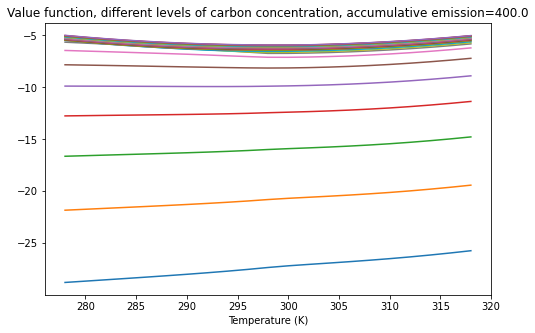

In [52]:
plt.plot(T_grid + T0, v0[:, :,10])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[10]))
plt.show()

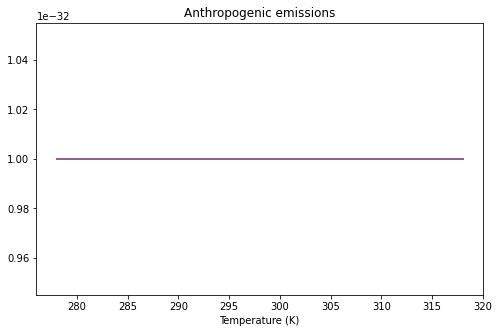

In [53]:
plt.plot(T_grid + T0, Ca[:, :, -3])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

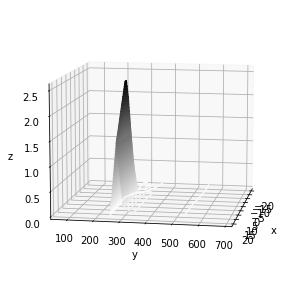

In [138]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, 3], 90, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 10)

In [157]:
t_max = 100.
dt = 1/12
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = 282.9
C_0 = 275.5
F_0 = 0.

def get_e(x):
    return Ca_func([x[0] - T_0, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - T0, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - T0, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


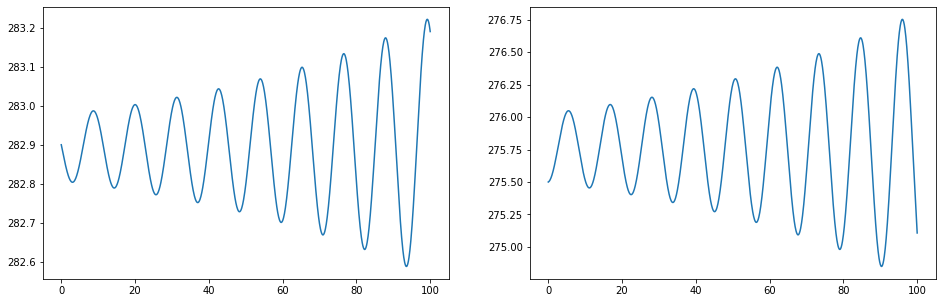

In [158]:
plt.subplots(1,2, figsize=(16,5))
plt.subplot(121)
plt.plot(years, hist[:, 0])
plt.subplot(122)
plt.plot(years, hist[:, 1])